# Init

In [1]:
import numpy as np
from pprint import pprint
from copy import deepcopy
import sys
from pathlib import Path


from laboneq.contrib.example_helpers.generate_descriptor import generate_descriptor
#from laboneq.contrib.example_helpers.generate_device_setup import generate_device_setup
from laboneq.dsl.device import DeviceSetup
from laboneq.simple import *
from laboneq.dsl.device import DeviceSetup
from laboneq.dsl.calibration import Oscillator, SignalCalibration
from laboneq.dsl.enums import ModulationType




# descriptor = generate_descriptor(
#     #pqsc=[""], # 장비 여러개 사용시
#     shfqc_6=["DEV12256"], 
#     number_data_qubits=3,
#     multiplex=True,
#     number_multiplex=6,
#     include_cr_lines=False,
#     include_ef_lines=True,
#     get_zsync=False,  # Only set to True when using real device
#     save = True,
#     filename="1port",
#     ip_address="192.168.0.83"
# )


#descriptor
#setup = DeviceSetup.from_descriptor(yaml_text=descriptor, server_host="192.168.0.83")
descriptor_candidates = [
    Path("examples/selectiveRIP/Descriptors/1port.yaml"),
    Path("Descriptors/1port.yaml"),
]
descriptor_path = next((p for p in descriptor_candidates if p.exists()), descriptor_candidates[0])
setup = DeviceSetup.from_yaml(filepath=str(descriptor_path.resolve()), server_host="192.168.0.83")
#setup
setup.instruments[0].device_options = 'SHFQC/PLUS/QC6CH'
#setup.instruments


bus_ids = [f"b{i}" for i in range(3)]
bus_port = [4,5,6] #used 1,2,3 for qubit drive

for i, bus in zip(bus_port,bus_ids):
    setup.add_connections(
        setup.instruments[0].uid,
        # each bus uses its own drive:
        create_connection(
            to_signal=f"{bus}/drive",
            ports=f"SGCHANNELS/{i}/OUTPUT"
        ))

# Calibrate qubit drive/measure lines for oscillator phase increments
qubit_ids = [uid for uid in setup.logical_signal_groups if uid.startswith("q")]
for qubit in qubit_ids:
    for line, frequency, mod_type in [
        ("drive", 5e9, ModulationType.HARDWARE),
        ("drive_ef", 6e9, ModulationType.HARDWARE),
        ("measure", 4e9, ModulationType.SOFTWARE),
    ]:
        logical_signal = setup.logical_signal_by_uid(f"{qubit}/{line}")
        oscillator = Oscillator(modulation_type=mod_type)
        logical_signal.calibration = SignalCalibration(
            local_oscillator=Oscillator(frequency=frequency),
            oscillator=oscillator,
        )
        if line == "measure":
            acquire_signal = setup.logical_signal_by_uid(f"{qubit}/acquire")
            acquire_signal.calibration = SignalCalibration(
                local_oscillator=Oscillator(frequency=frequency),
                oscillator=oscillator,
            )

project_root = next(
    (p for p in [Path.cwd(), *Path.cwd().parents] if (p / "qpu_types").exists() and (p / "helper.py").exists()),
    Path.cwd(),
)
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from qpu_types.fixed_transmon import FixedTransmonQubit, FixedTransmonQubitParameters
from qpu_types.bus_cavity import BusCavity, BusCavityParameters
from qpu_types.fixed_transmon.operations import FixedTransmonOperations
from qpu_types.bus_cavity.operations import BusCavityOperations
from laboneq.dsl.quantum.qpu import QPU, QuantumPlatform
from helper import load_qubit_parameters, save_qubit_parameters

qubit_uids = [uid for uid in setup.logical_signal_groups if uid.startswith("q")]
bus_uids = [uid for uid in setup.logical_signal_groups if uid.startswith("b")]

qubits = FixedTransmonQubit.from_device_setup(
    setup, qubit_uids=qubit_uids)
buses = BusCavity.from_device_setup(
    setup, qubit_uids=bus_uids)

qpu = QPU(quantum_elements={"qubits" : qubits, "bus" : buses}, quantum_operations=[FixedTransmonOperations, BusCavityOperations])


# from laboneq.simple import workflow
# folder_store = workflow.logbook.FolderStore("./experiment_store") 
# folder_store.activate()
# #folder_store.deactivate()
# #workflow.logbook.LoggingStore().activate()
# #workflow.logbook.LogbookStore().deactivate()

import os
from datetime import datetime
def find_latest_json(folder_path):
    files = [f for f in os.listdir(folder_path)]
    timestamps = []
    for file in files:
        try:
            # Extract a timestamp assuming it's included in the filename
            timestamp_str = file.split('_', 1)[0]  # Assuming YYYYMMDDHHMMSS format
            timestamp = datetime.strptime(timestamp_str, '%Y%m%d-%H%M%S')
            timestamps.append((timestamp, file))
        except ValueError:
            print("fuck")
            continue  # Skip files that do not match the timestamp format

       # Find the most recent file
    if timestamps:
        latest_file = max(timestamps, key=lambda x: x[0])[1]
        return os.path.join(folder_path, latest_file)
    return None

qb_pars_file = find_latest_json("./qpu_parameters/")
print(f"LOADED: {qb_pars_file}")

from qpu_types.fixed_transmon.operations import FixedTransmonOperations
from qpu_types.bus_cavity.operations import BusCavityOperations
import laboneq.dsl.quantum.qpu as qpu_mod

class CombinedOperations(FixedTransmonOperations, BusCavityOperations):
    pass

qpu_mod.CombinedOperations = CombinedOperations

qpu = load(qb_pars_file)

buses = qpu.groups.bus
qubits = qpu.groups.qubits


from laboneq.simple import workflow
folder_store = workflow.logbook.FolderStore("./experiment_store")
folder_store.activate()

fuck
LOADED: ./qpu_parameters/20260220-0809_readout_opt


In [2]:
from laboneq.simple import Session
session = Session(setup)
session.connect(ignore_version_mismatch=False, do_emulation=False)
#session.disconnect()

[2026.02.20 11:04:58.324] INFO    Logging initialized from [Default inline config in laboneq.laboneq_logging] logdir is /Users/yalgaeahn/Research/code/qubit-experiment/examples/selectiveRIP/laboneq_output/log
[2026.02.20 11:04:58.326] INFO    VERSION: laboneq 25.10.3
[2026.02.20 11:04:58.327] INFO    Connecting to data server at 192.168.0.83:8004
[2026.02.20 11:04:58.359] INFO    Connected to Zurich Instruments LabOne Data Server version 25.10.1.4 at 192.168.0.83:8004
[2026.02.20 11:04:58.400] INFO    Configuring the device setup
[2026.02.20 11:04:58.523] INFO    The device setup is configured


# Rabi amplitude

In [ ]:
from laboneq_applications.experiments import amplitude_rabi
q = qubits[1]
temporary_parameters = {}
temp_pars =deepcopy(q.parameters)

temporary_parameters[q.uid] = temp_pars

#######################################################################
amplitudes = np.linspace(0.0, 1.0,101)
print(q.parameters.ge_drive_amplitude_pi)
print(f"DRIVE range (dBm) : {q.parameters.drive_range}, READOUT range (dBm) : {q.parameters.readout_range_out}")
#######################################################################
options = amplitude_rabi.experiment_workflow.options()
options.update(False)
options.use_cal_traces(True)
options.count(1024)
#print(workflow.show_fields(options))

###################################################################
rabi_amp = amplitude_rabi.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=q,
    amplitudes=amplitudes,
    options=options,
    temporary_parameters = temporary_parameters
)

rabi_amp_result = rabi_amp.run()
#qubit_spec_compiled = session.compile(amplitude_rabi.create_experiment(qpu=qpu,qubit=q,amplitudes=amplitudes, options=options))
print(rabi_amp_result.tasks['analysis_workflow'].output)

# Ramsey

In [ ]:
from laboneq_applications.experiments import ramsey

q = qubits[1]
temporary_parameters = {}
temp_pars =deepcopy(q.parameters)
temp_pars.readout_amplitude = 1.0
temporary_parameters[q.uid] = temp_pars
#######################################################################
delays = np.linspace(0,20e-6,301)
detunings = 0.4e6 #4e6,
pprint(q.readout_parameters())
#######################################################################
options = ramsey.experiment_workflow.options()
options.update(True)
options.count(256)
options.use_cal_traces(True)
# Build and run Ramsey workflow (no explicit command table options required)
ramsey_wf = ramsey.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=q,
    delays=delays,
    detunings=detunings,
    options=options,
    temporary_parameters=temporary_parameters
)
ramsey_result = ramsey_wf.run()
#qubit_spec_compiled = session.compile(amplitude_rabi.create_experiment(qpu=qpu,qubit=q,amplitudes=amplitudes, options=options))
print(ramsey_result.tasks['analysis_workflow'].output)
#ramsey_result.tasks['analysis_workflow'].tasks['plot_population'].output['q0']

# X180

In [ ]:
from experiments import amplitude_fine
q = qubits[1]
temporary_parameters = {}
temp_pars =deepcopy(q.parameters)
temporary_parameters[q.uid] = temp_pars
#temp_pars.ge_drive_amplitude_pi =0.64
#######################################################################
repetitions =np.arange(1,12) # Due to short T1, 20   
#######################################################################
options = amplitude_fine.experiment_workflow_x180.options()
options.update(True)
options.use_cal_traces(True)
#options.do_pca(False)

#print(workflow.show_fields(options))

###################################################################
error_amp = amplitude_fine.experiment_workflow_x180(
    session=session,
    qpu=qpu,
    qubits=q,
    repetitions=repetitions,
    temporary_parameters=temporary_parameters,
    options=options
)

error_amp_result = error_amp.run()
#qubit_spec_compiled = session.compile(amplitude_rabi.create_experiment(qpu=qpu,qubit=q,amplitudes=amplitudes, options=options))
print(error_amp_result.tasks['analysis_workflow'].output)

# X90

In [ ]:
from experiments import amplitude_fine
q = qubits[1]
temporary_parameters = {}
temp_pars =deepcopy(q.parameters)
temporary_parameters[q.uid] = temp_pars
#######################################################################
repetitions =np.arange(1,10)
#######################################################################
options = amplitude_fine.experiment_workflow_x90.options()
options.update(True)
options.use_cal_traces(True)
options.count(1024)

#print(workflow.show_fields(options))

###################################################################
error_amp_half = amplitude_fine.experiment_workflow_x90(
    session=session,
    qpu=qpu,
    qubits=q,
    repetitions=repetitions,
    temporary_parameters=temporary_parameters,
    options=options
)

error_amp_half_result = error_amp_half.run()
#qubit_spec_compiled = session.compile(amplitude_rabi.create_experiment(qpu=qpu,qubit=q,amplitudes=amplitudes, options=options))
print(error_amp_half_result.tasks['analysis_workflow'].output)

# RB

In [ ]:
#from laboneq_applications.experiments import 
from experiments import single_qubit_randomized_benchmarking
q = qubits[1]
# temporary_parameters = {}
# temp_pars =deepcopy(q.parameters)
# temporary_parameters[q.uid] = temp_pars

#############################################
options = single_qubit_randomized_benchmarking.experiment_workflow.options()
options.count(1024)
options.transition("ge")


rb = single_qubit_randomized_benchmarking.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=q,
    length_cliffords=[1,5,10,20,50],
    variations=50,
    options=options,
)

rb_result = rb.run()

#######################################################################

# IQ Clouds

In [ ]:
from experiments import iq_cloud_common, iq_cloud
q = qubits[0]

temporary_parameters = {}
q_temp_pars = deepcopy(q.parameters)
temporary_parameters[q.uid] = q_temp_pars
#######################################################################

options = iq_cloud.experiment_workflow.options()
options.do_analysis(True)
options.update(False)
#options.count(1024)

iq_result = iq_cloud.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=q,
    temporary_parameters=temporary_parameters,
    options=options,
).run()


In [ ]:
qubits[0].readout_parameters()
qubits[0].readout_integration_parameters()

# Multiplexed IQ Clouds

In [ ]:
from experiments import iq_cloud_common, iq_cloud
q = qubits[0]
qq = qubits[1]

temporary_parameters = {}
q_temp_pars = deepcopy(q.parameters)
qq_temp_pars = deepcopy(qq.parameters)
temporary_parameters[q.uid] = q_temp_pars
temporary_parameters[qq.uid] = qq_temp_pars
#######################################################################

options = iq_cloud.experiment_workflow.options()
options.do_analysis(True)
options.update(False)
#options.count(1024)

iq_result = iq_cloud.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=[q,qq],
    temporary_parameters=temporary_parameters,
    options=options,
).run()




# Linear Phase Delay

In [ ]:
from experiments import linear_phase_delay


#######################################################################
q = qubits[1]
temporary_parameters = {}
temp_pars =deepcopy(q.parameters)
temporary_parameters[q.uid] = temp_pars

#######################################################################
options = linear_phase_delay.experiment_workflow.options()
options.count(256)
options.update(False)
#print(workflow.show_fields(options))

###################################################################
phase_delay = linear_phase_delay.experiment_workflow(
    session=session,
    qpu=qpu,
    qubit=q,
    frequencies=q.parameters.readout_resonator_frequency + np.linspace(5e6,45e6,201), # Use off resonance window
    options=options,
    temporary_parameters=temporary_parameters
)

phase_delay_result = phase_delay.run() 
print(phase_delay_result.tasks['analysis_workflow'].output)

# Dispersive Shift

- linear phase delay(τ)는 별도 캘리브레이션 모듈에서 구해 고정값으로 전달


$$
\phi_{\text{delay}}(f)=2\pi (f-f_{\text{ref}})\tau + \phi_0
$$

In [ ]:
from experiments import dispersive_shift


#######################################################################
q = qubits[1]
temporary_parameters = {}
temp_pars =deepcopy(q.parameters)
temp_pars.readout_amplitude = 1.0
temp_pars.readout_resonator_frequency = 7.5909e9
#temp_pars.readout_resonator_frequency = 7.5582e9
temporary_parameters[q.uid] = temp_pars

print(f"DRIVE range (dBm) : {q.parameters.drive_range}, READOUT range (dBm) : {q.parameters.readout_range_out}")
#######################################################################
options = dispersive_shift.experiment_workflow.options()
options.count(256)
options.update(False)
#print(workflow.show_fields(options))

###################################################################
dispersive = dispersive_shift.experiment_workflow(
    session=session,
    qpu=qpu,
    qubit=q,
    frequencies=q.parameters.readout_resonator_frequency + np.linspace(-3e6,3e6,101), #fine sweep 해야 기울기 잘 찾음
    options=options,
    phase_delay=90e-9,
    states='ge',
    temporary_parameters=temporary_parameters
)

dispersive_result = dispersive.run() 
print(dispersive_result.tasks['analysis_workflow'].output)

# Converged Readout Optimization process
“목표 fidelity를 만족하는 최소 amplitude/최소 length”를 선택하는 전략으로 바꾸면서 readout length sweep 이전에 readout amplitude sweep 하게끔 바꿈

In [ ]:
qubits[2].parameters.readout_integration_delay = 200e-9

In [ ]:
# [READOUT_OPT_V2_CONFIG]
# Converged readout optimization (MID/QND 제외):
# 목표 fidelity를 만족하는 최소 amplitude / 최소 length를 순차적으로 선택.

READOUT_OPT_V2_CONFIG = {
    "f_min": 0.95,
    "max_outer_iters": 1,
    "freq_span_coarse": 1.0e6,
    "freq_points_coarse": 13,
    "freq_span_mid": 250e3,
    "freq_points_mid": 11,
    "freq_span_fine": 80e3,
    "freq_points_fine": 9,
    "window_delay_span": 30e-9,
    "window_length_factors": (0.5, 0.6, 0.8, 1.0),
    "amp_frac": 0.20,
    "amp_points": 13,
    "amp_min": 0.4,
    "amp_max": 1.0,
    "amp_pick_mode": "max",  # "min" | "max" (within fidelity floor)
    "amp_polish_frac": 0.08,
    "amp_polish_points": 7,
    "length_factors": (0.3 ,0.4, 0.5, 0.6, 0.8),
    "count_freq": 1024 * 4,
    "count_other": 1024 * 2,
    "max_readout_length": 2.048e-6,
    "length_base_mode": "max_readout_length",
    "init_state_with_max_readout_length": True,
    "freq_converge_hz": 50e3,
    "freq_consecutive_hits": 1,
    # Optional step control:
    # "step_sequence": ("freq-coarse", "integration-window", "readout-length", "amplitude", "freq-refine-fine"),
    # "skip_steps": ("amplitude-polish", "amplitude-polish-final"),
}

print("READOUT_OPT_V2_CONFIG:")
pprint(READOUT_OPT_V2_CONFIG)





In [ ]:
# [READOUT_OPT_V2_HELPERS]
from copy import deepcopy
import importlib
import numpy as np

from experiments import (
    readout_frequency_sweep,
    readout_integration_delay_sweep,
    readout_amplitude_sweep,
    readout_length_sweep,
)

importlib.reload(readout_frequency_sweep)
importlib.reload(readout_integration_delay_sweep)
importlib.reload(readout_amplitude_sweep)
importlib.reload(readout_length_sweep)


def extract_analysis_output(workflow_result, max_depth: int = 24):
    """Unwrap LabOneQ workflow outputs until a dict containing best_point is found."""
    seen = set()
    queue = [(workflow_result, 0)]
    attrs = ("output", "analysis_result", "analysis_workflow_result", "analysis_workflow", "result", "tasks")

    while queue:
        current, depth = queue.pop(0)
        if current is None or depth > max_depth:
            continue
        oid = id(current)
        if oid in seen:
            continue
        seen.add(oid)

        if isinstance(current, dict):
            if isinstance(current.get("best_point"), dict):
                return current
            for k in attrs:
                if k in current:
                    queue.append((current[k], depth + 1))
            for v in current.values():
                queue.append((v, depth + 1))
            continue

        if isinstance(current, (list, tuple, set)):
            for v in current:
                queue.append((v, depth + 1))
            continue

        for a in attrs:
            if hasattr(current, a):
                try:
                    queue.append((getattr(current, a), depth + 1))
                except Exception:
                    pass

        d = getattr(current, "__dict__", None)
        if isinstance(d, dict):
            for v in d.values():
                queue.append((v, depth + 1))

    raise RuntimeError("Could not extract analysis output containing best_point.")


def _make_temp_params(qubit, state):
    temp = deepcopy(qubit.parameters)
    for k, v in state.items():
        if hasattr(temp, k):
            setattr(temp, k, v)
    return {qubit.uid: temp}


def _q_state_from_qubit(qubit):
    return {
        "readout_resonator_frequency": float(qubit.parameters.readout_resonator_frequency),
        "readout_integration_delay": float(qubit.parameters.readout_integration_delay or 0.0),
        "readout_integration_length": float(qubit.parameters.readout_integration_length),
        "readout_length": float(qubit.parameters.readout_length),
        "readout_amplitude": float(qubit.parameters.readout_amplitude),
    }


def _append_history(history, step, analysis, detail, state_snapshot, new_param_values=None, quality_suffix=None):
    quality = str(analysis.get("quality_flag", "unknown"))
    if quality_suffix:
        quality = f"{quality}|{quality_suffix}"
    history.append(
        {
            "step": step,
            "quality": quality,
            "detail": detail,
            "best_point": deepcopy(analysis.get("best_point", {})),
            "new_parameter_values": deepcopy(new_param_values or {}),
            "state_snapshot": deepcopy(state_snapshot),
        }
    )


def _print_history(history):
    for idx, item in enumerate(history, 1):
        print(f"[{idx:02d}] {item['step']:24s} quality={item['quality']:>20s} detail={item['detail']}")
        bp = item.get("best_point", {})
        for k in (
            "readout_resonator_frequency",
            "readout_amplitude",
            "readout_length",
            "assignment_fidelity",
            "delta_mu_over_sigma",
        ):
            if k in bp:
                print(f"    {k}: {bp[k]}")


def _pick_param_with_fidelity_floor(
    analysis,
    *,
    param_key: str,
    f_min: float,
    pick_mode: str = "min",
):
    """Pick parameter within fidelity floor. pick_mode: "min" or "max"."""
    mode = str(pick_mode).lower().strip()
    if mode not in ("min", "max"):
        raise ValueError(f"Unsupported pick_mode: {pick_mode!r}. Use 'min' or 'max'.")

    best = deepcopy(analysis.get("best_point", {}))
    metrics = analysis.get("metrics_vs_sweep", {})
    sweep_points = np.asarray(analysis.get("sweep_points", []), dtype=float).reshape(-1)
    fidelity = np.asarray(metrics.get("assignment_fidelity", []), dtype=float).reshape(-1)

    if sweep_points.size == 0 or fidelity.size == 0 or sweep_points.size != fidelity.size:
        chosen = float(best.get(param_key))
        return chosen, False, "no_metric_curve"

    mask = np.isfinite(sweep_points) & np.isfinite(fidelity) & (fidelity >= float(f_min))
    if np.any(mask):
        candidates = sweep_points[mask]
        chosen = float(np.min(candidates) if mode == "min" else np.max(candidates))
        return chosen, True, f"fidelity_floor_met_{mode}"

    chosen = float(best.get(param_key, sweep_points[int(np.nanargmax(fidelity))]))
    return chosen, False, "fidelity_unmet"



In [ ]:
# [READOUT_OPT_V2_CORE]
READOUT_OPT_V2_DEFAULT_STEP_SEQUENCE = (
    "freq-coarse",
    "integration-window",
    "amplitude",
    "readout-length",
    "freq-refine-mid",
    "amplitude-polish",
    "freq-refine-fine",
    "amplitude-polish-final",
    "integration-window-final",
)


def run_readout_converged_workflow_v2(
    q,
    qpu,
    session,
    *,
    state=None,
    config=None,
    do_plot=True,
    plot_iq_cloud=True,
    step_sequence=None,
    skip_steps=None,
):
    cfg = dict(READOUT_OPT_V2_CONFIG)
    if config is not None:
        cfg.update(config)

    default_steps = list(READOUT_OPT_V2_DEFAULT_STEP_SEQUENCE)
    configured_steps = cfg.get("step_sequence", None)
    if step_sequence is None:
        step_sequence = configured_steps if configured_steps is not None else default_steps
    if isinstance(step_sequence, str):
        step_sequence = [step_sequence]
    step_sequence = list(step_sequence)

    skip = set(skip_steps or ())
    skip.update(cfg.get("skip_steps", ()) or ())
    active_steps = [s for s in step_sequence if s not in skip]

    unknown = [s for s in active_steps if s not in READOUT_OPT_V2_DEFAULT_STEP_SEQUENCE]
    if unknown:
        raise ValueError(
            f"Unknown step name(s): {unknown}. "
            f"Available: {list(READOUT_OPT_V2_DEFAULT_STEP_SEQUENCE)}"
        )
    if not active_steps:
        raise ValueError("No active step remains after applying skip_steps.")

    state = _q_state_from_qubit(q) if state is None else deepcopy(state)
    history = []
    diagnostics = {
        "freq_deltas_hz": [],
        "fidelity_floor_events": [],
        "termination_reason": "",
        "step_sequence": list(active_steps),
        "skipped_steps": sorted(skip),
    }

    fidelity_checks = []

    if "freq-coarse" in active_steps:
        center_f = float(state["readout_resonator_frequency"])
        freqs = np.linspace(
            center_f - cfg["freq_span_coarse"],
            center_f + cfg["freq_span_coarse"],
            int(cfg["freq_points_coarse"]),
        )

        opts = readout_frequency_sweep.experiment_workflow.options()
        opts.do_analysis(True)
        opts.update(False)
        opts.count(int(cfg["count_freq"]))
        if not do_plot:
            opts.do_plotting(False)
        if not plot_iq_cloud and hasattr(opts, "do_plotting_optimal_iq_cloud"):
            opts.do_plotting_optimal_iq_cloud(False)

        wf = readout_frequency_sweep.experiment_workflow(
            session=session,
            qpu=qpu,
            qubit=q,
            frequencies=freqs,
            temporary_parameters=_make_temp_params(q, state),
            options=opts,
        )
        ana = extract_analysis_output(wf.run())
        best = ana["new_parameter_values"][q.uid]
        state["readout_resonator_frequency"] = float(best["readout_resonator_frequency"])
        _append_history(
            history,
            "freq-coarse",
            ana,
            f"center={center_f:.3f} Hz +/- {cfg['freq_span_coarse']:.0f} Hz",
            state,
            new_param_values=best,
        )

    prev_freq = float(state["readout_resonator_frequency"])
    consecutive_hits = 0
    converged = False
    outer_iters = 0

    outer_step_sequence = [s for s in active_steps if s != "freq-coarse"]
    diagnostics["outer_step_sequence"] = list(outer_step_sequence)

    if not outer_step_sequence:
        diagnostics["termination_reason"] = "no_outer_steps"
    else:
        for outer in range(1, int(cfg["max_outer_iters"]) + 1):
            outer_iters = outer
            freq_updated_in_outer = False

            for step_name in outer_step_sequence:
                if step_name == "integration-window":
                    center_delay = float(state["readout_integration_delay"])
                    center_len = float(state["readout_integration_length"])
                    delays = np.linspace(
                        max(0.0, center_delay - cfg["window_delay_span"]),
                        center_delay + cfg["window_delay_span"],
                        13,
                    )
                    integration_lengths = np.asarray(cfg["window_length_factors"], dtype=float) * center_len

                    max_ro_len = cfg.get("max_readout_length")
                    if max_ro_len is not None:
                        integration_cap = float(max_ro_len)
                        if integration_cap <= 0.0:
                            raise ValueError("max_readout_length must be positive.")
                        integration_lengths = np.clip(integration_lengths, 0.0, integration_cap)
                        integration_lengths = np.unique(integration_lengths)

                    opts = readout_integration_delay_sweep.experiment_workflow.options()
                    opts.do_analysis(True)
                    opts.update(False)
                    opts.count(int(cfg["count_other"]))
                    if not do_plot:
                        opts.do_plotting(False)

                    wf = readout_integration_delay_sweep.experiment_workflow(
                        session=session,
                        qpu=qpu,
                        qubit=q,
                        delays=delays,
                        integration_lengths=integration_lengths,
                        temporary_parameters=_make_temp_params(q, state),
                        options=opts,
                    )
                    ana = extract_analysis_output(wf.run())
                    best = ana["new_parameter_values"][q.uid]
                    state["readout_integration_delay"] = float(best["readout_integration_delay"])
                    state["readout_integration_length"] = float(best["readout_integration_length"])
                    if max_ro_len is not None:
                        max_len_for_state = float(max_ro_len)
                        if max_len_for_state <= 0.0:
                            raise ValueError("max_readout_length must be positive.")
                        state["readout_integration_length"] = min(
                            float(state["readout_integration_length"]),
                            max_len_for_state,
                        )

                    _append_history(
                        history,
                        "integration-window",
                        ana,
                        f"outer={outer}",
                        state,
                        new_param_values=best,
                    )

                elif step_name == "amplitude":
                    base_amp = float(state["readout_amplitude"])
                    if outer == 1:
                        amp_lo = max(0.0, float(cfg.get("amp_min", 0.4)))
                        amp_hi = min(1.0, float(cfg.get("amp_max", 1.0)))
                    else:
                        amp_span = max(0.05, abs(base_amp) * float(cfg["amp_frac"]))
                        amp_lo = max(0.0, base_amp - amp_span)
                        amp_hi = min(1.0, base_amp + amp_span)
                        if np.isclose(amp_lo, amp_hi):
                            amp_lo = max(0.0, base_amp - 0.02)
                            amp_hi = min(1.0, base_amp + 0.02)
                    amplitudes = np.linspace(amp_lo, amp_hi, int(cfg["amp_points"]))

                    opts = readout_amplitude_sweep.experiment_workflow.options()
                    opts.do_analysis(True)
                    opts.update(False)
                    opts.count(int(cfg["count_freq"]))
                    if not do_plot:
                        opts.do_plotting(False)

                    wf = readout_amplitude_sweep.experiment_workflow(
                        session=session,
                        qpu=qpu,
                        qubit=q,
                        amplitudes=amplitudes,
                        temporary_parameters=_make_temp_params(q, state),
                        options=opts,
                    )
                    ana = extract_analysis_output(wf.run())
                    selected_amp, amp_ok, amp_tag = _pick_param_with_fidelity_floor(
                        ana,
                        param_key="readout_amplitude",
                        f_min=float(cfg["f_min"]),
                        pick_mode=str(cfg.get("amp_pick_mode", "min")),
                    )
                    state["readout_amplitude"] = float(selected_amp)
                    fidelity_checks.append(bool(amp_ok))
                    diagnostics["fidelity_floor_events"].append(
                        {"step": "amplitude", "outer": outer, "status": amp_tag}
                    )

                    _append_history(
                        history,
                        "amplitude",
                        ana,
                        f"outer={outer}, sweep={amp_lo:.4f}..{amp_hi:.4f}",
                        state,
                        new_param_values={"readout_amplitude": float(selected_amp)},
                        quality_suffix=(None if amp_ok else "fidelity_unmet"),
                    )

                elif step_name == "readout-length":
                    max_ro_len = cfg.get("max_readout_length")
                    if cfg.get("length_base_mode", "max_readout_length") == "max_readout_length" and max_ro_len is not None:
                        base_len = float(max_ro_len)
                    else:
                        base_len = float(state["readout_length"])
                    lengths = np.asarray(cfg["length_factors"], dtype=float) * base_len
                    if max_ro_len is not None:
                        lengths = np.clip(lengths, 0.0, float(max_ro_len))
                        lengths = np.unique(lengths)
                    if lengths.size < 1:
                        raise ValueError("No valid readout_length points after clipping.")

                    opts = readout_length_sweep.experiment_workflow.options()
                    opts.do_analysis(True)
                    opts.update(False)
                    opts.count(int(cfg["count_other"]))
                    if not do_plot:
                        opts.do_plotting(False)

                    wf = readout_length_sweep.experiment_workflow(
                        session=session,
                        qpu=qpu,
                        qubit=q,
                        readout_lengths=lengths,
                        temporary_parameters=_make_temp_params(q, state),
                        options=opts,
                    )
                    ana = extract_analysis_output(wf.run())
                    selected_len, len_ok, len_tag = _pick_param_with_fidelity_floor(
                        ana,
                        param_key="readout_length",
                        f_min=float(cfg["f_min"]),
                        pick_mode="min",
                    )
                    state["readout_length"] = float(selected_len)
                    fidelity_checks.append(bool(len_ok))
                    diagnostics["fidelity_floor_events"].append(
                        {"step": "length", "outer": outer, "status": len_tag}
                    )

                    _append_history(
                        history,
                        "readout-length",
                        ana,
                        f"outer={outer}, factors={tuple(cfg['length_factors'])}",
                        state,
                        new_param_values={"readout_length": float(selected_len)},
                        quality_suffix=(None if len_ok else "fidelity_unmet"),
                    )

                elif step_name == "freq-refine-mid":
                    center_f = float(state["readout_resonator_frequency"])
                    freqs = np.linspace(
                        center_f - cfg["freq_span_mid"],
                        center_f + cfg["freq_span_mid"],
                        int(cfg["freq_points_mid"]),
                    )

                    opts = readout_frequency_sweep.experiment_workflow.options()
                    opts.do_analysis(True)
                    opts.update(False)
                    opts.count(int(cfg["count_freq"]))
                    if not do_plot:
                        opts.do_plotting(False)
                    if not plot_iq_cloud and hasattr(opts, "do_plotting_optimal_iq_cloud"):
                        opts.do_plotting_optimal_iq_cloud(False)

                    wf = readout_frequency_sweep.experiment_workflow(
                        session=session,
                        qpu=qpu,
                        qubit=q,
                        frequencies=freqs,
                        temporary_parameters=_make_temp_params(q, state),
                        options=opts,
                    )
                    ana = extract_analysis_output(wf.run())
                    best = ana["new_parameter_values"][q.uid]
                    state["readout_resonator_frequency"] = float(best["readout_resonator_frequency"])
                    _append_history(
                        history,
                        "freq-refine-mid",
                        ana,
                        f"outer={outer}, center={center_f:.3f} Hz +/- {cfg['freq_span_mid']:.0f} Hz",
                        state,
                        new_param_values=best,
                    )
                    freq_updated_in_outer = True

                elif step_name == "amplitude-polish":
                    base_amp = float(state["readout_amplitude"])
                    polish_span = max(0.01, abs(base_amp) * float(cfg["amp_polish_frac"]))
                    amp_lo = max(0.0, base_amp - polish_span)
                    amp_hi = min(1.0, base_amp + polish_span)
                    amplitudes = np.linspace(amp_lo, amp_hi, int(cfg["amp_polish_points"]))

                    opts = readout_amplitude_sweep.experiment_workflow.options()
                    opts.do_analysis(True)
                    opts.update(False)
                    opts.count(int(cfg["count_other"]))
                    if not do_plot:
                        opts.do_plotting(False)

                    wf = readout_amplitude_sweep.experiment_workflow(
                        session=session,
                        qpu=qpu,
                        qubit=q,
                        amplitudes=amplitudes,
                        temporary_parameters=_make_temp_params(q, state),
                        options=opts,
                    )
                    ana = extract_analysis_output(wf.run())
                    selected_amp, amp_ok, amp_tag = _pick_param_with_fidelity_floor(
                        ana,
                        param_key="readout_amplitude",
                        f_min=float(cfg["f_min"]),
                        pick_mode=str(cfg.get("amp_pick_mode", "min")),
                    )
                    state["readout_amplitude"] = float(selected_amp)
                    fidelity_checks.append(bool(amp_ok))
                    diagnostics["fidelity_floor_events"].append(
                        {"step": "amplitude-polish", "outer": outer, "status": amp_tag}
                    )

                    _append_history(
                        history,
                        "amplitude-polish",
                        ana,
                        f"outer={outer}, sweep={amp_lo:.4f}..{amp_hi:.4f}",
                        state,
                        new_param_values={"readout_amplitude": float(selected_amp)},
                        quality_suffix=(None if amp_ok else "fidelity_unmet"),
                    )

                elif step_name == "freq-refine-fine":
                    center_f = float(state["readout_resonator_frequency"])
                    freqs = np.linspace(
                        center_f - cfg["freq_span_fine"],
                        center_f + cfg["freq_span_fine"],
                        int(cfg["freq_points_fine"]),
                    )

                    opts = readout_frequency_sweep.experiment_workflow.options()
                    opts.do_analysis(True)
                    opts.update(False)
                    opts.count(int(cfg["count_freq"]))
                    if not do_plot:
                        opts.do_plotting(False)
                    if not plot_iq_cloud and hasattr(opts, "do_plotting_optimal_iq_cloud"):
                        opts.do_plotting_optimal_iq_cloud(False)

                    wf = readout_frequency_sweep.experiment_workflow(
                        session=session,
                        qpu=qpu,
                        qubit=q,
                        frequencies=freqs,
                        temporary_parameters=_make_temp_params(q, state),
                        options=opts,
                    )
                    ana = extract_analysis_output(wf.run())
                    best = ana["new_parameter_values"][q.uid]
                    state["readout_resonator_frequency"] = float(best["readout_resonator_frequency"])
                    _append_history(
                        history,
                        "freq-refine-fine",
                        ana,
                        f"outer={outer}, center={center_f:.3f} Hz +/- {cfg['freq_span_fine']:.0f} Hz",
                        state,
                        new_param_values=best,
                    )
                    freq_updated_in_outer = True

                elif step_name == "amplitude-polish-final":
                    base_amp = float(state["readout_amplitude"])
                    polish_span = max(0.01, abs(base_amp) * float(cfg["amp_polish_frac"]))
                    amp_lo = max(0.0, base_amp - polish_span)
                    amp_hi = min(1.0, base_amp + polish_span)
                    amplitudes = np.linspace(amp_lo, amp_hi, int(cfg["amp_polish_points"]))

                    opts = readout_amplitude_sweep.experiment_workflow.options()
                    opts.do_analysis(True)
                    opts.update(False)
                    opts.count(int(cfg["count_other"]))
                    if not do_plot:
                        opts.do_plotting(False)

                    wf = readout_amplitude_sweep.experiment_workflow(
                        session=session,
                        qpu=qpu,
                        qubit=q,
                        amplitudes=amplitudes,
                        temporary_parameters=_make_temp_params(q, state),
                        options=opts,
                    )
                    ana = extract_analysis_output(wf.run())
                    selected_amp, amp_ok, amp_tag = _pick_param_with_fidelity_floor(
                        ana,
                        param_key="readout_amplitude",
                        f_min=float(cfg["f_min"]),
                        pick_mode=str(cfg.get("amp_pick_mode", "min")),
                    )
                    state["readout_amplitude"] = float(selected_amp)
                    fidelity_checks.append(bool(amp_ok))
                    diagnostics["fidelity_floor_events"].append(
                        {"step": "amplitude-polish-final", "outer": outer, "status": amp_tag}
                    )

                    _append_history(
                        history,
                        "amplitude-polish-final",
                        ana,
                        f"outer={outer}, sweep={amp_lo:.4f}..{amp_hi:.4f}",
                        state,
                        new_param_values={"readout_amplitude": float(selected_amp)},
                        quality_suffix=(None if amp_ok else "fidelity_unmet"),
                    )

                elif step_name == "integration-window-final":
                    center_delay = float(state["readout_integration_delay"])
                    center_len = float(state["readout_integration_length"])
                    delays = np.linspace(
                        max(0.0, center_delay - cfg["window_delay_span"]),
                        center_delay + cfg["window_delay_span"],
                        13,
                    )
                    integration_lengths = np.asarray(cfg["window_length_factors"], dtype=float) * center_len

                    max_ro_len = cfg.get("max_readout_length")
                    if max_ro_len is not None:
                        integration_cap = float(max_ro_len)
                        if integration_cap <= 0.0:
                            raise ValueError("max_readout_length must be positive.")
                        integration_lengths = np.clip(integration_lengths, 0.0, integration_cap)
                        integration_lengths = np.unique(integration_lengths)

                    opts = readout_integration_delay_sweep.experiment_workflow.options()
                    opts.do_analysis(True)
                    opts.update(False)
                    opts.count(int(cfg["count_other"]))
                    if not do_plot:
                        opts.do_plotting(False)

                    wf = readout_integration_delay_sweep.experiment_workflow(
                        session=session,
                        qpu=qpu,
                        qubit=q,
                        delays=delays,
                        integration_lengths=integration_lengths,
                        temporary_parameters=_make_temp_params(q, state),
                        options=opts,
                    )
                    ana = extract_analysis_output(wf.run())
                    best = ana["new_parameter_values"][q.uid]
                    state["readout_integration_delay"] = float(best["readout_integration_delay"])
                    state["readout_integration_length"] = float(best["readout_integration_length"])
                    if max_ro_len is not None:
                        max_len_for_state = float(max_ro_len)
                        if max_len_for_state <= 0.0:
                            raise ValueError("max_readout_length must be positive.")
                        state["readout_integration_length"] = min(
                            float(state["readout_integration_length"]),
                            max_len_for_state,
                        )

                    _append_history(
                        history,
                        "integration-window-final",
                        ana,
                        f"outer={outer}",
                        state,
                        new_param_values=best,
                    )

                else:
                    raise RuntimeError(f"Unhandled step: {step_name}")

            if freq_updated_in_outer:
                new_freq = float(state["readout_resonator_frequency"])
                delta_f = abs(new_freq - prev_freq)
                diagnostics["freq_deltas_hz"].append(float(delta_f))

                if delta_f <= float(cfg["freq_converge_hz"]):
                    consecutive_hits += 1
                else:
                    consecutive_hits = 0
                prev_freq = new_freq

                if consecutive_hits >= int(cfg["freq_consecutive_hits"]):
                    converged = True
                    diagnostics["termination_reason"] = "converged"
                    break
            else:
                diagnostics["freq_deltas_hz"].append(float("nan"))
                consecutive_hits = 0

        if not converged and not diagnostics["termination_reason"]:
            diagnostics["termination_reason"] = "max_iter_reached"

    last_delta = float(diagnostics["freq_deltas_hz"][-1]) if diagnostics["freq_deltas_hz"] else float("nan")
    fidelity_floor_met = bool(all(fidelity_checks)) if fidelity_checks else False

    diagnostics.update(
        {
            "outer_iters": int(outer_iters),
            "converged": bool(converged),
            "last_delta_f_hz": float(last_delta),
            "fidelity_floor_met": bool(fidelity_floor_met),
        }
    )

    return {
        "final_state": deepcopy(state),
        "history": history,
        "diagnostics": diagnostics,
        "outer_iters": int(outer_iters),
        "converged": bool(converged),
        "last_delta_f_hz": float(last_delta),
        "fidelity_floor_met": bool(fidelity_floor_met),
    }


In [ ]:
# [READOUT_OPT_V2_RUN]
# Example run
if "qubits" not in globals() or len(qubits) < 1:
    raise RuntimeError("qubits is not available in notebook globals.")

###################
q_opt = qubits[1]##

# Step orchestration knobs: reorder/skip without touching core function.
custom_step_sequence = list(READOUT_OPT_V2_DEFAULT_STEP_SEQUENCE)
custom_skip_steps = ["amplitude-polish-final"]
###################
init_state = _q_state_from_qubit(q_opt)
if READOUT_OPT_V2_CONFIG.get("init_state_with_max_readout_length", True):
    _max_len = READOUT_OPT_V2_CONFIG.get("max_readout_length")
    if _max_len is not None:
        init_state["readout_length"] = float(_max_len)
        _cap = float(_max_len)
        if _cap <= 0.0:
            raise ValueError("max_readout_length must be positive.")
        init_state["readout_integration_length"] = float(_cap)

result_readout_opt_v2 = run_readout_converged_workflow_v2(
    q=q_opt,
    qpu=qpu,
    session=session,
    state=init_state,
    config=READOUT_OPT_V2_CONFIG,
    do_plot=True,
    plot_iq_cloud=True,
    step_sequence=custom_step_sequence,
    skip_steps=custom_skip_steps,
)

final_readout_state = result_readout_opt_v2["final_state"]
readout_opt_history = result_readout_opt_v2["history"]
readout_opt_diagnostics = result_readout_opt_v2["diagnostics"]

print("final_readout_state:")
pprint(final_readout_state)
print("\ndiagnostics:")
pprint(readout_opt_diagnostics)
print("\nhistory:")
_print_history(readout_opt_history)



In [ ]:
final_readout_state

In [ ]:
# [READOUT_OPT_V2_PERSIST]
# Optional: apply optimized state to in-memory qpu object before SAVE QPU cell.
apply_readout_state_to_qpu = True

if apply_readout_state_to_qpu:
    for _k, _v in final_readout_state.items():
        if hasattr(q_opt.parameters, _k):
            setattr(q_opt.parameters, _k, _v)
    print(f"Applied optimized readout state to {q_opt.uid} in current qpu object.")
else:
    print("apply_readout_state_to_qpu=False (no parameter mutation applied).")


# 2Q Multiplexed Readout Optimization
`max min(F_ctrl, F_targ)` 목적함수로 2Q 동시 readout 운영점을 탐색합니다.


In [7]:
# [READOUT_OPT_2Q_CONFIG]
READOUT_OPT_2Q_CONFIG = {
    "max_readout_length": 2.048e-6,
    "freq_coarse_span": 1.0e6,
    "freq_coarse_points": 7,
    "freq_refine_span": 250e3,
    "freq_refine_points": 5,
    "freq_fine_span": 80e3,
    "freq_fine_points": 5,
    "window_delay_span": 30e-9,
    "window_delay_points": 9,
    "window_length_factors_coarse": (0.7, 0.85, 1.0, 1.15),
    "window_length_factors_refine": (0.9, 1.0, 1.1),
    "amp_abs_range": (0.4, 1.0),
    "amp_coarse_points": 9,
    "amp_refine_frac": 0.12,
    "amp_refine_points": 7,
    "length_abs_range": (0.8e-6, 2.048e-6),
    "length_coarse_points": 6,
    "length_refine_span": 0.2e-6,
    "length_refine_points": 5,
    "count_coarse": 1024,
    "count_refine": 2048,
    "count_verify": 4096,
}

print("READOUT_OPT_2Q_CONFIG:")
pprint(READOUT_OPT_2Q_CONFIG)


READOUT_OPT_2Q_CONFIG:
{'amp_abs_range': (0.4, 1.0),
 'amp_coarse_points': 9,
 'amp_refine_frac': 0.12,
 'amp_refine_points': 7,
 'count_coarse': 1024,
 'count_refine': 2048,
 'count_verify': 4096,
 'freq_coarse_points': 7,
 'freq_coarse_span': 1000000.0,
 'freq_fine_points': 5,
 'freq_fine_span': 80000.0,
 'freq_refine_points': 5,
 'freq_refine_span': 250000.0,
 'length_abs_range': (8e-07, 2.048e-06),
 'length_coarse_points': 6,
 'length_refine_points': 5,
 'length_refine_span': 2e-07,
 'max_readout_length': 2.048e-06,
 'window_delay_points': 9,
 'window_delay_span': 3e-08,
 'window_length_factors_coarse': (0.7, 0.85, 1.0, 1.15),
 'window_length_factors_refine': (0.9, 1.0, 1.1)}


In [8]:
# [READOUT_OPT_2Q_HELPERS]
from copy import deepcopy
import importlib

from experiments import readout_multiplexed_optimization

importlib.reload(readout_multiplexed_optimization)


def extract_mxopt_output(workflow_result, max_depth: int = 24):
    """Extract dict payload containing final_state/history/best_point from workflow result."""
    seen = set()
    queue = [(workflow_result, 0)]
    attrs = ("output", "analysis_result", "result", "analysis_workflow_result")

    while queue:
        current, depth = queue.pop(0)
        if current is None or depth > max_depth:
            continue
        oid = id(current)
        if oid in seen:
            continue
        seen.add(oid)

        if isinstance(current, dict):
            if all(k in current for k in ("final_state", "history", "diagnostics", "best_point")):
                return current
            for k in attrs:
                if k in current:
                    queue.append((current[k], depth + 1))
            for v in current.values():
                queue.append((v, depth + 1))
            continue

        if isinstance(current, (list, tuple, set)):
            for v in current:
                queue.append((v, depth + 1))
            continue

        for a in attrs:
            if hasattr(current, a):
                try:
                    queue.append((getattr(current, a), depth + 1))
                except Exception:
                    pass

        d = getattr(current, "__dict__", None)
        if isinstance(d, dict):
            for v in d.values():
                queue.append((v, depth + 1))

    raise RuntimeError("Could not extract 2Q readout optimization payload.")


def _mxopt_print_history(history, max_rows: int = 40):
    for idx, item in enumerate(history[:max_rows], 1):
        bp = item.get("best_candidate", {}).get("metrics", {})
        print(
            f"[{idx:02d}] {item.get('step', ''):34s} "
            f"count={item.get('count')} candidates={item.get('candidate_count')} "
            f"quality={item.get('quality')} "
            f"F_min={bp.get('F_min')} F_joint={bp.get('F_joint')}"
        )



In [9]:
# [READOUT_OPT_2Q_RUN]
if "qubits" not in globals() or len(qubits) < 2:
    raise RuntimeError("Need at least two qubits in `qubits` for 2Q optimization.")

ctrl_idx = 0
targ_idx = 1
ctrl = qubits[ctrl_idx]
targ = qubits[targ_idx]

mx_opts = readout_multiplexed_optimization.experiment_workflow.options()
mx_opts.do_analysis(True)
mx_opts.do_plotting(True)
mx_opts.update(False)

wf_mx = readout_multiplexed_optimization.experiment_workflow(
    session=session,
    qpu=qpu,
    ctrl=ctrl,
    targ=targ,
    config=READOUT_OPT_2Q_CONFIG,
    options=mx_opts,
)

res_mx = wf_mx.run()
ana_mx = extract_mxopt_output(res_mx)

final_state_2q = ana_mx["final_state"]
history_2q = ana_mx["history"]
diagnostics_2q = ana_mx["diagnostics"]
best_point_2q = ana_mx["best_point"]

print("[2Q readout opt] quality:", ana_mx.get("quality_flag"))
print("[2Q readout opt] ctrl:", ctrl.uid, "targ:", targ.uid)
print("[2Q readout opt] min(F_ctrl, F_targ):", best_point_2q.get("F_min"))
print("[2Q readout opt] F_joint:", best_point_2q.get("F_joint"))
print("[2Q readout opt] F_avg:", best_point_2q.get("F_avg"))
print("[2Q readout opt] final_state:")
pprint(final_state_2q)

print("[2Q readout opt] history:")
_mxopt_print_history(history_2q)


[2026.02.20 11:11:21.487] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:21.487] INFO      Workflow 'readout_multiplexed_optimization': execution started at 2026-02-20  
[2026.02.20 11:11:21.488] INFO      02:11:21.486696Z                                                              
[2026.02.20 11:11:21.488] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:21.494] INFO    Task '_run_optimization': started at 2026-02-20 02:11:21.494004Z
[2026.02.20 11:11:21.498] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:21.498] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:21.497879Z         
[2026.02.20 11:11:21.499] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:21.511] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:21.511036Z
[

[2026.02.20 11:11:21.529] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:21.529754Z with: 


[2026.02.20 11:11:21.530] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:21.530] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:21.530] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:21.530] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:21.531] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:21.531] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:21.531] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:21.531692Z
[2026.02.20 11:11:21.532] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:21.532] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:21.532119Z           
[2026.02.20 11:11:21.532] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:21.536] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:21.537] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:21.536423Z         
[2026.02.20 11:11:21.537] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:21.550] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:21.549887Z
[2026.02.20 11:11:21.550] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:21.550827Z
[2026.02.20 11:11:21.553

[2026.02.20 11:11:21.564] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:21.564687Z with: 


[2026.02.20 11:11:21.565] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:21.565] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:21.565] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:21.565] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:21.565] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:21.565] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:21.566] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:21.566432Z
[2026.02.20 11:11:21.567] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:21.567] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:21.566925Z           
[2026.02.20 11:11:21.567] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:21.570] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:21.570] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:21.569588Z         
[2026.02.20 11:11:21.570] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:21.583] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:21.583586Z
[2026.02.20 11:11:21.591] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:21.590868Z
[2026.02.20 11:11:21.595

[2026.02.20 11:11:21.629] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:21.628756Z with: 


[2026.02.20 11:11:21.631] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:21.631] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:21.632] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:21.632] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:21.634] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:21.634] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:21.635] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:21.634852Z
[2026.02.20 11:11:21.635] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:21.635] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:21.635373Z           
[2026.02.20 11:11:21.635] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:21.638] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:21.638] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:21.638053Z         
[2026.02.20 11:11:21.638] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:21.651] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:21.651025Z
[2026.02.20 11:11:21.652] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:21.651910Z
[2026.02.20 11:11:21.655

[2026.02.20 11:11:21.665] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:21.665357Z with: 


[2026.02.20 11:11:21.665] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:21.665] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:21.666] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:21.666] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:21.666] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:21.666] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:21.667] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:21.667485Z
[2026.02.20 11:11:21.668] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:21.668] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:21.668429Z           
[2026.02.20 11:11:21.669] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:21.671] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:21.671] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:21.671222Z         
[2026.02.20 11:11:21.671] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:21.684] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:21.684302Z
[2026.02.20 11:11:21.685] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:21.685193Z
[2026.02.20 11:11:21.687

[2026.02.20 11:11:21.699] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:21.698920Z with: 


[2026.02.20 11:11:21.699] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:21.699] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:21.699] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:21.699] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:21.700] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:21.700] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:21.700] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:21.700709Z
[2026.02.20 11:11:21.701] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:21.701] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:21.701224Z           
[2026.02.20 11:11:21.701] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:21.704] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:21.704] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:21.703853Z         
[2026.02.20 11:11:21.704] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:21.716] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:21.715971Z
[2026.02.20 11:11:21.716] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:21.716859Z
[2026.02.20 11:11:21.719

[2026.02.20 11:11:21.730] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:21.730513Z with: 


[2026.02.20 11:11:21.731] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:21.731] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:21.731] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:21.731] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:21.731] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:21.731] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:21.732] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:21.732392Z
[2026.02.20 11:11:21.733] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:21.733] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:21.732860Z           
[2026.02.20 11:11:21.733] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:21.737] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:21.737] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:21.736927Z         
[2026.02.20 11:11:21.737] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:21.766] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:21.766614Z
[2026.02.20 11:11:21.774] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:21.774254Z
[2026.02.20 11:11:21.783

[2026.02.20 11:11:21.800] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:21.800272Z with: 


[2026.02.20 11:11:21.801] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:21.801] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:21.801] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:21.801] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:21.802] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:21.802] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:21.802] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:21.802576Z
[2026.02.20 11:11:21.803] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:21.803] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:21.803104Z           
[2026.02.20 11:11:21.803] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:21.806] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:21.806] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:21.805776Z         
[2026.02.20 11:11:21.806] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:21.817] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:21.817080Z
[2026.02.20 11:11:21.818] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:21.818414Z
[2026.02.20 11:11:21.821

[2026.02.20 11:11:21.832] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:21.832037Z with: 


[2026.02.20 11:11:21.832] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:21.832] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:21.833] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:21.833] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:21.833] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:21.833] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:21.834] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:21.833963Z
[2026.02.20 11:11:21.834] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:21.834] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:21.834490Z           
[2026.02.20 11:11:21.835] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:21.837] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:21.838] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:21.837389Z         
[2026.02.20 11:11:21.838] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:21.851] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:21.851393Z
[2026.02.20 11:11:21.852] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:21.852303Z
[2026.02.20 11:11:21.855

[2026.02.20 11:11:21.868] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:21.868081Z with: 


[2026.02.20 11:11:21.870] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:21.870] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:21.870] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:21.870] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:21.871] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:21.871] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:21.872] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:21.871882Z
[2026.02.20 11:11:21.872] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:21.872] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:21.872373Z           
[2026.02.20 11:11:21.873] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:21.876] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:21.877] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:21.875943Z         
[2026.02.20 11:11:21.877] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:21.888] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:21.888339Z
[2026.02.20 11:11:21.889] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:21.889169Z
[2026.02.20 11:11:21.891

[2026.02.20 11:11:21.902] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:21.902292Z with: 


[2026.02.20 11:11:21.902] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:21.902] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:21.903] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:21.903] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:21.903] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:21.903] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:21.904] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:21.903830Z
[2026.02.20 11:11:21.904] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:21.904] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:21.904253Z           
[2026.02.20 11:11:21.904] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:21.907] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:21.907] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:21.906974Z         
[2026.02.20 11:11:21.907] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:21.919] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:21.919354Z
[2026.02.20 11:11:21.920] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:21.920351Z
[2026.02.20 11:11:21.923

[2026.02.20 11:11:21.933] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:21.933650Z with: 


[2026.02.20 11:11:21.934] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:21.934] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:21.934] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:21.934] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:21.935] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:21.935] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:21.936] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:21.935908Z
[2026.02.20 11:11:21.936] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:21.936] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:21.936661Z           
[2026.02.20 11:11:21.937] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:21.940] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:21.940] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:21.939738Z         
[2026.02.20 11:11:21.940] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:21.953] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:21.953467Z
[2026.02.20 11:11:21.954] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:21.954380Z
[2026.02.20 11:11:21.956

[2026.02.20 11:11:21.967] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:21.967439Z with: 


[2026.02.20 11:11:21.968] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:21.968] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:21.968] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:21.968] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:21.968] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:21.968] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:21.969] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:21.969350Z
[2026.02.20 11:11:21.969] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:21.970] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:21.969769Z           
[2026.02.20 11:11:21.970] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:21.972] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:21.972] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:21.972305Z         
[2026.02.20 11:11:21.972] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:21.985] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:21.985160Z
[2026.02.20 11:11:21.986] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:21.986285Z
[2026.02.20 11:11:21.989

[2026.02.20 11:11:22.000] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:22.000074Z with: 


[2026.02.20 11:11:22.000] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:22.000] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:22.001] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:22.001] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:22.002] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:22.002] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:22.003] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:22.002950Z
[2026.02.20 11:11:22.003] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.004] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:22.003611Z           
[2026.02.20 11:11:22.004] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.007] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.007] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:22.006771Z         
[2026.02.20 11:11:22.007] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.016] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:22.015888Z
[2026.02.20 11:11:22.016] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:22.016863Z
[2026.02.20 11:11:22.020

[2026.02.20 11:11:22.035] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:22.034830Z with: 


[2026.02.20 11:11:22.035] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:22.035] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:22.035] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:22.035] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:22.036] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:22.036] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:22.036] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:22.036613Z
[2026.02.20 11:11:22.037] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.037] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:22.037107Z           
[2026.02.20 11:11:22.037] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.039] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.040] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:22.039504Z         
[2026.02.20 11:11:22.040] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.053] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:22.053059Z
[2026.02.20 11:11:22.054] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:22.054064Z
[2026.02.20 11:11:22.057

[2026.02.20 11:11:22.067] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:22.067428Z with: 


[2026.02.20 11:11:22.067] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:22.067] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:22.068] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:22.068] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:22.069] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:22.069] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:22.073] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:22.072746Z
[2026.02.20 11:11:22.074] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.074] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:22.073720Z           
[2026.02.20 11:11:22.074] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.077] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.077] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:22.077332Z         
[2026.02.20 11:11:22.078] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.092] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:22.091861Z
[2026.02.20 11:11:22.092] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:22.092745Z
[2026.02.20 11:11:22.095

[2026.02.20 11:11:22.106] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:22.106394Z with: 


[2026.02.20 11:11:22.106] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:22.106] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:22.107] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:22.107] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:22.107] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:22.107] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:22.108] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:22.108312Z
[2026.02.20 11:11:22.109] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.109] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:22.109260Z           
[2026.02.20 11:11:22.109] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.112] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.112] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:22.112137Z         
[2026.02.20 11:11:22.112] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.124] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:22.124339Z
[2026.02.20 11:11:22.125] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:22.125177Z
[2026.02.20 11:11:22.135

[2026.02.20 11:11:22.163] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:22.163678Z with: 


[2026.02.20 11:11:22.164] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:22.164] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:22.164] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:22.164] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:22.165] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:22.165] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:22.166] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:22.166326Z
[2026.02.20 11:11:22.168] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.169] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:22.167746Z           
[2026.02.20 11:11:22.169] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.175] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.176] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:22.175095Z         
[2026.02.20 11:11:22.176] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.188] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:22.187693Z
[2026.02.20 11:11:22.189] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:22.188917Z
[2026.02.20 11:11:22.191

[2026.02.20 11:11:22.202] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:22.202426Z with: 


[2026.02.20 11:11:22.203] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:22.203] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:22.203] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:22.203] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:22.203] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:22.203] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:22.204] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:22.204341Z
[2026.02.20 11:11:22.205] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.205] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:22.204902Z           
[2026.02.20 11:11:22.205] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.207] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.208] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:22.207692Z         
[2026.02.20 11:11:22.208] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.220] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:22.220194Z
[2026.02.20 11:11:22.222] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:22.222105Z
[2026.02.20 11:11:22.224

[2026.02.20 11:11:22.235] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:22.235196Z with: 


[2026.02.20 11:11:22.235] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:22.235] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:22.236] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:22.236] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:22.236] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:22.236] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:22.237] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:22.237034Z
[2026.02.20 11:11:22.237] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.237] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:22.237537Z           
[2026.02.20 11:11:22.238] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.240] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.240] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:22.240244Z         
[2026.02.20 11:11:22.241] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.253] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:22.252891Z
[2026.02.20 11:11:22.254] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:22.254015Z
[2026.02.20 11:11:22.256

[2026.02.20 11:11:22.287] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:22.287093Z with: 


[2026.02.20 11:11:22.289] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:22.289] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:22.290] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:22.290] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:22.293] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:22.293] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:22.294] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:22.294146Z
[2026.02.20 11:11:22.295] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.295] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:22.294954Z           
[2026.02.20 11:11:22.295] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.299] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.300] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:22.298996Z         
[2026.02.20 11:11:22.301] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.319] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:22.319531Z
[2026.02.20 11:11:22.320] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:22.320395Z
[2026.02.20 11:11:22.323

[2026.02.20 11:11:22.334] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:22.334797Z with: 


[2026.02.20 11:11:22.341] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:22.341] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:22.342] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:22.342] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:22.343] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:22.343] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:22.344] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:22.343679Z
[2026.02.20 11:11:22.344] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.345] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:22.344620Z           
[2026.02.20 11:11:22.345] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.350] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.350] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:22.350179Z         
[2026.02.20 11:11:22.351] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.364] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:22.364265Z
[2026.02.20 11:11:22.365] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:22.365244Z
[2026.02.20 11:11:22.367

[2026.02.20 11:11:22.379] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:22.378960Z with: 


[2026.02.20 11:11:22.379] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:22.379] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:22.379] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:22.379] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:22.380] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:22.380] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:22.381] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:22.380978Z
[2026.02.20 11:11:22.381] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.381] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:22.381414Z           
[2026.02.20 11:11:22.381] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.384] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.384] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:22.384133Z         
[2026.02.20 11:11:22.384] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.395] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:22.395208Z
[2026.02.20 11:11:22.397] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:22.397734Z
[2026.02.20 11:11:22.401

[2026.02.20 11:11:22.413] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:22.413664Z with: 


[2026.02.20 11:11:22.414] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:22.414] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:22.414] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:22.414] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:22.415] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:22.415] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:22.416] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:22.416064Z
[2026.02.20 11:11:22.416] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.416] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:22.416556Z           
[2026.02.20 11:11:22.417] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.420] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.420] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:22.419626Z         
[2026.02.20 11:11:22.420] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.433] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:22.433304Z
[2026.02.20 11:11:22.434] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:22.434747Z
[2026.02.20 11:11:22.437

[2026.02.20 11:11:22.448] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:22.448665Z with: 


[2026.02.20 11:11:22.449] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:22.449] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:22.449] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:22.449] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:22.449] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:22.449] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:22.450] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:22.450589Z
[2026.02.20 11:11:22.451] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.451] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:22.450998Z           
[2026.02.20 11:11:22.451] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.453] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.454] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:22.453648Z         
[2026.02.20 11:11:22.454] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.467] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:22.467194Z
[2026.02.20 11:11:22.468] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:22.468631Z
[2026.02.20 11:11:22.472

[2026.02.20 11:11:22.483] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:22.483594Z with: 


[2026.02.20 11:11:22.484] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:22.484] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:22.484] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:22.484] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:22.485] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:22.485] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:22.485] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:22.485746Z
[2026.02.20 11:11:22.486] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.486] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:22.486363Z           
[2026.02.20 11:11:22.487] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.495] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.498] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:22.492861Z         
[2026.02.20 11:11:22.499] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.530] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:22.530131Z
[2026.02.20 11:11:22.531] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:22.531539Z
[2026.02.20 11:11:22.537

[2026.02.20 11:11:22.550] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:22.550683Z with: 


[2026.02.20 11:11:22.551] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:22.551] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:22.551] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:22.551] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:22.552] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:22.552] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:22.553] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:22.552818Z
[2026.02.20 11:11:22.553] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.553] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:22.553461Z           
[2026.02.20 11:11:22.554] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.558] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.559] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:22.557844Z         
[2026.02.20 11:11:22.559] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.571] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:22.571431Z
[2026.02.20 11:11:22.572] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:22.572214Z
[2026.02.20 11:11:22.574

[2026.02.20 11:11:22.585] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:22.585674Z with: 


[2026.02.20 11:11:22.588] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:22.588] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:22.589] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:22.589] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:22.590] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:22.590] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:22.591] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:22.591401Z
[2026.02.20 11:11:22.592] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.593] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:22.592512Z           
[2026.02.20 11:11:22.593] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.597] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.597] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:22.596853Z         
[2026.02.20 11:11:22.597] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.611] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:22.611364Z
[2026.02.20 11:11:22.612] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:22.612325Z
[2026.02.20 11:11:22.614

[2026.02.20 11:11:22.626] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:22.626182Z with: 


[2026.02.20 11:11:22.626] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:22.626] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:22.627] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:22.627] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:22.627] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:22.627] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:22.628] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:22.628004Z
[2026.02.20 11:11:22.628] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.628] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:22.628394Z           
[2026.02.20 11:11:22.629] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.632] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.632] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:22.631797Z         
[2026.02.20 11:11:22.632] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.645] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:22.645511Z
[2026.02.20 11:11:22.646] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:22.646456Z
[2026.02.20 11:11:22.649

[2026.02.20 11:11:22.660] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:22.660821Z with: 


[2026.02.20 11:11:22.661] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:22.661] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:22.661] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:22.661] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:22.662] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:22.662] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:22.662] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:22.662630Z
[2026.02.20 11:11:22.663] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.663] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:22.663111Z           
[2026.02.20 11:11:22.663] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.666] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.666] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:22.665891Z         
[2026.02.20 11:11:22.666] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.677] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:22.676933Z
[2026.02.20 11:11:22.679] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:22.679060Z
[2026.02.20 11:11:22.683

[2026.02.20 11:11:22.694] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:22.694748Z with: 


[2026.02.20 11:11:22.695] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:22.695] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:22.695] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:22.695] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:22.696] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:22.696] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:22.697] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:22.696896Z
[2026.02.20 11:11:22.697] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.697] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:22.697542Z           
[2026.02.20 11:11:22.698] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.701] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.701] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:22.700986Z         
[2026.02.20 11:11:22.701] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.715] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:22.715287Z
[2026.02.20 11:11:22.716] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:22.716669Z
[2026.02.20 11:11:22.730

[2026.02.20 11:11:22.759] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:22.759103Z with: 


[2026.02.20 11:11:22.759] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:22.759] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:22.760] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:22.760] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:22.760] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:22.760] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:22.762] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:22.761767Z
[2026.02.20 11:11:22.764] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.764] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:22.763893Z           
[2026.02.20 11:11:22.765] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.771] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.772] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:22.771138Z         
[2026.02.20 11:11:22.773] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.784] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:22.784373Z
[2026.02.20 11:11:22.785] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:22.785239Z
[2026.02.20 11:11:22.787

[2026.02.20 11:11:22.805] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:22.804818Z with: 


[2026.02.20 11:11:22.806] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:22.806] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:22.807] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:22.807] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:22.807] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:22.807] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:22.809] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:22.808865Z
[2026.02.20 11:11:22.809] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.810] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:22.809651Z           
[2026.02.20 11:11:22.810] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.815] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.815] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:22.814383Z         
[2026.02.20 11:11:22.816] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.828] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:22.828678Z
[2026.02.20 11:11:22.829] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:22.829832Z
[2026.02.20 11:11:22.832

[2026.02.20 11:11:22.844] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:22.844750Z with: 


[2026.02.20 11:11:22.845] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:22.845] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:22.845] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:22.845] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:22.846] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:22.846] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:22.846] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:22.846678Z
[2026.02.20 11:11:22.847] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.847] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:22.847215Z           
[2026.02.20 11:11:22.847] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.850] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.851] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:22.850601Z         
[2026.02.20 11:11:22.851] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.864] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:22.864683Z
[2026.02.20 11:11:22.865] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:22.865766Z
[2026.02.20 11:11:22.868

[2026.02.20 11:11:22.880] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:22.880046Z with: 


[2026.02.20 11:11:22.880] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:22.880] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:22.880] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:22.880] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:22.881] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:22.881] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:22.881] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:22.881809Z
[2026.02.20 11:11:22.882] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.883] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:22.882397Z           
[2026.02.20 11:11:22.883] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.886] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.887] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:22.886496Z         
[2026.02.20 11:11:22.887] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.901] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:22.901427Z
[2026.02.20 11:11:22.903] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:22.902986Z
[2026.02.20 11:11:22.905

[2026.02.20 11:11:22.918] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:22.918413Z with: 


[2026.02.20 11:11:22.918] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:22.918] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:22.919] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:22.919] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:22.919] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:22.919] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:22.920] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:22.920251Z
[2026.02.20 11:11:22.920] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.921] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:22.920773Z           
[2026.02.20 11:11:22.921] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.925] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.925] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:22.924663Z         
[2026.02.20 11:11:22.925] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.939] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:22.939784Z
[2026.02.20 11:11:22.940] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:22.940765Z
[2026.02.20 11:11:22.944

[2026.02.20 11:11:22.957] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:22.957353Z with: 


[2026.02.20 11:11:22.957] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:22.957] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:22.958] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:22.958] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:22.958] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:22.958] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:22.959] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:22.959157Z
[2026.02.20 11:11:22.959] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.960] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:22.959699Z           
[2026.02.20 11:11:22.960] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.963] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.963] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:22.963039Z         
[2026.02.20 11:11:22.964] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:22.981] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:22.978229Z
[2026.02.20 11:11:22.983] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:22.983567Z
[2026.02.20 11:11:22.987

[2026.02.20 11:11:23.000] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:23.000534Z with: 


[2026.02.20 11:11:23.001] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:23.001] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:23.001] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:23.001] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:23.001] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:23.001] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:23.003] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:23.002600Z
[2026.02.20 11:11:23.004] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.004] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:23.003833Z           
[2026.02.20 11:11:23.004] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.007] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.007] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:23.006870Z         
[2026.02.20 11:11:23.008] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.019] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:23.019583Z
[2026.02.20 11:11:23.021] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:23.020943Z
[2026.02.20 11:11:23.024

[2026.02.20 11:11:23.043] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:23.042490Z with: 


[2026.02.20 11:11:23.044] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:23.044] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:23.046] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:23.046] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:23.048] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:23.048] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:23.053] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:23.053392Z
[2026.02.20 11:11:23.054] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.056] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:23.054403Z           
[2026.02.20 11:11:23.058] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.073] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.075] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:23.072054Z         
[2026.02.20 11:11:23.076] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.097] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:23.097478Z
[2026.02.20 11:11:23.098] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:23.098703Z
[2026.02.20 11:11:23.102

[2026.02.20 11:11:23.115] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:23.115631Z with: 


[2026.02.20 11:11:23.116] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:23.116] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:23.116] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:23.116] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:23.117] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:23.117] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:23.117] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:23.117577Z
[2026.02.20 11:11:23.118] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.118] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:23.118157Z           
[2026.02.20 11:11:23.118] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.120] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.121] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:23.120662Z         
[2026.02.20 11:11:23.121] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.132] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:23.132104Z
[2026.02.20 11:11:23.134] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:23.134417Z
[2026.02.20 11:11:23.139

[2026.02.20 11:11:23.151] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:23.151243Z with: 


[2026.02.20 11:11:23.151] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:23.151] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:23.152] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:23.152] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:23.152] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:23.152] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:23.153] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:23.153321Z
[2026.02.20 11:11:23.154] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.154] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:23.153859Z           
[2026.02.20 11:11:23.154] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.157] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.157] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:23.156771Z         
[2026.02.20 11:11:23.157] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.173] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:23.172904Z
[2026.02.20 11:11:23.174] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:23.174250Z
[2026.02.20 11:11:23.178

[2026.02.20 11:11:23.189] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:23.189403Z with: 


[2026.02.20 11:11:23.189] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:23.189] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:23.190] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:23.190] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:23.191] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:23.191] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:23.191] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:23.191661Z
[2026.02.20 11:11:23.192] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.192] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:23.192241Z           
[2026.02.20 11:11:23.192] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.195] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.196] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:23.195501Z         
[2026.02.20 11:11:23.196] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.206] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:23.206257Z
[2026.02.20 11:11:23.207] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:23.207664Z
[2026.02.20 11:11:23.212

[2026.02.20 11:11:23.224] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:23.223955Z with: 


[2026.02.20 11:11:23.224] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:23.224] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:23.225] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:23.225] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:23.225] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:23.225] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:23.225] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:23.225809Z
[2026.02.20 11:11:23.226] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.226] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:23.226322Z           
[2026.02.20 11:11:23.226] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.229] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.229] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:23.229206Z         
[2026.02.20 11:11:23.230] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.241] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:23.241363Z
[2026.02.20 11:11:23.243] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:23.242972Z
[2026.02.20 11:11:23.246

[2026.02.20 11:11:23.257] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:23.257498Z with: 


[2026.02.20 11:11:23.258] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:23.258] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:23.258] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:23.258] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:23.259] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:23.259] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:23.259] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:23.259579Z
[2026.02.20 11:11:23.260] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.260] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:23.260180Z           
[2026.02.20 11:11:23.260] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.263] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.263] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:23.263321Z         
[2026.02.20 11:11:23.263] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.273] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:23.273596Z
[2026.02.20 11:11:23.275] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:23.275346Z
[2026.02.20 11:11:23.280

[2026.02.20 11:11:23.291] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:23.291321Z with: 


[2026.02.20 11:11:23.291] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:23.291] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:23.292] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:23.292] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:23.292] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:23.292] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:23.293] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:23.293161Z
[2026.02.20 11:11:23.293] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.293] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:23.293601Z           
[2026.02.20 11:11:23.294] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.297] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.297] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:23.296636Z         
[2026.02.20 11:11:23.297] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.310] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:23.310535Z
[2026.02.20 11:11:23.311] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:23.311731Z
[2026.02.20 11:11:23.314

[2026.02.20 11:11:23.325] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:23.325430Z with: 


[2026.02.20 11:11:23.329] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:23.329] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:23.330] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:23.330] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:23.330] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:23.330] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:23.332] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:23.331893Z
[2026.02.20 11:11:23.332] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.332] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:23.332450Z           
[2026.02.20 11:11:23.333] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.336] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.336] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:23.335744Z         
[2026.02.20 11:11:23.336] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.348] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:23.348053Z
[2026.02.20 11:11:23.349] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:23.349264Z
[2026.02.20 11:11:23.352

[2026.02.20 11:11:23.363] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:23.363768Z with: 


[2026.02.20 11:11:23.364] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:23.364] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:23.364] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:23.364] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:23.364] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:23.364] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:23.366] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:23.365961Z
[2026.02.20 11:11:23.366] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.366] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:23.366563Z           
[2026.02.20 11:11:23.367] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.374] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.376] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:23.373557Z         
[2026.02.20 11:11:23.378] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.409] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:23.408847Z
[2026.02.20 11:11:23.410] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:23.409884Z
[2026.02.20 11:11:23.415

[2026.02.20 11:11:23.428] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:23.428775Z with: 


[2026.02.20 11:11:23.429] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:23.429] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:23.429] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:23.429] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:23.430] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:23.430] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:23.431] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:23.431092Z
[2026.02.20 11:11:23.431] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.432] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:23.431715Z           
[2026.02.20 11:11:23.432] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.435] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.436] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:23.435104Z         
[2026.02.20 11:11:23.436] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.448] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:23.448696Z
[2026.02.20 11:11:23.449] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:23.449799Z
[2026.02.20 11:11:23.452

[2026.02.20 11:11:23.463] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:23.463231Z with: 


[2026.02.20 11:11:23.463] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:23.463] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:23.464] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:23.464] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:23.464] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:23.464] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:23.465] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:23.465060Z
[2026.02.20 11:11:23.465] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.465] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:23.465578Z           
[2026.02.20 11:11:23.466] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.468] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.469] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:23.468618Z         
[2026.02.20 11:11:23.469] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.478] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:23.478624Z
[2026.02.20 11:11:23.479] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:23.479528Z
[2026.02.20 11:11:23.486

[2026.02.20 11:11:23.504] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:23.504469Z with: 


[2026.02.20 11:11:23.505] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:23.505] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:23.505] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:23.505] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:23.505] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:23.505] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:23.506] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:23.506201Z
[2026.02.20 11:11:23.506] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.506] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:23.506630Z           
[2026.02.20 11:11:23.507] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.509] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.510] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:23.509620Z         
[2026.02.20 11:11:23.510] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.519] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:23.519305Z
[2026.02.20 11:11:23.521] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:23.520646Z
[2026.02.20 11:11:23.526

[2026.02.20 11:11:23.539] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:23.539520Z with: 


[2026.02.20 11:11:23.540] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:23.540] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:23.540] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:23.540] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:23.540] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:23.540] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:23.541] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:23.541550Z
[2026.02.20 11:11:23.542] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.542] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:23.542026Z           
[2026.02.20 11:11:23.542] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.545] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.545] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:23.545545Z         
[2026.02.20 11:11:23.546] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.558] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:23.558532Z
[2026.02.20 11:11:23.559] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:23.559423Z
[2026.02.20 11:11:23.561

[2026.02.20 11:11:23.572] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:23.572415Z with: 


[2026.02.20 11:11:23.572] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:23.572] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:23.573] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:23.573] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:23.573] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:23.573] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:23.574] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:23.574153Z
[2026.02.20 11:11:23.574] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.574] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:23.574609Z           
[2026.02.20 11:11:23.575] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.578] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.578] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:23.577788Z         
[2026.02.20 11:11:23.578] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.588] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:23.588532Z
[2026.02.20 11:11:23.590] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:23.590517Z
[2026.02.20 11:11:23.598

[2026.02.20 11:11:23.612] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:23.612670Z with: 


[2026.02.20 11:11:23.613] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:23.613] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:23.613] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:23.613] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:23.614] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:23.614] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:23.614] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:23.614759Z
[2026.02.20 11:11:23.615] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.615] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:23.615279Z           
[2026.02.20 11:11:23.615] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.619] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.619] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:23.618910Z         
[2026.02.20 11:11:23.620] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.632] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:23.632398Z
[2026.02.20 11:11:23.633] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:23.633585Z
[2026.02.20 11:11:23.636

[2026.02.20 11:11:23.649] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:23.649206Z with: 


[2026.02.20 11:11:23.649] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:23.649] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:23.650] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:23.650] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:23.650] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:23.650] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:23.651] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:23.650916Z
[2026.02.20 11:11:23.651] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.651] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:23.651344Z           
[2026.02.20 11:11:23.651] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.654] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.654] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:23.654071Z         
[2026.02.20 11:11:23.655] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.667] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:23.667362Z
[2026.02.20 11:11:23.668] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:23.668271Z
[2026.02.20 11:11:23.670

[2026.02.20 11:11:23.681] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:23.681595Z with: 


[2026.02.20 11:11:23.682] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:23.682] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:23.682] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:23.682] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:23.682] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:23.682] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:23.683] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:23.683378Z
[2026.02.20 11:11:23.683] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.684] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:23.683824Z           
[2026.02.20 11:11:23.684] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.687] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.687] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:23.687253Z         
[2026.02.20 11:11:23.688] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.697] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:23.697283Z
[2026.02.20 11:11:23.698] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:23.698206Z
[2026.02.20 11:11:23.701

[2026.02.20 11:11:23.716] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:23.715870Z with: 


[2026.02.20 11:11:23.716] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:23.716] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:23.716] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:23.716] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:23.717] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:23.717] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:23.717] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:23.717806Z
[2026.02.20 11:11:23.718] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.718] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:23.718250Z           
[2026.02.20 11:11:23.718] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.721] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.721] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:23.721187Z         
[2026.02.20 11:11:23.722] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.750] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:23.750640Z
[2026.02.20 11:11:23.757] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:23.752947Z
[2026.02.20 11:11:23.766

[2026.02.20 11:11:23.787] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:23.787228Z with: 


[2026.02.20 11:11:23.787] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:23.787] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:23.788] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:23.788] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:23.788] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:23.788] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:23.789] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:23.789138Z
[2026.02.20 11:11:23.789] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.789] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:23.789631Z           
[2026.02.20 11:11:23.790] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.793] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.793] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:23.792909Z         
[2026.02.20 11:11:23.793] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.805] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:23.805461Z
[2026.02.20 11:11:23.807] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:23.807207Z
[2026.02.20 11:11:23.810

[2026.02.20 11:11:23.821] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:23.821641Z with: 


[2026.02.20 11:11:23.822] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:23.822] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:23.822] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:23.822] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:23.822] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:23.822] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:23.823] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:23.823415Z
[2026.02.20 11:11:23.824] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.824] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:23.823963Z           
[2026.02.20 11:11:23.824] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.827] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.827] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:23.827220Z         
[2026.02.20 11:11:23.827] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.837] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:23.836769Z
[2026.02.20 11:11:23.838] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:23.837926Z
[2026.02.20 11:11:23.842

[2026.02.20 11:11:23.856] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:23.856445Z with: 


[2026.02.20 11:11:23.857] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:23.857] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:23.857] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:23.857] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:23.857] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:23.857] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:23.858] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:23.858035Z
[2026.02.20 11:11:23.859] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.859] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:23.859079Z           
[2026.02.20 11:11:23.859] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.862] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.863] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:23.862572Z         
[2026.02.20 11:11:23.863] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.873] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:23.872989Z
[2026.02.20 11:11:23.874] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:23.873941Z
[2026.02.20 11:11:23.876

[2026.02.20 11:11:23.896] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:23.896647Z with: 


[2026.02.20 11:11:23.897] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:23.897] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:23.897] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:23.897] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:23.898] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:23.898] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:23.898] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:23.898715Z
[2026.02.20 11:11:23.899] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.899] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:23.899333Z           
[2026.02.20 11:11:23.899] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.903] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.903] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:23.902818Z         
[2026.02.20 11:11:23.904] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.913] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:23.912921Z
[2026.02.20 11:11:23.914] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:23.913931Z
[2026.02.20 11:11:23.916

[2026.02.20 11:11:23.931] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:23.931127Z with: 


[2026.02.20 11:11:23.931] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:23.931] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:23.932] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:23.932] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:23.932] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:23.932] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:23.933] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:23.932936Z
[2026.02.20 11:11:23.933] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.933] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:23.933322Z           
[2026.02.20 11:11:23.933] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.936] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.936] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:23.936436Z         
[2026.02.20 11:11:23.937] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.946] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:23.946182Z
[2026.02.20 11:11:23.947] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:23.947133Z
[2026.02.20 11:11:23.954

[2026.02.20 11:11:23.965] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:23.965149Z with: 


[2026.02.20 11:11:23.965] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:23.965] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:23.966] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:23.966] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:23.966] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:23.966] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:23.967] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:23.967435Z
[2026.02.20 11:11:23.968] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.968] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:23.968105Z           
[2026.02.20 11:11:23.968] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.971] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.972] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:23.971658Z         
[2026.02.20 11:11:23.972] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:23.982] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:23.982010Z
[2026.02.20 11:11:23.983] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:23.983084Z
[2026.02.20 11:11:23.987

[2026.02.20 11:11:24.000] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:24.000343Z with: 


[2026.02.20 11:11:24.000] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:24.000] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:24.001] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:24.001] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:24.001] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:24.001] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:24.002] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:24.002347Z
[2026.02.20 11:11:24.002] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.003] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:24.002818Z           
[2026.02.20 11:11:24.003] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.006] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.006] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:24.005768Z         
[2026.02.20 11:11:24.007] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.016] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:24.016014Z
[2026.02.20 11:11:24.017] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:24.016879Z
[2026.02.20 11:11:24.020

[2026.02.20 11:11:24.063] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:24.063412Z with: 


[2026.02.20 11:11:24.065] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:24.065] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:24.066] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:24.066] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:24.066] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:24.066] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:24.067] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:24.067156Z
[2026.02.20 11:11:24.068] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.068] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:24.067794Z           
[2026.02.20 11:11:24.068] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.071] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.071] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:24.071308Z         
[2026.02.20 11:11:24.072] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.088] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:24.088589Z
[2026.02.20 11:11:24.089] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:24.089506Z
[2026.02.20 11:11:24.092

[2026.02.20 11:11:24.103] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:24.102918Z with: 


[2026.02.20 11:11:24.103] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:24.103] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:24.103] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:24.103] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:24.104] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:24.104] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:24.104] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:24.104607Z
[2026.02.20 11:11:24.105] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.105] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:24.105295Z           
[2026.02.20 11:11:24.106] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.108] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.109] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:24.108625Z         
[2026.02.20 11:11:24.109] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.118] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:24.118172Z
[2026.02.20 11:11:24.119] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:24.118922Z
[2026.02.20 11:11:24.121

[2026.02.20 11:11:24.131] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:24.131076Z with: 


[2026.02.20 11:11:24.131] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:24.131] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:24.131] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:24.131] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:24.132] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:24.132] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:24.132] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:24.132708Z
[2026.02.20 11:11:24.133] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.133] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:24.133165Z           
[2026.02.20 11:11:24.133] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.136] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.136] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:24.135645Z         
[2026.02.20 11:11:24.136] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.144] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:24.144807Z
[2026.02.20 11:11:24.145] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:24.145581Z
[2026.02.20 11:11:24.147

[2026.02.20 11:11:24.157] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:24.157520Z with: 


[2026.02.20 11:11:24.158] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:24.158] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:24.158] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:24.158] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:24.158] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:24.158] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:24.159] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:24.159210Z
[2026.02.20 11:11:24.159] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.159] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:24.159644Z           
[2026.02.20 11:11:24.160] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.162] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.162] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:24.162109Z         
[2026.02.20 11:11:24.162] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.170] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:24.170701Z
[2026.02.20 11:11:24.171] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:24.171389Z
[2026.02.20 11:11:24.173

[2026.02.20 11:11:24.183] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:24.182913Z with: 


[2026.02.20 11:11:24.183] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:24.183] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:24.183] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:24.183] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:24.183] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:24.183] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:24.184] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:24.184466Z
[2026.02.20 11:11:24.185] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.185] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:24.184910Z           
[2026.02.20 11:11:24.185] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.187] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.187] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:24.187389Z         
[2026.02.20 11:11:24.187] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.196] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:24.195857Z
[2026.02.20 11:11:24.196] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:24.196557Z
[2026.02.20 11:11:24.198

[2026.02.20 11:11:24.208] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:24.207877Z with: 


[2026.02.20 11:11:24.208] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:24.208] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:24.208] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:24.208] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:24.209] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:24.209] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:24.209] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:24.209574Z
[2026.02.20 11:11:24.210] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.210] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:24.209995Z           
[2026.02.20 11:11:24.210] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.212] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.212] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:24.212298Z         
[2026.02.20 11:11:24.213] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.221] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:24.221097Z
[2026.02.20 11:11:24.221] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:24.221804Z
[2026.02.20 11:11:24.223

[2026.02.20 11:11:24.233] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:24.233097Z with: 


[2026.02.20 11:11:24.233] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:24.233] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:24.233] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:24.233] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:24.234] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:24.234] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:24.234] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:24.234652Z
[2026.02.20 11:11:24.235] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.235] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:24.235038Z           
[2026.02.20 11:11:24.235] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.237] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.237] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:24.237418Z         
[2026.02.20 11:11:24.238] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.246] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:24.245865Z
[2026.02.20 11:11:24.246] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:24.246578Z
[2026.02.20 11:11:24.248

[2026.02.20 11:11:24.257] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:24.257737Z with: 


[2026.02.20 11:11:24.258] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:24.258] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:24.258] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:24.258] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:24.258] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:24.258] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:24.259] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:24.259437Z
[2026.02.20 11:11:24.259] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.260] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:24.259818Z           
[2026.02.20 11:11:24.260] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.262] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.262] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:24.262189Z         
[2026.02.20 11:11:24.262] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.271] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:24.271066Z
[2026.02.20 11:11:24.271] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:24.271779Z
[2026.02.20 11:11:24.274

[2026.02.20 11:11:24.283] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:24.283151Z with: 


[2026.02.20 11:11:24.283] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:24.283] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:24.284] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:24.284] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:24.284] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:24.284] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:24.285] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:24.285017Z
[2026.02.20 11:11:24.285] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.285] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:24.285380Z           
[2026.02.20 11:11:24.285] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.288] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.288] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:24.287845Z         
[2026.02.20 11:11:24.288] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.296] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:24.296593Z
[2026.02.20 11:11:24.297] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:24.297315Z
[2026.02.20 11:11:24.299

[2026.02.20 11:11:24.309] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:24.309075Z with: 


[2026.02.20 11:11:24.309] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:24.309] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:24.310] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:24.310] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:24.310] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:24.310] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:24.311] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:24.310912Z
[2026.02.20 11:11:24.311] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.311] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:24.311406Z           
[2026.02.20 11:11:24.311] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.314] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.314] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:24.313993Z         
[2026.02.20 11:11:24.314] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.322] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:24.322388Z
[2026.02.20 11:11:24.323] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:24.323173Z
[2026.02.20 11:11:24.325

[2026.02.20 11:11:24.334] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:24.334756Z with: 


[2026.02.20 11:11:24.335] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:24.335] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:24.335] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:24.335] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:24.335] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:24.335] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:24.336] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:24.336530Z
[2026.02.20 11:11:24.337] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.337] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:24.337061Z           
[2026.02.20 11:11:24.337] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.340] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.340] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:24.339836Z         
[2026.02.20 11:11:24.340] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.348] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:24.348216Z
[2026.02.20 11:11:24.349] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:24.348994Z
[2026.02.20 11:11:24.351

[2026.02.20 11:11:24.361] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:24.361553Z with: 


[2026.02.20 11:11:24.362] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:24.362] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:24.362] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:24.362] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:24.362] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:24.362] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:24.363] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:24.363457Z
[2026.02.20 11:11:24.364] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.364] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:24.363999Z           
[2026.02.20 11:11:24.364] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.367] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.367] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:24.366891Z         
[2026.02.20 11:11:24.367] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.375] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:24.375606Z
[2026.02.20 11:11:24.376] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:24.376379Z
[2026.02.20 11:11:24.378

[2026.02.20 11:11:24.389] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:24.388955Z with: 


[2026.02.20 11:11:24.389] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:24.389] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:24.389] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:24.389] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:24.390] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:24.390] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:24.390] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:24.390769Z
[2026.02.20 11:11:24.391] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.391] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:24.391313Z           
[2026.02.20 11:11:24.391] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.394] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.395] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:24.394653Z         
[2026.02.20 11:11:24.395] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.404] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:24.404312Z
[2026.02.20 11:11:24.405] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:24.405293Z
[2026.02.20 11:11:24.407

[2026.02.20 11:11:24.417] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:24.417391Z with: 


[2026.02.20 11:11:24.417] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:24.417] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:24.418] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:24.418] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:24.418] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:24.418] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:24.419] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:24.419017Z
[2026.02.20 11:11:24.419] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.419] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:24.419492Z           
[2026.02.20 11:11:24.420] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.422] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.422] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:24.422423Z         
[2026.02.20 11:11:24.423] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.431] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:24.431221Z
[2026.02.20 11:11:24.432] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:24.431944Z
[2026.02.20 11:11:24.434

[2026.02.20 11:11:24.444] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:24.444301Z with: 


[2026.02.20 11:11:24.444] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:24.444] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:24.445] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:24.445] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:24.445] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:24.445] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:24.445] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:24.445860Z
[2026.02.20 11:11:24.446] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.446] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:24.446246Z           
[2026.02.20 11:11:24.446] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.449] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.449] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:24.449047Z         
[2026.02.20 11:11:24.450] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.458] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:24.458115Z
[2026.02.20 11:11:24.459] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:24.458919Z
[2026.02.20 11:11:24.461

[2026.02.20 11:11:24.471] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:24.471139Z with: 


[2026.02.20 11:11:24.471] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:24.471] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:24.471] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:24.471] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:24.472] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:24.472] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:24.472] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:24.472594Z
[2026.02.20 11:11:24.473] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.473] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:24.473095Z           
[2026.02.20 11:11:24.473] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.476] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.476] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:24.475919Z         
[2026.02.20 11:11:24.476] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.485] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:24.485632Z
[2026.02.20 11:11:24.486] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:24.486427Z
[2026.02.20 11:11:24.488

[2026.02.20 11:11:24.499] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:24.498908Z with: 


[2026.02.20 11:11:24.499] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:24.499] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:24.499] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:24.499] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:24.500] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:24.500] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:24.500] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:24.500735Z
[2026.02.20 11:11:24.501] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.501] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:24.501286Z           
[2026.02.20 11:11:24.501] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.504] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.504] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:24.504128Z         
[2026.02.20 11:11:24.504] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.513] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:24.512860Z
[2026.02.20 11:11:24.513] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:24.513671Z
[2026.02.20 11:11:24.515

[2026.02.20 11:11:24.525] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:24.525284Z with: 


[2026.02.20 11:11:24.525] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:24.525] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:24.526] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:24.526] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:24.526] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:24.526] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:24.527] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:24.526967Z
[2026.02.20 11:11:24.527] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.527] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:24.527453Z           
[2026.02.20 11:11:24.527] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.530] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.530] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:24.530189Z         
[2026.02.20 11:11:24.530] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.539] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:24.538995Z
[2026.02.20 11:11:24.540] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:24.539906Z
[2026.02.20 11:11:24.542

[2026.02.20 11:11:24.551] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:24.551496Z with: 


[2026.02.20 11:11:24.552] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:24.552] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:24.552] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:24.552] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:24.552] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:24.552] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:24.553] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:24.553186Z
[2026.02.20 11:11:24.553] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.553] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:24.553679Z           
[2026.02.20 11:11:24.554] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.556] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.556] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:24.556427Z         
[2026.02.20 11:11:24.557] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.565] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:24.565286Z
[2026.02.20 11:11:24.566] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:24.566194Z
[2026.02.20 11:11:24.568

[2026.02.20 11:11:24.578] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:24.577883Z with: 


[2026.02.20 11:11:24.578] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:24.578] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:24.578] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:24.578] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:24.579] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:24.579] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:24.579] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:24.579582Z
[2026.02.20 11:11:24.580] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.580] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:24.580060Z           
[2026.02.20 11:11:24.580] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.583] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.583] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:24.583016Z         
[2026.02.20 11:11:24.583] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.591] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:24.591666Z
[2026.02.20 11:11:24.592] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:24.592415Z
[2026.02.20 11:11:24.594

[2026.02.20 11:11:24.631] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:24.631793Z with: 


[2026.02.20 11:11:24.632] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:24.632] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:24.632] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:24.632] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:24.633] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:24.633] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:24.635] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:24.634768Z
[2026.02.20 11:11:24.637] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.637] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:24.636975Z           
[2026.02.20 11:11:24.638] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.643] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.643] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:24.642995Z         
[2026.02.20 11:11:24.644] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.652] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:24.652415Z
[2026.02.20 11:11:24.653] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:24.653242Z
[2026.02.20 11:11:24.655

[2026.02.20 11:11:24.665] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:24.664950Z with: 


[2026.02.20 11:11:24.665] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:24.665] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:24.665] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:24.665] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:24.666] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:24.666] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:24.666] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:24.666732Z
[2026.02.20 11:11:24.667] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.667] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:24.667121Z           
[2026.02.20 11:11:24.667] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.670] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.670] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:24.670069Z         
[2026.02.20 11:11:24.670] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.678] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:24.678186Z
[2026.02.20 11:11:24.679] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:24.678967Z
[2026.02.20 11:11:24.681

[2026.02.20 11:11:24.691] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:24.691301Z with: 


[2026.02.20 11:11:24.691] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:24.691] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:24.692] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:24.692] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:24.692] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:24.692] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:24.693] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:24.693056Z
[2026.02.20 11:11:24.693] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.693] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:24.693436Z           
[2026.02.20 11:11:24.693] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.696] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.696] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:24.696423Z         
[2026.02.20 11:11:24.697] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.705] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:24.705232Z
[2026.02.20 11:11:24.706] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:24.706056Z
[2026.02.20 11:11:24.708

[2026.02.20 11:11:24.717] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:24.717682Z with: 


[2026.02.20 11:11:24.718] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:24.718] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:24.718] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:24.718] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:24.718] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:24.718] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:24.719] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:24.719306Z
[2026.02.20 11:11:24.719] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.720] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:24.719721Z           
[2026.02.20 11:11:24.720] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.723] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.723] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:24.722872Z         
[2026.02.20 11:11:24.723] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.731] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:24.731742Z
[2026.02.20 11:11:24.732] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:24.732512Z
[2026.02.20 11:11:24.734

[2026.02.20 11:11:24.744] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:24.744647Z with: 


[2026.02.20 11:11:24.745] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:24.745] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:24.745] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:24.745] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:24.745] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:24.745] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:24.746] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:24.746252Z
[2026.02.20 11:11:24.746] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.746] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:24.746640Z           
[2026.02.20 11:11:24.747] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.750] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.750] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:24.749804Z         
[2026.02.20 11:11:24.750] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.758] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:24.758210Z
[2026.02.20 11:11:24.759] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:24.759060Z
[2026.02.20 11:11:24.761

[2026.02.20 11:11:24.771] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:24.770899Z with: 


[2026.02.20 11:11:24.771] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:24.771] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:24.771] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:24.771] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:24.772] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:24.772] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:24.772] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:24.772490Z
[2026.02.20 11:11:24.773] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.773] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:24.772944Z           
[2026.02.20 11:11:24.773] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.776] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.776] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:24.776062Z         
[2026.02.20 11:11:24.776] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.785] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:24.784908Z
[2026.02.20 11:11:24.785] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:24.785688Z
[2026.02.20 11:11:24.787

[2026.02.20 11:11:24.797] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:24.797292Z with: 


[2026.02.20 11:11:24.797] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:24.797] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:24.798] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:24.798] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:24.798] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:24.798] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:24.799] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:24.798944Z
[2026.02.20 11:11:24.799] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.799] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:24.799296Z           
[2026.02.20 11:11:24.799] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.802] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.802] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:24.802237Z         
[2026.02.20 11:11:24.802] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.810] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:24.810594Z
[2026.02.20 11:11:24.811] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:24.811420Z
[2026.02.20 11:11:24.813

[2026.02.20 11:11:24.822] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:24.822678Z with: 


[2026.02.20 11:11:24.823] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:24.823] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:24.823] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:24.823] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:24.823] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:24.823] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:24.824] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:24.824361Z
[2026.02.20 11:11:24.824] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.825] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:24.824727Z           
[2026.02.20 11:11:24.825] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.827] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.828] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:24.827688Z         
[2026.02.20 11:11:24.828] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.836] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:24.835907Z
[2026.02.20 11:11:24.836] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:24.836712Z
[2026.02.20 11:11:24.838

[2026.02.20 11:11:24.848] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:24.848486Z with: 


[2026.02.20 11:11:24.848] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:24.848] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:24.849] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:24.849] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:24.849] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:24.849] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:24.850] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:24.850051Z
[2026.02.20 11:11:24.850] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.850] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:24.850431Z           
[2026.02.20 11:11:24.850] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.853] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.853] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:24.853386Z         
[2026.02.20 11:11:24.854] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.861] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:24.861784Z
[2026.02.20 11:11:24.862] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:24.862675Z
[2026.02.20 11:11:24.864

[2026.02.20 11:11:24.875] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:24.875147Z with: 


[2026.02.20 11:11:24.875] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:24.875] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:24.876] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:24.876] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:24.876] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:24.876] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:24.876] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:24.876866Z
[2026.02.20 11:11:24.877] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.877] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:24.877239Z           
[2026.02.20 11:11:24.877] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.880] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.881] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:24.880356Z         
[2026.02.20 11:11:24.881] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.889] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:24.889692Z
[2026.02.20 11:11:24.890] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:24.890450Z
[2026.02.20 11:11:24.892

[2026.02.20 11:11:24.902] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:24.902541Z with: 


[2026.02.20 11:11:24.903] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:24.903] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:24.903] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:24.903] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:24.903] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:24.903] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:24.904] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:24.904277Z
[2026.02.20 11:11:24.904] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.904] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:24.904658Z           
[2026.02.20 11:11:24.905] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.908] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.908] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:24.907777Z         
[2026.02.20 11:11:24.908] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.916] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:24.916539Z
[2026.02.20 11:11:24.917] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:24.917306Z
[2026.02.20 11:11:24.919

[2026.02.20 11:11:24.929] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:24.929037Z with: 


[2026.02.20 11:11:24.929] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:24.929] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:24.929] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:24.929] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:24.930] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:24.930] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:24.930] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:24.930590Z
[2026.02.20 11:11:24.931] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.931] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:24.930956Z           
[2026.02.20 11:11:24.931] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.934] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.934] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:24.934030Z         
[2026.02.20 11:11:24.934] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.942] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:24.942418Z
[2026.02.20 11:11:24.943] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:24.943120Z
[2026.02.20 11:11:24.945

[2026.02.20 11:11:24.954] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:24.954703Z with: 


[2026.02.20 11:11:24.955] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:24.955] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:24.955] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:24.955] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:24.955] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:24.955] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:24.956] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:24.956334Z
[2026.02.20 11:11:24.956] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.957] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:24.956713Z           
[2026.02.20 11:11:24.957] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.960] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.960] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:24.959901Z         
[2026.02.20 11:11:24.960] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.968] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:24.968663Z
[2026.02.20 11:11:24.969] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:24.969345Z
[2026.02.20 11:11:24.971

[2026.02.20 11:11:24.981] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:24.981832Z with: 


[2026.02.20 11:11:24.982] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:24.982] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:24.982] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:24.982] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:24.983] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:24.983] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:24.983] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:24.983564Z
[2026.02.20 11:11:24.984] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.984] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:24.983920Z           
[2026.02.20 11:11:24.984] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.987] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.987] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:24.986862Z         
[2026.02.20 11:11:24.987] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:24.995] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:24.995081Z
[2026.02.20 11:11:24.995] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:24.995810Z
[2026.02.20 11:11:24.997

[2026.02.20 11:11:25.008] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:25.007938Z with: 


[2026.02.20 11:11:25.008] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:25.008] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:25.008] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:25.008] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:25.009] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:25.009] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:25.009] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:25.009448Z
[2026.02.20 11:11:25.009] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.010] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:25.009769Z           
[2026.02.20 11:11:25.010] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.012] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.012] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:25.012035Z         
[2026.02.20 11:11:25.012] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.021] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:25.020880Z
[2026.02.20 11:11:25.021] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:25.021575Z
[2026.02.20 11:11:25.023

[2026.02.20 11:11:25.043] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:25.042982Z with: 


[2026.02.20 11:11:25.044] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:25.044] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:25.046] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:25.046] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:25.052] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:25.052] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:25.054] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:25.054415Z
[2026.02.20 11:11:25.056] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.056] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:25.055733Z           
[2026.02.20 11:11:25.057] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.062] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.062] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:25.061670Z         
[2026.02.20 11:11:25.062] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.077] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:25.076864Z
[2026.02.20 11:11:25.077] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:25.077710Z
[2026.02.20 11:11:25.080

[2026.02.20 11:11:25.089] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:25.089431Z with: 


[2026.02.20 11:11:25.090] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:25.090] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:25.090] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:25.090] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:25.090] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:25.090] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:25.091] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:25.091155Z
[2026.02.20 11:11:25.091] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.091] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:25.091630Z           
[2026.02.20 11:11:25.092] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.094] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.094] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:25.094012Z         
[2026.02.20 11:11:25.094] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.102] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:25.102707Z
[2026.02.20 11:11:25.103] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:25.103395Z
[2026.02.20 11:11:25.105

[2026.02.20 11:11:25.115] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:25.115666Z with: 


[2026.02.20 11:11:25.116] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:25.116] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:25.116] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:25.116] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:25.116] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:25.116] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:25.117] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:25.117354Z
[2026.02.20 11:11:25.117] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.118] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:25.117772Z           
[2026.02.20 11:11:25.118] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.120] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.121] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:25.120197Z         
[2026.02.20 11:11:25.121] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.130] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:25.130175Z
[2026.02.20 11:11:25.131] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:25.131035Z
[2026.02.20 11:11:25.133

[2026.02.20 11:11:25.143] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:25.143339Z with: 


[2026.02.20 11:11:25.143] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:25.143] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:25.144] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:25.144] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:25.144] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:25.144] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:25.145] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:25.144971Z
[2026.02.20 11:11:25.145] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.145] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:25.145426Z           
[2026.02.20 11:11:25.145] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.148] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.148] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:25.147858Z         
[2026.02.20 11:11:25.148] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.157] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:25.157011Z
[2026.02.20 11:11:25.157] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:25.157787Z
[2026.02.20 11:11:25.159

[2026.02.20 11:11:25.169] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:25.169591Z with: 


[2026.02.20 11:11:25.170] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:25.170] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:25.170] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:25.170] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:25.170] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:25.170] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:25.171] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:25.171212Z
[2026.02.20 11:11:25.171] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.171] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:25.171622Z           
[2026.02.20 11:11:25.172] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.174] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.174] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:25.173917Z         
[2026.02.20 11:11:25.174] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.182] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:25.182349Z
[2026.02.20 11:11:25.183] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:25.183028Z
[2026.02.20 11:11:25.185

[2026.02.20 11:11:25.195] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:25.195765Z with: 


[2026.02.20 11:11:25.196] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:25.196] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:25.196] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:25.196] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:25.197] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:25.197] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:25.197] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:25.197578Z
[2026.02.20 11:11:25.198] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.198] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:25.198130Z           
[2026.02.20 11:11:25.198] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.201] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.201] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:25.200769Z         
[2026.02.20 11:11:25.201] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.212] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:25.212594Z
[2026.02.20 11:11:25.213] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:25.213461Z
[2026.02.20 11:11:25.216

[2026.02.20 11:11:25.230] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:25.230087Z with: 


[2026.02.20 11:11:25.230] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:25.230] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:25.230] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:25.230] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:25.231] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:25.231] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:25.232] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:25.231955Z
[2026.02.20 11:11:25.232] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.232] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:25.232341Z           
[2026.02.20 11:11:25.232] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.235] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.235] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:25.235021Z         
[2026.02.20 11:11:25.235] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.244] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:25.244770Z
[2026.02.20 11:11:25.245] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:25.245580Z
[2026.02.20 11:11:25.247

[2026.02.20 11:11:25.258] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:25.257854Z with: 


[2026.02.20 11:11:25.258] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:25.258] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:25.258] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:25.258] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:25.258] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:25.258] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:25.259] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:25.259403Z
[2026.02.20 11:11:25.259] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.260] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:25.259852Z           
[2026.02.20 11:11:25.260] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.262] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.262] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:25.262269Z         
[2026.02.20 11:11:25.262] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.271] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:25.271327Z
[2026.02.20 11:11:25.272] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:25.272176Z
[2026.02.20 11:11:25.274

[2026.02.20 11:11:25.284] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:25.283920Z with: 


[2026.02.20 11:11:25.284] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:25.284] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:25.284] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:25.284] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:25.285] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:25.285] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:25.285] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:25.285669Z
[2026.02.20 11:11:25.286] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.286] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:25.286040Z           
[2026.02.20 11:11:25.286] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.288] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.289] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:25.288562Z         
[2026.02.20 11:11:25.289] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.297] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:25.297624Z
[2026.02.20 11:11:25.298] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:25.298411Z
[2026.02.20 11:11:25.300

[2026.02.20 11:11:25.310] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:25.310082Z with: 


[2026.02.20 11:11:25.310] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:25.310] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:25.310] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:25.310] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:25.311] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:25.311] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:25.311] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:25.311867Z
[2026.02.20 11:11:25.312] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.312] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:25.312250Z           
[2026.02.20 11:11:25.312] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.315] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.315] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:25.314714Z         
[2026.02.20 11:11:25.315] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.323] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:25.323623Z
[2026.02.20 11:11:25.324] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:25.324327Z
[2026.02.20 11:11:25.326

[2026.02.20 11:11:25.335] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:25.335628Z with: 


[2026.02.20 11:11:25.336] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:25.336] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:25.336] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:25.336] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:25.336] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:25.336] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:25.337] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:25.337357Z
[2026.02.20 11:11:25.337] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.338] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:25.337860Z           
[2026.02.20 11:11:25.338] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.340] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.340] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:25.340480Z         
[2026.02.20 11:11:25.341] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.348] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:25.348673Z
[2026.02.20 11:11:25.349] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:25.349376Z
[2026.02.20 11:11:25.351

[2026.02.20 11:11:25.360] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:25.360763Z with: 


[2026.02.20 11:11:25.361] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:25.361] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:25.361] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:25.361] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:25.361] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:25.361] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:25.362] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:25.362321Z
[2026.02.20 11:11:25.362] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.363] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:25.362791Z           
[2026.02.20 11:11:25.363] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.365] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.366] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:25.365576Z         
[2026.02.20 11:11:25.366] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.374] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:25.374565Z
[2026.02.20 11:11:25.375] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:25.375472Z
[2026.02.20 11:11:25.378

[2026.02.20 11:11:25.387] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:25.387632Z with: 


[2026.02.20 11:11:25.388] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:25.388] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:25.388] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:25.388] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:25.388] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:25.388] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:25.389] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:25.389427Z
[2026.02.20 11:11:25.390] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.390] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:25.389946Z           
[2026.02.20 11:11:25.390] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.392] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.393] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:25.392560Z         
[2026.02.20 11:11:25.393] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.400] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:25.400852Z
[2026.02.20 11:11:25.401] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:25.401588Z
[2026.02.20 11:11:25.403

[2026.02.20 11:11:25.413] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:25.413166Z with: 


[2026.02.20 11:11:25.413] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:25.413] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:25.414] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:25.414] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:25.414] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:25.414] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:25.415] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:25.415014Z
[2026.02.20 11:11:25.415] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.415] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:25.415529Z           
[2026.02.20 11:11:25.416] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.418] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.419] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:25.418734Z         
[2026.02.20 11:11:25.419] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.427] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:25.427067Z
[2026.02.20 11:11:25.427] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:25.427860Z
[2026.02.20 11:11:25.430

[2026.02.20 11:11:25.439] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:25.439396Z with: 


[2026.02.20 11:11:25.439] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:25.439] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:25.440] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:25.440] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:25.440] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:25.440] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:25.441] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:25.441181Z
[2026.02.20 11:11:25.441] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.441] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:25.441547Z           
[2026.02.20 11:11:25.442] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.444] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.444] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:25.444276Z         
[2026.02.20 11:11:25.444] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.452] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:25.452585Z
[2026.02.20 11:11:25.453] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:25.453277Z
[2026.02.20 11:11:25.455

[2026.02.20 11:11:25.489] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:25.489537Z with: 


[2026.02.20 11:11:25.490] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:25.490] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:25.491] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:25.491] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:25.491] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:25.491] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:25.492] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:25.492012Z
[2026.02.20 11:11:25.494] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.495] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:25.494041Z           
[2026.02.20 11:11:25.495] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.501] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.501] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:25.500546Z         
[2026.02.20 11:11:25.501] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.509] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:25.509762Z
[2026.02.20 11:11:25.510] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:25.510511Z
[2026.02.20 11:11:25.512

[2026.02.20 11:11:25.522] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:25.522392Z with: 


[2026.02.20 11:11:25.522] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:25.522] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:25.523] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:25.523] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:25.523] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:25.523] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:25.524] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:25.524213Z
[2026.02.20 11:11:25.524] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.524] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:25.524687Z           
[2026.02.20 11:11:25.525] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.527] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.527] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:25.527581Z         
[2026.02.20 11:11:25.528] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.536] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:25.535875Z
[2026.02.20 11:11:25.536] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:25.536682Z
[2026.02.20 11:11:25.539

[2026.02.20 11:11:25.548] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:25.548723Z with: 


[2026.02.20 11:11:25.549] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:25.549] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:25.549] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:25.549] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:25.549] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:25.549] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:25.550] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:25.550458Z
[2026.02.20 11:11:25.551] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.551] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:25.550976Z           
[2026.02.20 11:11:25.551] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.554] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.554] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:25.553829Z         
[2026.02.20 11:11:25.554] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.562] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:25.562631Z
[2026.02.20 11:11:25.563] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:25.563406Z
[2026.02.20 11:11:25.565

[2026.02.20 11:11:25.574] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:25.574543Z with: 


[2026.02.20 11:11:25.575] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:25.575] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:25.575] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:25.575] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:25.575] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:25.575] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:25.576] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:25.576168Z
[2026.02.20 11:11:25.576] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.576] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:25.576685Z           
[2026.02.20 11:11:25.577] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.579] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.580] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:25.579478Z         
[2026.02.20 11:11:25.580] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.588] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:25.587870Z
[2026.02.20 11:11:25.588] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:25.588639Z
[2026.02.20 11:11:25.591

[2026.02.20 11:11:25.600] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:25.600237Z with: 


[2026.02.20 11:11:25.600] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:25.600] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:25.601] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:25.601] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:25.601] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:25.601] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:25.602] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:25.601889Z
[2026.02.20 11:11:25.602] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.602] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:25.602394Z           
[2026.02.20 11:11:25.602] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.605] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.605] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:25.605403Z         
[2026.02.20 11:11:25.606] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.613] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:25.613608Z
[2026.02.20 11:11:25.614] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:25.614355Z
[2026.02.20 11:11:25.616

[2026.02.20 11:11:25.626] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:25.626702Z with: 


[2026.02.20 11:11:25.627] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:25.627] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:25.627] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:25.627] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:25.627] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:25.627] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:25.628] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:25.628441Z
[2026.02.20 11:11:25.629] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.629] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:25.628947Z           
[2026.02.20 11:11:25.629] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.631] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.632] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:25.631745Z         
[2026.02.20 11:11:25.632] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.640] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:25.640811Z
[2026.02.20 11:11:25.641] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:25.641714Z
[2026.02.20 11:11:25.644

[2026.02.20 11:11:25.654] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:25.654473Z with: 


[2026.02.20 11:11:25.655] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:25.655] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:25.655] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:25.655] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:25.655] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:25.655] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:25.656] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:25.656061Z
[2026.02.20 11:11:25.656] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.656] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:25.656552Z           
[2026.02.20 11:11:25.657] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.660] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.660] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:25.659586Z         
[2026.02.20 11:11:25.660] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.668] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:25.668196Z
[2026.02.20 11:11:25.669] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:25.668975Z
[2026.02.20 11:11:25.671

[2026.02.20 11:11:25.680] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:25.680442Z with: 


[2026.02.20 11:11:25.680] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:25.680] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:25.681] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:25.681] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:25.681] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:25.681] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:25.682] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:25.682116Z
[2026.02.20 11:11:25.682] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.682] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:25.682533Z           
[2026.02.20 11:11:25.683] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.685] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.685] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:25.685436Z         
[2026.02.20 11:11:25.686] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.697] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:25.696273Z
[2026.02.20 11:11:25.702] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:25.702149Z
[2026.02.20 11:11:25.719

[2026.02.20 11:11:25.739] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:25.739598Z with: 


[2026.02.20 11:11:25.740] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:25.740] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:25.740] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:25.740] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:25.740] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:25.740] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:25.741] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:25.741343Z
[2026.02.20 11:11:25.741] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.742] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:25.741782Z           
[2026.02.20 11:11:25.742] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.744] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.744] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:25.744565Z         
[2026.02.20 11:11:25.745] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.753] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:25.753560Z
[2026.02.20 11:11:25.754] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:25.754297Z
[2026.02.20 11:11:25.756

[2026.02.20 11:11:25.766] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:25.766549Z with: 


[2026.02.20 11:11:25.766] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:25.766] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:25.767] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:25.767] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:25.767] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:25.767] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:25.768] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:25.768132Z
[2026.02.20 11:11:25.768] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.768] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:25.768596Z           
[2026.02.20 11:11:25.769] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.772] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.772] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:25.771576Z         
[2026.02.20 11:11:25.772] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.780] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:25.780255Z
[2026.02.20 11:11:25.781] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:25.780995Z
[2026.02.20 11:11:25.783

[2026.02.20 11:11:25.792] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:25.792729Z with: 


[2026.02.20 11:11:25.793] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:25.793] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:25.793] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:25.793] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:25.793] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:25.793] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:25.794] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:25.794355Z
[2026.02.20 11:11:25.794] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.795] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:25.794818Z           
[2026.02.20 11:11:25.795] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.797] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.798] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:25.797618Z         
[2026.02.20 11:11:25.798] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.806] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:25.806010Z
[2026.02.20 11:11:25.806] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:25.806723Z
[2026.02.20 11:11:25.808

[2026.02.20 11:11:25.818] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:25.818607Z with: 


[2026.02.20 11:11:25.819] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:25.819] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:25.819] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:25.819] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:25.819] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:25.819] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:25.820] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:25.820183Z
[2026.02.20 11:11:25.820] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.820] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:25.820646Z           
[2026.02.20 11:11:25.821] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.823] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.823] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:25.823503Z         
[2026.02.20 11:11:25.824] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.832] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:25.832469Z
[2026.02.20 11:11:25.833] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:25.833279Z
[2026.02.20 11:11:25.835

[2026.02.20 11:11:25.844] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:25.844819Z with: 


[2026.02.20 11:11:25.845] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:25.845] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:25.845] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:25.845] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:25.845] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:25.845] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:25.846] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:25.846343Z
[2026.02.20 11:11:25.846] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.847] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:25.846775Z           
[2026.02.20 11:11:25.847] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.850] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.850] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:25.849610Z         
[2026.02.20 11:11:25.850] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.858] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:25.858160Z
[2026.02.20 11:11:25.858] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:25.858848Z
[2026.02.20 11:11:25.861

[2026.02.20 11:11:25.942] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:25.942125Z with: 


[2026.02.20 11:11:25.942] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:25.942] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:25.942] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:25.942] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:25.943] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:25.943] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:25.943] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:25.943714Z
[2026.02.20 11:11:25.944] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.944] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:25.944080Z           
[2026.02.20 11:11:25.944] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.947] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.947] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:25.947273Z         
[2026.02.20 11:11:25.948] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.955] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:25.955415Z
[2026.02.20 11:11:25.956] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:25.956139Z
[2026.02.20 11:11:25.958

[2026.02.20 11:11:25.967] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:25.967712Z with: 


[2026.02.20 11:11:25.968] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:25.968] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:25.968] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:25.968] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:25.968] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:25.968] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:25.969] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:25.969422Z
[2026.02.20 11:11:25.969] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.970] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:25.969806Z           
[2026.02.20 11:11:25.970] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.972] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.973] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:25.972787Z         
[2026.02.20 11:11:25.973] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.981] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:25.981114Z
[2026.02.20 11:11:25.981] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:25.981850Z
[2026.02.20 11:11:25.984

[2026.02.20 11:11:25.994] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:25.994206Z with: 


[2026.02.20 11:11:25.994] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:25.994] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:25.994] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:25.994] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:25.995] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:25.995] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:25.995] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:25.995716Z
[2026.02.20 11:11:25.996] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.996] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:25.996151Z           
[2026.02.20 11:11:25.996] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.999] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:25.999] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:25.999241Z         
[2026.02.20 11:11:25.999] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.008] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:26.008068Z
[2026.02.20 11:11:26.008] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:26.008851Z
[2026.02.20 11:11:26.011

[2026.02.20 11:11:26.021] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:26.020846Z with: 


[2026.02.20 11:11:26.021] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:26.021] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:26.021] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:26.021] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:26.022] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:26.022] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:26.022] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:26.022601Z
[2026.02.20 11:11:26.023] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.023] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:26.023097Z           
[2026.02.20 11:11:26.023] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.025] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.025] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:26.025380Z         
[2026.02.20 11:11:26.025] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.034] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:26.034298Z
[2026.02.20 11:11:26.035] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:26.035082Z
[2026.02.20 11:11:26.037

[2026.02.20 11:11:26.047] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:26.047015Z with: 


[2026.02.20 11:11:26.047] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:26.047] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:26.047] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:26.047] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:26.048] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:26.048] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:26.048] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:26.048534Z
[2026.02.20 11:11:26.049] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.049] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:26.048944Z           
[2026.02.20 11:11:26.049] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.051] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.051] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:26.050962Z         
[2026.02.20 11:11:26.051] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.059] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:26.059769Z
[2026.02.20 11:11:26.060] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:26.060502Z
[2026.02.20 11:11:26.062

[2026.02.20 11:11:26.090] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:26.090598Z with: 


[2026.02.20 11:11:26.093] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:26.093] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:26.093] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:26.093] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:26.093] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:26.093] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:26.094] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:26.094782Z
[2026.02.20 11:11:26.095] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.095] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:26.095295Z           
[2026.02.20 11:11:26.095] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.098] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.098] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:26.098202Z         
[2026.02.20 11:11:26.098] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.113] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:26.112925Z
[2026.02.20 11:11:26.113] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:26.113691Z
[2026.02.20 11:11:26.116

[2026.02.20 11:11:26.125] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:26.125459Z with: 


[2026.02.20 11:11:26.125] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:26.125] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:26.126] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:26.126] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:26.126] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:26.126] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:26.127] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:26.127080Z
[2026.02.20 11:11:26.127] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.127] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:26.127408Z           
[2026.02.20 11:11:26.127] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.129] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.130] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:26.129780Z         
[2026.02.20 11:11:26.130] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.138] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:26.138478Z
[2026.02.20 11:11:26.139] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:26.139196Z
[2026.02.20 11:11:26.141

[2026.02.20 11:11:26.151] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:26.151115Z with: 


[2026.02.20 11:11:26.151] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:26.151] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:26.151] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:26.151] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:26.152] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:26.152] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:26.152] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:26.152807Z
[2026.02.20 11:11:26.153] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.153] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:26.153189Z           
[2026.02.20 11:11:26.153] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.155] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.156] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:26.155561Z         
[2026.02.20 11:11:26.156] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.164] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:26.164530Z
[2026.02.20 11:11:26.165] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:26.165238Z
[2026.02.20 11:11:26.167

[2026.02.20 11:11:26.177] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:26.177155Z with: 


[2026.02.20 11:11:26.177] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:26.177] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:26.177] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:26.177] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:26.178] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:26.178] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:26.178] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:26.178807Z
[2026.02.20 11:11:26.179] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.179] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:26.179176Z           
[2026.02.20 11:11:26.179] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.181] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.182] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:26.181719Z         
[2026.02.20 11:11:26.182] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.190] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:26.190570Z
[2026.02.20 11:11:26.191] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:26.191384Z
[2026.02.20 11:11:26.193

[2026.02.20 11:11:26.203] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:26.203625Z with: 


[2026.02.20 11:11:26.204] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:26.204] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:26.204] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:26.204] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:26.204] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:26.204] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:26.205] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:26.205390Z
[2026.02.20 11:11:26.205] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.206] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:26.205755Z           
[2026.02.20 11:11:26.206] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.208] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.208] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:26.208136Z         
[2026.02.20 11:11:26.208] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.216] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:26.216630Z
[2026.02.20 11:11:26.217] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:26.217382Z
[2026.02.20 11:11:26.219

[2026.02.20 11:11:26.229] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:26.229226Z with: 


[2026.02.20 11:11:26.229] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:26.229] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:26.230] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:26.230] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:26.230] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:26.230] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:26.231] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:26.231053Z
[2026.02.20 11:11:26.231] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.231] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:26.231469Z           
[2026.02.20 11:11:26.231] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.234] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.234] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:26.234074Z         
[2026.02.20 11:11:26.234] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.242] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:26.242578Z
[2026.02.20 11:11:26.243] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:26.243350Z
[2026.02.20 11:11:26.245

[2026.02.20 11:11:26.255] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:26.254879Z with: 


[2026.02.20 11:11:26.255] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:26.255] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:26.256] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:26.256] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:26.256] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:26.256] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:26.257] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:26.256997Z
[2026.02.20 11:11:26.257] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.257] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:26.257480Z           
[2026.02.20 11:11:26.257] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.260] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.260] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:26.259998Z         
[2026.02.20 11:11:26.260] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.268] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:26.268511Z
[2026.02.20 11:11:26.269] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:26.269290Z
[2026.02.20 11:11:26.271

[2026.02.20 11:11:26.281] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:26.281012Z with: 


[2026.02.20 11:11:26.281] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:26.281] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:26.281] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:26.281] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:26.282] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:26.282] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:26.282] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:26.282772Z
[2026.02.20 11:11:26.283] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.283] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:26.283126Z           
[2026.02.20 11:11:26.283] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.286] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.286] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:26.286069Z         
[2026.02.20 11:11:26.286] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.294] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:26.294711Z
[2026.02.20 11:11:26.295] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:26.295370Z
[2026.02.20 11:11:26.297

[2026.02.20 11:11:26.307] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:26.307038Z with: 


[2026.02.20 11:11:26.307] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:26.307] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:26.308] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:26.308] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:26.308] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:26.308] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:26.308] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:26.308826Z
[2026.02.20 11:11:26.309] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.309] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:26.309200Z           
[2026.02.20 11:11:26.309] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.311] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.312] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:26.311721Z         
[2026.02.20 11:11:26.312] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.320] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:26.320439Z
[2026.02.20 11:11:26.321] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:26.321328Z
[2026.02.20 11:11:26.323

[2026.02.20 11:11:26.333] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:26.333565Z with: 


[2026.02.20 11:11:26.333] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:26.333] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:26.334] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:26.334] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:26.334] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:26.334] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:26.335] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:26.335413Z
[2026.02.20 11:11:26.335] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.336] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:26.335838Z           
[2026.02.20 11:11:26.336] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.338] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.339] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:26.338495Z         
[2026.02.20 11:11:26.339] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.347] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:26.347024Z
[2026.02.20 11:11:26.347] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:26.347854Z
[2026.02.20 11:11:26.350

[2026.02.20 11:11:26.360] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:26.360452Z with: 


[2026.02.20 11:11:26.360] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:26.360] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:26.361] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:26.361] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:26.361] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:26.361] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:26.362] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:26.362220Z
[2026.02.20 11:11:26.362] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.362] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:26.362634Z           
[2026.02.20 11:11:26.363] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.365] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.365] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:26.365174Z         
[2026.02.20 11:11:26.366] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.381] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:26.381217Z
[2026.02.20 11:11:26.383] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:26.383509Z
[2026.02.20 11:11:26.392

[2026.02.20 11:11:26.413] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:26.413256Z with: 


[2026.02.20 11:11:26.414] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:26.414] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:26.415] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:26.415] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:26.416] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:26.416] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:26.418] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:26.418306Z
[2026.02.20 11:11:26.419] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.419] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:26.419240Z           
[2026.02.20 11:11:26.419] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.423] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.423] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:26.422843Z         
[2026.02.20 11:11:26.423] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.433] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:26.432879Z
[2026.02.20 11:11:26.433] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:26.433650Z
[2026.02.20 11:11:26.435

[2026.02.20 11:11:26.445] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:26.445341Z with: 


[2026.02.20 11:11:26.445] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:26.445] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:26.446] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:26.446] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:26.446] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:26.446] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:26.447] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:26.447143Z
[2026.02.20 11:11:26.447] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.448] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:26.447690Z           
[2026.02.20 11:11:26.448] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.450] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.450] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:26.450530Z         
[2026.02.20 11:11:26.451] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.459] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:26.459765Z
[2026.02.20 11:11:26.460] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:26.460721Z
[2026.02.20 11:11:26.462

[2026.02.20 11:11:26.472] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:26.472665Z with: 


[2026.02.20 11:11:26.473] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:26.473] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:26.473] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:26.473] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:26.474] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:26.474] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:26.474] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:26.474635Z
[2026.02.20 11:11:26.475] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.475] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:26.475208Z           
[2026.02.20 11:11:26.475] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.478] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.478] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:26.477925Z         
[2026.02.20 11:11:26.478] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.487] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:26.486956Z
[2026.02.20 11:11:26.487] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:26.487825Z
[2026.02.20 11:11:26.490

[2026.02.20 11:11:26.501] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:26.501140Z with: 


[2026.02.20 11:11:26.501] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:26.501] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:26.502] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:26.502] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:26.502] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:26.502] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:26.502] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:26.502833Z
[2026.02.20 11:11:26.503] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.503] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:26.503270Z           
[2026.02.20 11:11:26.503] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.506] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.506] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:26.505964Z         
[2026.02.20 11:11:26.506] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.515] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:26.515448Z
[2026.02.20 11:11:26.516] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:26.516223Z
[2026.02.20 11:11:26.518

[2026.02.20 11:11:26.529] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:26.529476Z with: 


[2026.02.20 11:11:26.530] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:26.530] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:26.530] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:26.530] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:26.530] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:26.530] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:26.531] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:26.531318Z
[2026.02.20 11:11:26.531] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.531] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:26.531687Z           
[2026.02.20 11:11:26.532] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.534] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.535] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:26.534489Z         
[2026.02.20 11:11:26.535] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.543] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:26.543415Z
[2026.02.20 11:11:26.544] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:26.544170Z
[2026.02.20 11:11:26.546

[2026.02.20 11:11:26.556] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:26.556761Z with: 


[2026.02.20 11:11:26.557] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:26.557] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:26.557] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:26.557] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:26.557] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:26.557] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:26.558] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:26.558420Z
[2026.02.20 11:11:26.558] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.559] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:26.558799Z           
[2026.02.20 11:11:26.559] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.561] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.562] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:26.561616Z         
[2026.02.20 11:11:26.562] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.570] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:26.570652Z
[2026.02.20 11:11:26.571] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:26.571469Z
[2026.02.20 11:11:26.573

[2026.02.20 11:11:26.584] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:26.584033Z with: 


[2026.02.20 11:11:26.584] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:26.584] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:26.584] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:26.584] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:26.585] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:26.585] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:26.585] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:26.585761Z
[2026.02.20 11:11:26.586] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.586] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:26.586274Z           
[2026.02.20 11:11:26.586] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.589] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.589] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:26.589364Z         
[2026.02.20 11:11:26.589] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.598] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:26.597872Z
[2026.02.20 11:11:26.598] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:26.598648Z
[2026.02.20 11:11:26.600

[2026.02.20 11:11:26.611] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:26.610964Z with: 


[2026.02.20 11:11:26.611] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:26.611] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:26.611] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:26.611] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:26.612] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:26.612] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:26.612] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:26.612608Z
[2026.02.20 11:11:26.613] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.613] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:26.612950Z           
[2026.02.20 11:11:26.613] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.616] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.616] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:26.616108Z         
[2026.02.20 11:11:26.616] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.625] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:26.624895Z
[2026.02.20 11:11:26.625] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:26.625640Z
[2026.02.20 11:11:26.628

[2026.02.20 11:11:26.638] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:26.637973Z with: 


[2026.02.20 11:11:26.638] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:26.638] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:26.638] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:26.638] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:26.639] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:26.639] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:26.639] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:26.639616Z
[2026.02.20 11:11:26.640] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.640] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:26.640067Z           
[2026.02.20 11:11:26.640] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.643] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.643] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:26.643131Z         
[2026.02.20 11:11:26.643] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.679] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:26.679651Z
[2026.02.20 11:11:26.681] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:26.680950Z
[2026.02.20 11:11:26.687

[2026.02.20 11:11:26.697] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:26.697787Z with: 


[2026.02.20 11:11:26.698] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:26.698] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:26.698] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:26.698] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:26.698] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:26.698] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:26.699] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:26.699455Z
[2026.02.20 11:11:26.700] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.700] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:26.699923Z           
[2026.02.20 11:11:26.700] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.703] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.703] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:26.702928Z         
[2026.02.20 11:11:26.703] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.711] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:26.711536Z
[2026.02.20 11:11:26.712] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:26.712312Z
[2026.02.20 11:11:26.714

[2026.02.20 11:11:26.724] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:26.724019Z with: 


[2026.02.20 11:11:26.724] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:26.724] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:26.724] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:26.724] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:26.725] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:26.725] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:26.725] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:26.725625Z
[2026.02.20 11:11:26.726] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.726] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:26.726040Z           
[2026.02.20 11:11:26.726] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.729] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.729] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:26.729130Z         
[2026.02.20 11:11:26.729] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.738] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:26.738008Z
[2026.02.20 11:11:26.738] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:26.738820Z
[2026.02.20 11:11:26.741

[2026.02.20 11:11:26.751] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:26.751718Z with: 


[2026.02.20 11:11:26.752] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:26.752] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:26.752] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:26.752] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:26.752] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:26.752] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:26.753] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:26.753494Z
[2026.02.20 11:11:26.754] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.754] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:26.753927Z           
[2026.02.20 11:11:26.754] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.757] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.757] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:26.756978Z         
[2026.02.20 11:11:26.757] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.765] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:26.765248Z
[2026.02.20 11:11:26.766] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:26.765947Z
[2026.02.20 11:11:26.768

[2026.02.20 11:11:26.778] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:26.778418Z with: 


[2026.02.20 11:11:26.778] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:26.778] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:26.779] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:26.779] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:26.779] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:26.779] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:26.780] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:26.780048Z
[2026.02.20 11:11:26.780] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.780] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:26.780459Z           
[2026.02.20 11:11:26.780] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.783] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.784] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:26.783559Z         
[2026.02.20 11:11:26.784] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.792] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:26.791961Z
[2026.02.20 11:11:26.792] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:26.792696Z
[2026.02.20 11:11:26.794

[2026.02.20 11:11:26.804] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:26.804181Z with: 


[2026.02.20 11:11:26.804] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:26.804] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:26.804] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:26.804] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:26.805] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:26.805] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:26.805] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:26.805438Z
[2026.02.20 11:11:26.805] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.806] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:26.805804Z           
[2026.02.20 11:11:26.806] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.809] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.809] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:26.809006Z         
[2026.02.20 11:11:26.809] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.818] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:26.818147Z
[2026.02.20 11:11:26.819] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:26.818974Z
[2026.02.20 11:11:26.821

[2026.02.20 11:11:26.830] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:26.830793Z with: 


[2026.02.20 11:11:26.831] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:26.831] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:26.831] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:26.831] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:26.831] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:26.831] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:26.832] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:26.832428Z
[2026.02.20 11:11:26.833] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.833] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:26.832890Z           
[2026.02.20 11:11:26.833] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.836] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.836] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:26.836119Z         
[2026.02.20 11:11:26.836] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.844] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:26.844346Z
[2026.02.20 11:11:26.845] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:26.845018Z
[2026.02.20 11:11:26.847

[2026.02.20 11:11:26.857] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:26.857030Z with: 


[2026.02.20 11:11:26.857] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:26.857] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:26.857] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:26.857] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:26.858] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:26.858] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:26.858] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:26.858724Z
[2026.02.20 11:11:26.859] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.859] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:26.859063Z           
[2026.02.20 11:11:26.859] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.862] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.862] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:26.862248Z         
[2026.02.20 11:11:26.862] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.870] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:26.870457Z
[2026.02.20 11:11:26.871] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:26.871100Z
[2026.02.20 11:11:26.873

[2026.02.20 11:11:26.883] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:26.882894Z with: 


[2026.02.20 11:11:26.883] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:26.883] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:26.883] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:26.883] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:26.884] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:26.884] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:26.884] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:26.884472Z
[2026.02.20 11:11:26.885] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.885] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:26.884890Z           
[2026.02.20 11:11:26.885] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.888] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.888] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:26.887901Z         
[2026.02.20 11:11:26.888] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.896] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:26.896403Z
[2026.02.20 11:11:26.897] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:26.897104Z
[2026.02.20 11:11:26.899

[2026.02.20 11:11:26.910] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:26.910054Z with: 


[2026.02.20 11:11:26.910] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:26.910] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:26.910] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:26.910] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:26.911] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:26.911] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:26.911] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:26.911692Z
[2026.02.20 11:11:26.912] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.912] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:26.912106Z           
[2026.02.20 11:11:26.912] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.916] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.916] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:26.915721Z         
[2026.02.20 11:11:26.916] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.932] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:26.932518Z
[2026.02.20 11:11:26.960] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:26.960074Z
[2026.02.20 11:11:26.968

[2026.02.20 11:11:26.987] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:26.987237Z with: 


[2026.02.20 11:11:26.987] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:26.987] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:26.988] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:26.988] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:26.989] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:26.989] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:26.989] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:26.989721Z
[2026.02.20 11:11:26.990] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.990] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:26.990276Z           
[2026.02.20 11:11:26.990] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.994] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:26.994] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:26.993897Z         
[2026.02.20 11:11:26.995] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.007] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:27.007178Z
[2026.02.20 11:11:27.008] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:27.008245Z
[2026.02.20 11:11:27.011

[2026.02.20 11:11:27.033] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:27.033412Z with: 


[2026.02.20 11:11:27.034] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:27.034] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:27.034] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:27.034] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:27.034] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:27.034] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:27.035] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:27.035308Z
[2026.02.20 11:11:27.035] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.036] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:27.035723Z           
[2026.02.20 11:11:27.036] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.038] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.038] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:27.038224Z         
[2026.02.20 11:11:27.038] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.048] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:27.048334Z
[2026.02.20 11:11:27.049] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:27.049155Z
[2026.02.20 11:11:27.051

[2026.02.20 11:11:27.062] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:27.062196Z with: 


[2026.02.20 11:11:27.062] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:27.062] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:27.063] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:27.063] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:27.063] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:27.063] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:27.064] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:27.063862Z
[2026.02.20 11:11:27.064] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.064] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:27.064325Z           
[2026.02.20 11:11:27.064] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.067] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.067] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:27.066788Z         
[2026.02.20 11:11:27.067] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.076] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:27.075848Z
[2026.02.20 11:11:27.076] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:27.076629Z
[2026.02.20 11:11:27.078

[2026.02.20 11:11:27.089] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:27.089630Z with: 


[2026.02.20 11:11:27.090] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:27.090] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:27.090] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:27.090] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:27.090] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:27.090] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:27.091] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:27.091187Z
[2026.02.20 11:11:27.091] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.091] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:27.091643Z           
[2026.02.20 11:11:27.092] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.094] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.094] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:27.094029Z         
[2026.02.20 11:11:27.094] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.103] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:27.103218Z
[2026.02.20 11:11:27.104] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:27.104024Z
[2026.02.20 11:11:27.106

[2026.02.20 11:11:27.116] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:27.116725Z with: 


[2026.02.20 11:11:27.117] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:27.117] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:27.117] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:27.117] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:27.117] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:27.117] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:27.118] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:27.118242Z
[2026.02.20 11:11:27.118] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.119] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:27.118692Z           
[2026.02.20 11:11:27.119] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.121] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.121] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:27.121107Z         
[2026.02.20 11:11:27.121] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.130] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:27.130085Z
[2026.02.20 11:11:27.131] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:27.130920Z
[2026.02.20 11:11:27.133

[2026.02.20 11:11:27.143] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:27.143148Z with: 


[2026.02.20 11:11:27.143] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:27.143] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:27.143] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:27.143] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:27.144] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:27.144] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:27.144] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:27.144892Z
[2026.02.20 11:11:27.145] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.145] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:27.145248Z           
[2026.02.20 11:11:27.145] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.148] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.148] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:27.148064Z         
[2026.02.20 11:11:27.148] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.156] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:27.156642Z
[2026.02.20 11:11:27.157] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:27.157430Z
[2026.02.20 11:11:27.159

[2026.02.20 11:11:27.170] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:27.169956Z with: 


[2026.02.20 11:11:27.170] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:27.170] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:27.170] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:27.170] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:27.171] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:27.171] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:27.171] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:27.171561Z
[2026.02.20 11:11:27.172] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.172] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:27.171919Z           
[2026.02.20 11:11:27.172] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.174] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.174] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:27.174290Z         
[2026.02.20 11:11:27.174] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.190] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:27.189702Z
[2026.02.20 11:11:27.192] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:27.192628Z
[2026.02.20 11:11:27.203

[2026.02.20 11:11:27.227] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:27.227017Z with: 


[2026.02.20 11:11:27.227] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:27.227] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:27.228] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:27.228] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:27.228] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:27.228] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:27.229] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:27.228896Z
[2026.02.20 11:11:27.229] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.229] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:27.229473Z           
[2026.02.20 11:11:27.229] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.232] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.232] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:27.231968Z         
[2026.02.20 11:11:27.232] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.241] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:27.241147Z
[2026.02.20 11:11:27.242] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:27.241981Z
[2026.02.20 11:11:27.244

[2026.02.20 11:11:27.254] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:27.253984Z with: 


[2026.02.20 11:11:27.254] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:27.254] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:27.254] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:27.254] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:27.255] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:27.255] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:27.255] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:27.255514Z
[2026.02.20 11:11:27.256] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.256] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:27.255958Z           
[2026.02.20 11:11:27.256] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.258] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.258] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:27.258374Z         
[2026.02.20 11:11:27.258] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.267] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:27.266947Z
[2026.02.20 11:11:27.267] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:27.267654Z
[2026.02.20 11:11:27.269

[2026.02.20 11:11:27.280] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:27.280667Z with: 


[2026.02.20 11:11:27.281] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:27.281] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:27.281] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:27.281] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:27.281] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:27.281] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:27.282] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:27.282388Z
[2026.02.20 11:11:27.283] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.283] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:27.282894Z           
[2026.02.20 11:11:27.283] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.285] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.286] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:27.285545Z         
[2026.02.20 11:11:27.286] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.294] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:27.294453Z
[2026.02.20 11:11:27.295] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:27.295218Z
[2026.02.20 11:11:27.297

[2026.02.20 11:11:27.307] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:27.307034Z with: 


[2026.02.20 11:11:27.307] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:27.307] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:27.307] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:27.307] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:27.308] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:27.308] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:27.308] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:27.308690Z
[2026.02.20 11:11:27.309] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.309] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:27.309176Z           
[2026.02.20 11:11:27.309] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.311] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.312] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:27.311741Z         
[2026.02.20 11:11:27.312] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.320] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:27.320732Z
[2026.02.20 11:11:27.321] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:27.321454Z
[2026.02.20 11:11:27.323

[2026.02.20 11:11:27.333] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:27.333292Z with: 


[2026.02.20 11:11:27.333] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:27.333] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:27.334] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:27.334] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:27.334] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:27.334] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:27.335] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:27.334893Z
[2026.02.20 11:11:27.335] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.335] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:27.335314Z           
[2026.02.20 11:11:27.335] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.337] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.338] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:27.337751Z         
[2026.02.20 11:11:27.338] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.346] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:27.346501Z
[2026.02.20 11:11:27.347] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:27.347201Z
[2026.02.20 11:11:27.349

[2026.02.20 11:11:27.358] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:27.358796Z with: 


[2026.02.20 11:11:27.359] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:27.359] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:27.359] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:27.359] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:27.359] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:27.359] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:27.360] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:27.360230Z
[2026.02.20 11:11:27.360] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.360] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:27.360717Z           
[2026.02.20 11:11:27.361] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.363] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.363] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:27.363422Z         
[2026.02.20 11:11:27.364] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.372] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:27.372545Z
[2026.02.20 11:11:27.373] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:27.373267Z
[2026.02.20 11:11:27.375

[2026.02.20 11:11:27.385] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:27.385281Z with: 


[2026.02.20 11:11:27.385] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:27.385] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:27.386] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:27.386] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:27.386] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:27.386] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:27.386] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:27.386872Z
[2026.02.20 11:11:27.387] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.387] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:27.387225Z           
[2026.02.20 11:11:27.387] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.390] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.390] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:27.389886Z         
[2026.02.20 11:11:27.390] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.398] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:27.397968Z
[2026.02.20 11:11:27.398] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:27.398683Z
[2026.02.20 11:11:27.401

[2026.02.20 11:11:27.410] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:27.410567Z with: 


[2026.02.20 11:11:27.411] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:27.411] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:27.411] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:27.411] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:27.411] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:27.411] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:27.412] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:27.411993Z
[2026.02.20 11:11:27.412] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.412] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:27.412357Z           
[2026.02.20 11:11:27.412] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.415] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.415] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:27.415285Z         
[2026.02.20 11:11:27.415] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.424] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:27.424608Z
[2026.02.20 11:11:27.425] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:27.425397Z
[2026.02.20 11:11:27.427

[2026.02.20 11:11:27.437] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:27.437216Z with: 


[2026.02.20 11:11:27.437] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:27.437] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:27.437] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:27.437] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:27.438] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:27.438] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:27.438] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:27.438678Z
[2026.02.20 11:11:27.439] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.439] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:27.438994Z           
[2026.02.20 11:11:27.439] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.441] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.441] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:27.441459Z         
[2026.02.20 11:11:27.442] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.458] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:27.458557Z
[2026.02.20 11:11:27.460] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:27.460654Z
[2026.02.20 11:11:27.480

[2026.02.20 11:11:27.499] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:27.498858Z with: 


[2026.02.20 11:11:27.499] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:27.499] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:27.499] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:27.499] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:27.499] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:27.499] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:27.500] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:27.500394Z
[2026.02.20 11:11:27.500] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.501] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:27.500786Z           
[2026.02.20 11:11:27.501] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.503] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.503] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:27.503505Z         
[2026.02.20 11:11:27.504] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.512] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:27.512261Z
[2026.02.20 11:11:27.513] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:27.512981Z
[2026.02.20 11:11:27.515

[2026.02.20 11:11:27.525] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:27.525346Z with: 


[2026.02.20 11:11:27.525] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:27.525] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:27.526] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:27.526] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:27.526] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:27.526] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:27.527] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:27.526878Z
[2026.02.20 11:11:27.527] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.527] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:27.527406Z           
[2026.02.20 11:11:27.527] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.530] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.530] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:27.530427Z         
[2026.02.20 11:11:27.531] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.539] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:27.539767Z
[2026.02.20 11:11:27.540] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:27.540668Z
[2026.02.20 11:11:27.542

[2026.02.20 11:11:27.552] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:27.552151Z with: 


[2026.02.20 11:11:27.552] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:27.552] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:27.552] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:27.552] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:27.553] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:27.553] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:27.553] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:27.553722Z
[2026.02.20 11:11:27.554] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.554] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:27.554210Z           
[2026.02.20 11:11:27.554] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.557] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.557] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:27.556902Z         
[2026.02.20 11:11:27.557] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.565] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:27.565195Z
[2026.02.20 11:11:27.566] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:27.566150Z
[2026.02.20 11:11:27.568

[2026.02.20 11:11:27.578] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:27.578353Z with: 


[2026.02.20 11:11:27.579] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:27.579] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:27.579] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:27.579] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:27.579] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:27.579] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:27.580] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:27.580106Z
[2026.02.20 11:11:27.580] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.580] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:27.580669Z           
[2026.02.20 11:11:27.581] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.583] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.584] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:27.583635Z         
[2026.02.20 11:11:27.584] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.592] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:27.592438Z
[2026.02.20 11:11:27.593] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:27.593206Z
[2026.02.20 11:11:27.595

[2026.02.20 11:11:27.605] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:27.605391Z with: 


[2026.02.20 11:11:27.605] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:27.605] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:27.606] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:27.606] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:27.606] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:27.606] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:27.607] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:27.607203Z
[2026.02.20 11:11:27.607] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.607] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:27.607651Z           
[2026.02.20 11:11:27.608] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.610] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.610] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:27.610442Z         
[2026.02.20 11:11:27.611] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.619] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:27.619372Z
[2026.02.20 11:11:27.620] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:27.620217Z
[2026.02.20 11:11:27.622

[2026.02.20 11:11:27.632] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:27.632502Z with: 


[2026.02.20 11:11:27.632] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:27.632] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:27.633] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:27.633] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:27.633] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:27.633] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:27.634] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:27.634194Z
[2026.02.20 11:11:27.634] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.634] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:27.634623Z           
[2026.02.20 11:11:27.635] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.637] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.638] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:27.637503Z         
[2026.02.20 11:11:27.638] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.646] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:27.646572Z
[2026.02.20 11:11:27.647] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:27.647382Z
[2026.02.20 11:11:27.649

[2026.02.20 11:11:27.660] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:27.660266Z with: 


[2026.02.20 11:11:27.660] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:27.660] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:27.661] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:27.661] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:27.661] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:27.661] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:27.662] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:27.661907Z
[2026.02.20 11:11:27.662] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.662] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:27.662227Z           
[2026.02.20 11:11:27.662] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.664] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.665] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:27.664776Z         
[2026.02.20 11:11:27.665] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.674] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:27.673870Z
[2026.02.20 11:11:27.674] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:27.674747Z
[2026.02.20 11:11:27.677

[2026.02.20 11:11:27.692] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:27.692645Z with: 


[2026.02.20 11:11:27.694] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:27.694] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:27.696] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:27.696] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:27.697] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:27.697] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:27.699] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:27.698947Z
[2026.02.20 11:11:27.707] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.708] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:27.707575Z           
[2026.02.20 11:11:27.709] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.713] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.714] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:27.712784Z         
[2026.02.20 11:11:27.717] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.733] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:27.733168Z
[2026.02.20 11:11:27.734] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:27.734043Z
[2026.02.20 11:11:27.736

[2026.02.20 11:11:27.746] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:27.746683Z with: 


[2026.02.20 11:11:27.747] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:27.747] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:27.747] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:27.747] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:27.747] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:27.747] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:27.748] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:27.748333Z
[2026.02.20 11:11:27.748] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.749] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:27.748792Z           
[2026.02.20 11:11:27.749] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.751] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.751] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:27.751428Z         
[2026.02.20 11:11:27.752] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.760] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:27.760596Z
[2026.02.20 11:11:27.761] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:27.761350Z
[2026.02.20 11:11:27.764

[2026.02.20 11:11:27.774] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:27.774481Z with: 


[2026.02.20 11:11:27.775] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:27.775] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:27.775] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:27.775] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:27.775] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:27.775] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:27.776] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:27.776367Z
[2026.02.20 11:11:27.777] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.777] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:27.777015Z           
[2026.02.20 11:11:27.777] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.780] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.780] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:27.780099Z         
[2026.02.20 11:11:27.780] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.789] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:27.789152Z
[2026.02.20 11:11:27.790] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:27.790231Z
[2026.02.20 11:11:27.792

[2026.02.20 11:11:27.807] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:27.807658Z with: 


[2026.02.20 11:11:27.808] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:27.808] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:27.809] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:27.809] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:27.809] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:27.809] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:27.810] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:27.810739Z
[2026.02.20 11:11:27.812] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.812] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:27.811783Z           
[2026.02.20 11:11:27.812] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.818] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.819] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:27.818159Z         
[2026.02.20 11:11:27.819] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.829] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:27.829602Z
[2026.02.20 11:11:27.831] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:27.831410Z
[2026.02.20 11:11:27.835

[2026.02.20 11:11:27.848] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:27.848342Z with: 


[2026.02.20 11:11:27.849] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:27.849] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:27.849] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:27.849] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:27.849] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:27.849] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:27.850] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:27.850434Z
[2026.02.20 11:11:27.851] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.851] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:27.850956Z           
[2026.02.20 11:11:27.851] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.854] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.854] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:27.853842Z         
[2026.02.20 11:11:27.854] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.863] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:27.862926Z
[2026.02.20 11:11:27.863] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:27.863697Z
[2026.02.20 11:11:27.865

[2026.02.20 11:11:27.876] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:27.876353Z with: 


[2026.02.20 11:11:27.876] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:27.876] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:27.877] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:27.877] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:27.877] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:27.877] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:27.878] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:27.877933Z
[2026.02.20 11:11:27.878] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.878] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:27.878380Z           
[2026.02.20 11:11:27.878] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.881] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.881] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:27.881311Z         
[2026.02.20 11:11:27.881] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.889] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:27.889556Z
[2026.02.20 11:11:27.890] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:27.890268Z
[2026.02.20 11:11:27.893

[2026.02.20 11:11:27.902] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:27.902281Z with: 


[2026.02.20 11:11:27.902] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:27.902] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:27.903] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:27.903] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:27.903] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:27.903] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:27.904] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:27.904043Z
[2026.02.20 11:11:27.904] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.904] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:27.904497Z           
[2026.02.20 11:11:27.904] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.907] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.908] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:27.907637Z         
[2026.02.20 11:11:27.908] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.916] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:27.916300Z
[2026.02.20 11:11:27.917] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:27.917154Z
[2026.02.20 11:11:27.919

[2026.02.20 11:11:27.929] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:27.929123Z with: 


[2026.02.20 11:11:27.929] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:27.929] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:27.929] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:27.929] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:27.930] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:27.930] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:27.930] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:27.930693Z
[2026.02.20 11:11:27.931] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.931] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:27.931078Z           
[2026.02.20 11:11:27.931] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.934] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.934] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:27.934224Z         
[2026.02.20 11:11:27.934] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.942] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:27.942450Z
[2026.02.20 11:11:27.943] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:27.943175Z
[2026.02.20 11:11:27.945

[2026.02.20 11:11:27.954] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:27.954635Z with: 


[2026.02.20 11:11:27.955] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:27.955] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:27.955] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:27.955] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:27.955] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:27.955] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:27.956] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:27.956274Z
[2026.02.20 11:11:27.956] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.956] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:27.956619Z           
[2026.02.20 11:11:27.957] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.959] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.960] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:27.959562Z         
[2026.02.20 11:11:27.960] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.967] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:27.967454Z
[2026.02.20 11:11:27.968] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:27.968139Z
[2026.02.20 11:11:27.970

[2026.02.20 11:11:27.980] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:27.980332Z with: 


[2026.02.20 11:11:27.980] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:27.980] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:27.981] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:27.981] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:27.981] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:27.981] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:27.982] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:27.981937Z
[2026.02.20 11:11:27.982] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.982] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:27.982354Z           
[2026.02.20 11:11:27.982] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.985] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.986] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:27.985604Z         
[2026.02.20 11:11:27.986] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:27.993] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:27.993780Z
[2026.02.20 11:11:27.994] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:27.994626Z
[2026.02.20 11:11:27.997

[2026.02.20 11:11:28.006] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:28.006034Z with: 


[2026.02.20 11:11:28.006] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:28.006] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:28.006] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:28.006] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:28.007] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:28.007] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:28.008] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:28.007888Z
[2026.02.20 11:11:28.008] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.008] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:28.008344Z           
[2026.02.20 11:11:28.008] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.011] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.011] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:28.010885Z         
[2026.02.20 11:11:28.011] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.020] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:28.020044Z
[2026.02.20 11:11:28.021] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:28.021354Z
[2026.02.20 11:11:28.030

[2026.02.20 11:11:28.059] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:28.059202Z with: 


[2026.02.20 11:11:28.060] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:28.060] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:28.061] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:28.061] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:28.061] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:28.061] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:28.063] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:28.063284Z
[2026.02.20 11:11:28.065] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.065] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:28.064690Z           
[2026.02.20 11:11:28.066] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.069] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.069] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:28.068861Z         
[2026.02.20 11:11:28.069] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.078] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:28.078195Z
[2026.02.20 11:11:28.079] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:28.079005Z
[2026.02.20 11:11:28.081

[2026.02.20 11:11:28.091] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:28.091356Z with: 


[2026.02.20 11:11:28.091] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:28.091] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:28.092] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:28.092] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:28.092] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:28.092] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:28.093] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:28.093022Z
[2026.02.20 11:11:28.093] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.093] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:28.093423Z           
[2026.02.20 11:11:28.093] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.096] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.096] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:28.095767Z         
[2026.02.20 11:11:28.096] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.105] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:28.105264Z
[2026.02.20 11:11:28.106] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:28.106099Z
[2026.02.20 11:11:28.108

[2026.02.20 11:11:28.117] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:28.117628Z with: 


[2026.02.20 11:11:28.118] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:28.118] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:28.118] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:28.118] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:28.118] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:28.118] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:28.119] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:28.119273Z
[2026.02.20 11:11:28.119] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.120] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:28.119787Z           
[2026.02.20 11:11:28.120] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.122] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.122] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:28.122271Z         
[2026.02.20 11:11:28.122] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.131] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:28.131122Z
[2026.02.20 11:11:28.132] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:28.131932Z
[2026.02.20 11:11:28.134

[2026.02.20 11:11:28.143] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:28.143771Z with: 


[2026.02.20 11:11:28.144] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:28.144] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:28.144] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:28.144] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:28.144] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:28.144] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:28.145] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:28.145410Z
[2026.02.20 11:11:28.145] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.146] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:28.145838Z           
[2026.02.20 11:11:28.146] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.148] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.148] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:28.148030Z         
[2026.02.20 11:11:28.148] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.157] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:28.156943Z
[2026.02.20 11:11:28.157] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:28.157678Z
[2026.02.20 11:11:28.159

[2026.02.20 11:11:28.169] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:28.169505Z with: 


[2026.02.20 11:11:28.169] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:28.169] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:28.170] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:28.170] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:28.170] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:28.170] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:28.171] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:28.170987Z
[2026.02.20 11:11:28.171] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.171] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:28.171565Z           
[2026.02.20 11:11:28.172] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.174] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.174] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:28.174290Z         
[2026.02.20 11:11:28.174] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.183] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:28.183323Z
[2026.02.20 11:11:28.184] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:28.184148Z
[2026.02.20 11:11:28.186

[2026.02.20 11:11:28.196] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:28.196123Z with: 


[2026.02.20 11:11:28.196] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:28.196] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:28.196] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:28.196] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:28.197] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:28.197] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:28.197] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:28.197592Z
[2026.02.20 11:11:28.198] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.198] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:28.198029Z           
[2026.02.20 11:11:28.198] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.200] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.200] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:28.200349Z         
[2026.02.20 11:11:28.200] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.209] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:28.209466Z
[2026.02.20 11:11:28.210] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:28.210197Z
[2026.02.20 11:11:28.212

[2026.02.20 11:11:28.221] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:28.221551Z with: 


[2026.02.20 11:11:28.221] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:28.221] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:28.222] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:28.222] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:28.222] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:28.222] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:28.223] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:28.223159Z
[2026.02.20 11:11:28.223] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.223] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:28.223663Z           
[2026.02.20 11:11:28.224] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.226] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.226] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:28.226077Z         
[2026.02.20 11:11:28.226] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.234] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:28.234513Z
[2026.02.20 11:11:28.235] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:28.235179Z
[2026.02.20 11:11:28.237

[2026.02.20 11:11:28.247] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:28.246949Z with: 


[2026.02.20 11:11:28.247] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:28.247] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:28.247] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:28.247] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:28.248] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:28.248] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:28.248] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:28.248643Z
[2026.02.20 11:11:28.249] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.249] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:28.249080Z           
[2026.02.20 11:11:28.249] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.251] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.252] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:28.251773Z         
[2026.02.20 11:11:28.252] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.260] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:28.260623Z
[2026.02.20 11:11:28.261] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:28.261478Z
[2026.02.20 11:11:28.263

[2026.02.20 11:11:28.273] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:28.273821Z with: 


[2026.02.20 11:11:28.274] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:28.274] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:28.274] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:28.274] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:28.274] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:28.274] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:28.275] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:28.275533Z
[2026.02.20 11:11:28.276] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.276] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:28.275934Z           
[2026.02.20 11:11:28.276] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.278] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.279] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:28.278581Z         
[2026.02.20 11:11:28.279] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.288] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:28.288159Z
[2026.02.20 11:11:28.289] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:28.289259Z
[2026.02.20 11:11:28.292

[2026.02.20 11:11:28.303] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:28.303574Z with: 


[2026.02.20 11:11:28.304] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:28.304] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:28.304] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:28.304] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:28.304] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:28.304] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:28.305] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:28.305552Z
[2026.02.20 11:11:28.306] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.306] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:28.306045Z           
[2026.02.20 11:11:28.306] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.309] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.309] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:28.308998Z         
[2026.02.20 11:11:28.309] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.318] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:28.318675Z
[2026.02.20 11:11:28.319] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:28.319462Z
[2026.02.20 11:11:28.321

[2026.02.20 11:11:28.332] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:28.332279Z with: 


[2026.02.20 11:11:28.332] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:28.332] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:28.333] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:28.333] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:28.333] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:28.333] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:28.334] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:28.334204Z
[2026.02.20 11:11:28.334] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.334] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:28.334690Z           
[2026.02.20 11:11:28.335] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.338] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.338] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:28.337768Z         
[2026.02.20 11:11:28.338] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.346] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:28.346708Z
[2026.02.20 11:11:28.347] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:28.347519Z
[2026.02.20 11:11:28.350

[2026.02.20 11:11:28.360] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:28.360061Z with: 


[2026.02.20 11:11:28.360] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:28.360] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:28.360] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:28.360] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:28.361] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:28.361] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:28.361] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:28.361766Z
[2026.02.20 11:11:28.362] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.362] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:28.362543Z           
[2026.02.20 11:11:28.363] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.365] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.366] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:28.365524Z         
[2026.02.20 11:11:28.366] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.398] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:28.397812Z
[2026.02.20 11:11:28.400] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:28.400014Z
[2026.02.20 11:11:28.402

[2026.02.20 11:11:28.419] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:28.419792Z with: 


[2026.02.20 11:11:28.420] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:28.420] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:28.420] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:28.420] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:28.420] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:28.420] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:28.421] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:28.421453Z
[2026.02.20 11:11:28.422] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.422] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:28.421954Z           
[2026.02.20 11:11:28.422] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.424] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.425] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:28.424595Z         
[2026.02.20 11:11:28.425] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.434] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:28.433916Z
[2026.02.20 11:11:28.435] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:28.434989Z
[2026.02.20 11:11:28.437

[2026.02.20 11:11:28.448] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:28.447883Z with: 


[2026.02.20 11:11:28.448] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:28.448] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:28.448] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:28.448] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:28.449] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:28.449] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:28.449] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:28.449468Z
[2026.02.20 11:11:28.450] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.450] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:28.449856Z           
[2026.02.20 11:11:28.450] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.452] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.453] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:28.452652Z         
[2026.02.20 11:11:28.453] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.461] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:28.461348Z
[2026.02.20 11:11:28.462] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:28.462056Z
[2026.02.20 11:11:28.464

[2026.02.20 11:11:28.474] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:28.474793Z with: 


[2026.02.20 11:11:28.475] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:28.475] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:28.475] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:28.475] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:28.475] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:28.475] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:28.476] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:28.476400Z
[2026.02.20 11:11:28.477] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.477] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:28.476808Z           
[2026.02.20 11:11:28.477] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.479] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.480] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:28.479573Z         
[2026.02.20 11:11:28.480] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.489] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:28.489169Z
[2026.02.20 11:11:28.490] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:28.489986Z
[2026.02.20 11:11:28.492

[2026.02.20 11:11:28.502] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:28.502667Z with: 


[2026.02.20 11:11:28.503] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:28.503] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:28.503] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:28.503] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:28.503] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:28.503] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:28.504] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:28.504313Z
[2026.02.20 11:11:28.504] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.505] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:28.504775Z           
[2026.02.20 11:11:28.505] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.508] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.508] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:28.507783Z         
[2026.02.20 11:11:28.508] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.517] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:28.517440Z
[2026.02.20 11:11:28.518] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:28.518284Z
[2026.02.20 11:11:28.520

[2026.02.20 11:11:28.531] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:28.530941Z with: 


[2026.02.20 11:11:28.531] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:28.531] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:28.531] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:28.531] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:28.531] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:28.531] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:28.532] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:28.532316Z
[2026.02.20 11:11:28.532] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.533] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:28.532772Z           
[2026.02.20 11:11:28.533] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.536] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.537] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:28.536598Z         
[2026.02.20 11:11:28.537] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.546] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:28.546747Z
[2026.02.20 11:11:28.547] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:28.547567Z
[2026.02.20 11:11:28.550

[2026.02.20 11:11:28.560] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:28.560068Z with: 


[2026.02.20 11:11:28.560] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:28.560] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:28.560] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:28.560] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:28.561] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:28.561] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:28.562] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:28.561832Z
[2026.02.20 11:11:28.562] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.562] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:28.562407Z           
[2026.02.20 11:11:28.562] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.565] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.565] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:28.565328Z         
[2026.02.20 11:11:28.566] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.574] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:28.574415Z
[2026.02.20 11:11:28.575] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:28.575247Z
[2026.02.20 11:11:28.578

[2026.02.20 11:11:28.588] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:28.588319Z with: 


[2026.02.20 11:11:28.588] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:28.588] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:28.589] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:28.589] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:28.589] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:28.589] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:28.590] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:28.590236Z
[2026.02.20 11:11:28.590] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.591] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:28.590723Z           
[2026.02.20 11:11:28.591] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.593] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.594] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:28.593554Z         
[2026.02.20 11:11:28.594] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.602] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:28.601926Z
[2026.02.20 11:11:28.602] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:28.602678Z
[2026.02.20 11:11:28.605

[2026.02.20 11:11:28.615] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:28.615588Z with: 


[2026.02.20 11:11:28.616] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:28.616] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:28.616] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:28.616] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:28.617] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:28.617] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:28.617] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:28.617600Z
[2026.02.20 11:11:28.618] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.618] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:28.618174Z           
[2026.02.20 11:11:28.618] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.621] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.621] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:28.621335Z         
[2026.02.20 11:11:28.622] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.630] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:28.630385Z
[2026.02.20 11:11:28.631] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:28.631154Z
[2026.02.20 11:11:28.633

[2026.02.20 11:11:28.643] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:28.643441Z with: 


[2026.02.20 11:11:28.644] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:28.644] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:28.644] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:28.644] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:28.644] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:28.644] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:28.645] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:28.645320Z
[2026.02.20 11:11:28.645] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.645] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:28.645732Z           
[2026.02.20 11:11:28.646] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.650] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.652] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:28.650098Z         
[2026.02.20 11:11:28.652] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.676] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:28.675762Z
[2026.02.20 11:11:28.678] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:28.677813Z
[2026.02.20 11:11:28.681

[2026.02.20 11:11:28.698] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:28.698467Z with: 


[2026.02.20 11:11:28.698] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:28.698] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:28.699] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:28.699] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:28.699] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:28.699] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:28.700] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:28.700162Z
[2026.02.20 11:11:28.700] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.700] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:28.700551Z           
[2026.02.20 11:11:28.700] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.703] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.704] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:28.703440Z         
[2026.02.20 11:11:28.704] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.712] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:28.712239Z
[2026.02.20 11:11:28.713] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:28.713007Z
[2026.02.20 11:11:28.715

[2026.02.20 11:11:28.725] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:28.725293Z with: 


[2026.02.20 11:11:28.725] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:28.725] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:28.726] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:28.726] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:28.726] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:28.726] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:28.727] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:28.726928Z
[2026.02.20 11:11:28.727] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.727] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:28.727337Z           
[2026.02.20 11:11:28.727] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.730] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.730] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:28.730322Z         
[2026.02.20 11:11:28.731] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.738] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:28.738585Z
[2026.02.20 11:11:28.739] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:28.739316Z
[2026.02.20 11:11:28.741

[2026.02.20 11:11:28.751] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:28.751223Z with: 


[2026.02.20 11:11:28.751] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:28.751] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:28.751] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:28.751] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:28.752] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:28.752] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:28.752] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:28.752736Z
[2026.02.20 11:11:28.753] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.753] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:28.753151Z           
[2026.02.20 11:11:28.753] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.756] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.756] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:28.756401Z         
[2026.02.20 11:11:28.757] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.765] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:28.764906Z
[2026.02.20 11:11:28.765] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:28.765676Z
[2026.02.20 11:11:28.768

[2026.02.20 11:11:28.777] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:28.777634Z with: 


[2026.02.20 11:11:28.778] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:28.778] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:28.778] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:28.778] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:28.778] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:28.778] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:28.779] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:28.779248Z
[2026.02.20 11:11:28.779] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.780] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:28.779741Z           
[2026.02.20 11:11:28.780] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.782] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.783] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:28.782683Z         
[2026.02.20 11:11:28.783] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.791] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:28.791804Z
[2026.02.20 11:11:28.792] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:28.792606Z
[2026.02.20 11:11:28.795

[2026.02.20 11:11:28.805] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:28.804991Z with: 


[2026.02.20 11:11:28.805] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:28.805] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:28.805] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:28.805] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:28.806] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:28.806] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:28.806] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:28.806542Z
[2026.02.20 11:11:28.807] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.807] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:28.806915Z           
[2026.02.20 11:11:28.807] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.810] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.810] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:28.810037Z         
[2026.02.20 11:11:28.810] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.819] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:28.819282Z
[2026.02.20 11:11:28.820] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:28.820014Z
[2026.02.20 11:11:28.822

[2026.02.20 11:11:28.831] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:28.831297Z with: 


[2026.02.20 11:11:28.831] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:28.831] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:28.832] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:28.832] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:28.832] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:28.832] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:28.833] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:28.833069Z
[2026.02.20 11:11:28.833] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.833] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:28.833605Z           
[2026.02.20 11:11:28.834] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.836] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.837] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:28.836723Z         
[2026.02.20 11:11:28.837] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.845] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:28.845407Z
[2026.02.20 11:11:28.846] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:28.846166Z
[2026.02.20 11:11:28.848

[2026.02.20 11:11:28.858] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:28.858100Z with: 


[2026.02.20 11:11:28.858] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:28.858] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:28.858] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:28.858] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:28.859] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:28.859] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:28.859] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:28.859855Z
[2026.02.20 11:11:28.860] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.860] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:28.860210Z           
[2026.02.20 11:11:28.860] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.864] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.864] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:28.863772Z         
[2026.02.20 11:11:28.864] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.872] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:28.872787Z
[2026.02.20 11:11:28.873] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:28.873576Z
[2026.02.20 11:11:28.876

[2026.02.20 11:11:28.886] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:28.886159Z with: 


[2026.02.20 11:11:28.886] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:28.886] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:28.887] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:28.887] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:28.887] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:28.887] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:28.888] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:28.887843Z
[2026.02.20 11:11:28.888] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.888] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:28.888248Z           
[2026.02.20 11:11:28.888] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.891] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.891] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:28.891366Z         
[2026.02.20 11:11:28.891] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.900] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:28.900266Z
[2026.02.20 11:11:28.901] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:28.900981Z
[2026.02.20 11:11:28.903

[2026.02.20 11:11:28.913] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:28.913089Z with: 


[2026.02.20 11:11:28.913] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:28.913] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:28.913] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:28.913] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:28.914] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:28.914] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:28.915] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:28.914881Z
[2026.02.20 11:11:28.915] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.915] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:28.915417Z           
[2026.02.20 11:11:28.915] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.919] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.919] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:28.918846Z         
[2026.02.20 11:11:28.919] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.928] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:28.928700Z
[2026.02.20 11:11:28.937] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:28.937130Z
[2026.02.20 11:11:28.946

[2026.02.20 11:11:28.974] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:28.974679Z with: 


[2026.02.20 11:11:28.975] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:28.975] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:28.975] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:28.975] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:28.976] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:28.976] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:28.977] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:28.977373Z
[2026.02.20 11:11:28.978] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.978] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:28.978098Z           
[2026.02.20 11:11:28.978] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.982] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.982] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:28.982141Z         
[2026.02.20 11:11:28.982] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:28.991] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:28.991464Z
[2026.02.20 11:11:28.992] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:28.992323Z
[2026.02.20 11:11:28.995

[2026.02.20 11:11:29.006] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:29.006294Z with: 


[2026.02.20 11:11:29.006] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:29.006] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:29.007] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:29.007] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:29.007] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:29.007] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:29.008] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:29.008185Z
[2026.02.20 11:11:29.008] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.009] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:29.008672Z           
[2026.02.20 11:11:29.009] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.011] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.011] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:29.011201Z         
[2026.02.20 11:11:29.011] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.021] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:29.020861Z
[2026.02.20 11:11:29.021] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:29.021647Z
[2026.02.20 11:11:29.024

[2026.02.20 11:11:29.033] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:29.033823Z with: 


[2026.02.20 11:11:29.034] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:29.034] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:29.034] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:29.034] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:29.035] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:29.035] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:29.035] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:29.035678Z
[2026.02.20 11:11:29.036] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.036] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:29.036186Z           
[2026.02.20 11:11:29.036] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.039] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.039] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:29.038704Z         
[2026.02.20 11:11:29.039] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.048] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:29.048579Z
[2026.02.20 11:11:29.049] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:29.049339Z
[2026.02.20 11:11:29.052

[2026.02.20 11:11:29.063] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:29.063193Z with: 


[2026.02.20 11:11:29.063] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:29.063] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:29.064] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:29.064] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:29.064] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:29.064] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:29.065] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:29.064826Z
[2026.02.20 11:11:29.065] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.065] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:29.065307Z           
[2026.02.20 11:11:29.065] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.067] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.068] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:29.067739Z         
[2026.02.20 11:11:29.068] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.077] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:29.077336Z
[2026.02.20 11:11:29.078] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:29.078071Z
[2026.02.20 11:11:29.080

[2026.02.20 11:11:29.090] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:29.090678Z with: 


[2026.02.20 11:11:29.091] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:29.091] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:29.091] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:29.091] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:29.091] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:29.091] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:29.092] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:29.092376Z
[2026.02.20 11:11:29.093] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.093] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:29.092895Z           
[2026.02.20 11:11:29.093] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.095] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.095] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:29.095344Z         
[2026.02.20 11:11:29.095] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.104] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:29.104603Z
[2026.02.20 11:11:29.105] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:29.105400Z
[2026.02.20 11:11:29.107

[2026.02.20 11:11:29.117] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:29.117759Z with: 


[2026.02.20 11:11:29.118] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:29.118] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:29.118] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:29.118] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:29.118] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:29.118] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:29.119] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:29.119493Z
[2026.02.20 11:11:29.119] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.120] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:29.119860Z           
[2026.02.20 11:11:29.120] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.122] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.122] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:29.122192Z         
[2026.02.20 11:11:29.122] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.131] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:29.131406Z
[2026.02.20 11:11:29.132] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:29.132202Z
[2026.02.20 11:11:29.134

[2026.02.20 11:11:29.144] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:29.144499Z with: 


[2026.02.20 11:11:29.145] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:29.145] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:29.145] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:29.145] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:29.145] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:29.145] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:29.146] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:29.146316Z
[2026.02.20 11:11:29.146] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.147] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:29.146765Z           
[2026.02.20 11:11:29.147] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.149] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.150] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:29.149574Z         
[2026.02.20 11:11:29.150] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.159] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:29.159074Z
[2026.02.20 11:11:29.159] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:29.159863Z
[2026.02.20 11:11:29.162

[2026.02.20 11:11:29.178] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:29.178410Z with: 


[2026.02.20 11:11:29.180] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:29.180] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:29.181] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:29.181] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:29.182] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:29.182] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:29.184] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:29.183905Z
[2026.02.20 11:11:29.186] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.187] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:29.185670Z           
[2026.02.20 11:11:29.188] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.197] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.199] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:29.196203Z         
[2026.02.20 11:11:29.199] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.214] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:29.214334Z
[2026.02.20 11:11:29.215] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:29.215363Z
[2026.02.20 11:11:29.217

[2026.02.20 11:11:29.227] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:29.227618Z with: 


[2026.02.20 11:11:29.228] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:29.228] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:29.228] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:29.228] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:29.228] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:29.228] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:29.229] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:29.229212Z
[2026.02.20 11:11:29.229] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.229] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:29.229636Z           
[2026.02.20 11:11:29.230] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.232] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.232] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:29.232232Z         
[2026.02.20 11:11:29.232] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.241] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:29.241632Z
[2026.02.20 11:11:29.242] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:29.242415Z
[2026.02.20 11:11:29.244

[2026.02.20 11:11:29.254] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:29.254200Z with: 


[2026.02.20 11:11:29.254] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:29.254] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:29.254] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:29.254] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:29.255] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:29.255] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:29.256] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:29.255841Z
[2026.02.20 11:11:29.256] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.256] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:29.256307Z           
[2026.02.20 11:11:29.256] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.259] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.259] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:29.259024Z         
[2026.02.20 11:11:29.259] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.269] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:29.268920Z
[2026.02.20 11:11:29.269] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:29.269813Z
[2026.02.20 11:11:29.272

[2026.02.20 11:11:29.283] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:29.282866Z with: 


[2026.02.20 11:11:29.283] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:29.283] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:29.283] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:29.283] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:29.284] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:29.284] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:29.284] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:29.284565Z
[2026.02.20 11:11:29.285] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.285] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:29.285040Z           
[2026.02.20 11:11:29.285] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.287] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.288] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:29.287691Z         
[2026.02.20 11:11:29.288] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.296] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:29.296858Z
[2026.02.20 11:11:29.297] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:29.297592Z
[2026.02.20 11:11:29.299

[2026.02.20 11:11:29.310] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:29.310456Z with: 


[2026.02.20 11:11:29.311] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:29.311] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:29.311] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:29.311] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:29.311] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:29.311] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:29.312] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:29.312340Z
[2026.02.20 11:11:29.313] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.313] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:29.312965Z           
[2026.02.20 11:11:29.313] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.315] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.316] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:29.315732Z         
[2026.02.20 11:11:29.316] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.325] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:29.325103Z
[2026.02.20 11:11:29.325] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:29.325843Z
[2026.02.20 11:11:29.328

[2026.02.20 11:11:29.337] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:29.337687Z with: 


[2026.02.20 11:11:29.338] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:29.338] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:29.338] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:29.338] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:29.338] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:29.338] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:29.339] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:29.339301Z
[2026.02.20 11:11:29.339] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.340] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:29.339753Z           
[2026.02.20 11:11:29.340] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.342] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.343] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:29.342634Z         
[2026.02.20 11:11:29.343] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.351] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:29.351275Z
[2026.02.20 11:11:29.352] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:29.351936Z
[2026.02.20 11:11:29.354

[2026.02.20 11:11:29.364] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:29.364194Z with: 


[2026.02.20 11:11:29.364] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:29.364] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:29.365] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:29.365] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:29.365] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:29.365] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:29.365] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:29.365824Z
[2026.02.20 11:11:29.366] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.366] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:29.366205Z           
[2026.02.20 11:11:29.366] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.369] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.369] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:29.368831Z         
[2026.02.20 11:11:29.369] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.377] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:29.377277Z
[2026.02.20 11:11:29.378] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:29.377968Z
[2026.02.20 11:11:29.380

[2026.02.20 11:11:29.389] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:29.389720Z with: 


[2026.02.20 11:11:29.390] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:29.390] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:29.390] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:29.390] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:29.390] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:29.390] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:29.391] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:29.391407Z
[2026.02.20 11:11:29.391] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.392] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:29.391828Z           
[2026.02.20 11:11:29.392] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.394] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.394] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:29.394460Z         
[2026.02.20 11:11:29.395] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.403] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:29.402892Z
[2026.02.20 11:11:29.403] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:29.403553Z
[2026.02.20 11:11:29.405

[2026.02.20 11:11:29.430] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:29.430362Z with: 


[2026.02.20 11:11:29.431] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:29.431] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:29.432] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:29.432] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:29.433] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:29.433] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:29.435] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:29.434929Z
[2026.02.20 11:11:29.436] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.436] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:29.436093Z           
[2026.02.20 11:11:29.437] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.441] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.441] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:29.440940Z         
[2026.02.20 11:11:29.441] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.456] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:29.456032Z
[2026.02.20 11:11:29.456] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:29.456867Z
[2026.02.20 11:11:29.458

[2026.02.20 11:11:29.469] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:29.469034Z with: 


[2026.02.20 11:11:29.469] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:29.469] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:29.469] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:29.469] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:29.470] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:29.470] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:29.470] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:29.470733Z
[2026.02.20 11:11:29.471] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.471] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:29.471193Z           
[2026.02.20 11:11:29.471] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.474] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.474] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:29.473937Z         
[2026.02.20 11:11:29.474] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.482] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:29.482526Z
[2026.02.20 11:11:29.483] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:29.483336Z
[2026.02.20 11:11:29.485

[2026.02.20 11:11:29.495] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:29.495816Z with: 


[2026.02.20 11:11:29.496] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:29.496] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:29.496] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:29.496] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:29.496] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:29.496] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:29.497] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:29.497347Z
[2026.02.20 11:11:29.497] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.498] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:29.497755Z           
[2026.02.20 11:11:29.498] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.500] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.500] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:29.500514Z         
[2026.02.20 11:11:29.501] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.509] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:29.509312Z
[2026.02.20 11:11:29.510] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:29.510040Z
[2026.02.20 11:11:29.512

[2026.02.20 11:11:29.522] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:29.522087Z with: 


[2026.02.20 11:11:29.522] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:29.522] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:29.522] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:29.522] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:29.523] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:29.523] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:29.523] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:29.523707Z
[2026.02.20 11:11:29.524] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.524] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:29.524081Z           
[2026.02.20 11:11:29.524] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.527] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.527] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:29.526762Z         
[2026.02.20 11:11:29.527] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.536] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:29.536051Z
[2026.02.20 11:11:29.536] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:29.536857Z
[2026.02.20 11:11:29.539

[2026.02.20 11:11:29.548] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:29.548742Z with: 


[2026.02.20 11:11:29.549] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:29.549] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:29.549] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:29.549] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:29.549] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:29.549] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:29.550] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:29.550287Z
[2026.02.20 11:11:29.550] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.550] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:29.550633Z           
[2026.02.20 11:11:29.551] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.553] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.553] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:29.553258Z         
[2026.02.20 11:11:29.553] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.563] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:29.563085Z
[2026.02.20 11:11:29.564] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:29.563929Z
[2026.02.20 11:11:29.566

[2026.02.20 11:11:29.576] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:29.576151Z with: 


[2026.02.20 11:11:29.576] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:29.576] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:29.577] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:29.577] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:29.577] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:29.577] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:29.578] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:29.578016Z
[2026.02.20 11:11:29.578] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.578] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:29.578460Z           
[2026.02.20 11:11:29.579] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.581] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.582] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:29.581719Z         
[2026.02.20 11:11:29.582] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.590] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:29.590224Z
[2026.02.20 11:11:29.591] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:29.591054Z
[2026.02.20 11:11:29.593

[2026.02.20 11:11:29.603] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:29.603419Z with: 


[2026.02.20 11:11:29.604] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:29.604] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:29.604] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:29.604] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:29.604] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:29.604] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:29.605] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:29.605362Z
[2026.02.20 11:11:29.606] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.606] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:29.605862Z           
[2026.02.20 11:11:29.606] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.609] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.609] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:29.609046Z         
[2026.02.20 11:11:29.609] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.618] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:29.618185Z
[2026.02.20 11:11:29.619] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:29.619019Z
[2026.02.20 11:11:29.621

[2026.02.20 11:11:29.632] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:29.632000Z with: 


[2026.02.20 11:11:29.632] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:29.632] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:29.632] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:29.632] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:29.633] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:29.633] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:29.633] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:29.633786Z
[2026.02.20 11:11:29.634] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.634] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:29.634311Z           
[2026.02.20 11:11:29.634] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.637] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.637] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:29.637475Z         
[2026.02.20 11:11:29.637] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.647] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:29.646843Z
[2026.02.20 11:11:29.647] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:29.647601Z
[2026.02.20 11:11:29.650

[2026.02.20 11:11:29.660] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:29.660210Z with: 


[2026.02.20 11:11:29.660] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:29.660] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:29.661] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:29.661] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:29.661] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:29.661] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:29.662] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:29.661872Z
[2026.02.20 11:11:29.662] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.662] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:29.662365Z           
[2026.02.20 11:11:29.662] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.665] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.665] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:29.665251Z         
[2026.02.20 11:11:29.665] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.674] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:29.674606Z
[2026.02.20 11:11:29.675] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:29.675442Z
[2026.02.20 11:11:29.677

[2026.02.20 11:11:29.688] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:29.688226Z with: 


[2026.02.20 11:11:29.688] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:29.688] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:29.688] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:29.688] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:29.689] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:29.689] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:29.689] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:29.689780Z
[2026.02.20 11:11:29.690] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.690] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:29.690200Z           
[2026.02.20 11:11:29.690] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.693] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.693] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:29.692897Z         
[2026.02.20 11:11:29.693] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.702] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:29.702232Z
[2026.02.20 11:11:29.704] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:29.704527Z
[2026.02.20 11:11:29.713

[2026.02.20 11:11:29.746] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:29.746652Z with: 


[2026.02.20 11:11:29.747] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:29.747] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:29.748] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:29.748] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:29.749] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:29.749] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:29.751] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:29.750759Z
[2026.02.20 11:11:29.751] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.751] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:29.751458Z           
[2026.02.20 11:11:29.752] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.755] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.755] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:29.755044Z         
[2026.02.20 11:11:29.755] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.765] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:29.765426Z
[2026.02.20 11:11:29.766] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:29.766291Z
[2026.02.20 11:11:29.768

[2026.02.20 11:11:29.780] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:29.780213Z with: 


[2026.02.20 11:11:29.780] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:29.780] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:29.781] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:29.781] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:29.781] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:29.781] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:29.782] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:29.782426Z
[2026.02.20 11:11:29.783] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.783] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:29.783032Z           
[2026.02.20 11:11:29.783] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.786] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.786] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:29.786382Z         
[2026.02.20 11:11:29.787] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.795] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:29.795324Z
[2026.02.20 11:11:29.796] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:29.796068Z
[2026.02.20 11:11:29.798

[2026.02.20 11:11:29.808] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:29.808746Z with: 


[2026.02.20 11:11:29.809] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:29.809] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:29.809] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:29.809] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:29.809] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:29.809] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:29.810] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:29.810485Z
[2026.02.20 11:11:29.811] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.811] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:29.811121Z           
[2026.02.20 11:11:29.811] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.814] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.815] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:29.814402Z         
[2026.02.20 11:11:29.815] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.823] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:29.823478Z
[2026.02.20 11:11:29.824] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:29.824227Z
[2026.02.20 11:11:29.826

[2026.02.20 11:11:29.836] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:29.836639Z with: 


[2026.02.20 11:11:29.837] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:29.837] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:29.837] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:29.837] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:29.837] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:29.837] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:29.838] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:29.838234Z
[2026.02.20 11:11:29.838] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.838] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:29.838688Z           
[2026.02.20 11:11:29.839] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.841] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.842] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:29.841550Z         
[2026.02.20 11:11:29.842] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.850] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:29.850237Z
[2026.02.20 11:11:29.851] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:29.851011Z
[2026.02.20 11:11:29.853

[2026.02.20 11:11:29.862] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:29.862608Z with: 


[2026.02.20 11:11:29.863] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:29.863] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:29.863] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:29.863] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:29.863] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:29.863] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:29.864] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:29.864022Z
[2026.02.20 11:11:29.864] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.864] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:29.864462Z           
[2026.02.20 11:11:29.864] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.867] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.868] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:29.867549Z         
[2026.02.20 11:11:29.868] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.876] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:29.876468Z
[2026.02.20 11:11:29.881] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:29.881242Z
[2026.02.20 11:11:29.888

[2026.02.20 11:11:29.912] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:29.912294Z with: 


[2026.02.20 11:11:29.913] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:29.913] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:29.914] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:29.914] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:29.915] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:29.915] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:29.916] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:29.916317Z
[2026.02.20 11:11:29.917] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.918] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:29.917768Z           
[2026.02.20 11:11:29.918] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.921] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.922] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:29.921585Z         
[2026.02.20 11:11:29.922] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.930] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:29.930290Z
[2026.02.20 11:11:29.931] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:29.931101Z
[2026.02.20 11:11:29.933

[2026.02.20 11:11:29.943] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:29.943232Z with: 


[2026.02.20 11:11:29.943] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:29.943] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:29.944] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:29.944] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:29.944] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:29.944] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:29.945] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:29.944891Z
[2026.02.20 11:11:29.945] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.945] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:29.945334Z           
[2026.02.20 11:11:29.945] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.948] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.948] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:29.948292Z         
[2026.02.20 11:11:29.948] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.957] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:29.957194Z
[2026.02.20 11:11:29.958] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:29.957967Z
[2026.02.20 11:11:29.960

[2026.02.20 11:11:29.970] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:29.970447Z with: 


[2026.02.20 11:11:29.970] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:29.970] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:29.971] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:29.971] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:29.971] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:29.971] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:29.972] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:29.972041Z
[2026.02.20 11:11:29.972] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.972] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:29.972529Z           
[2026.02.20 11:11:29.973] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.976] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.976] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:29.975943Z         
[2026.02.20 11:11:29.976] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:29.986] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:29.985884Z
[2026.02.20 11:11:29.986] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:29.986626Z
[2026.02.20 11:11:29.988

[2026.02.20 11:11:29.998] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:29.998592Z with: 


[2026.02.20 11:11:29.999] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:29.999] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:29.999] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:29.999] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:29.999] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:29.999] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:30.000] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:30.000220Z
[2026.02.20 11:11:30.000] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:30.000] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:30.000689Z           
[2026.02.20 11:11:30.001] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:30.003] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:30.003] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:30.002875Z         
[2026.02.20 11:11:30.003] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:30.012] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:30.012179Z
[2026.02.20 11:11:30.013] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:30.012951Z
[2026.02.20 11:11:30.015

[2026.02.20 11:11:30.025] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:30.025018Z with: 


[2026.02.20 11:11:30.025] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:30.025] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:30.025] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:30.025] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:30.026] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:30.026] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:30.026] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:30.026474Z
[2026.02.20 11:11:30.027] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:30.027] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:30.026902Z           
[2026.02.20 11:11:30.027] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:30.029] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:30.029] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:30.029318Z         
[2026.02.20 11:11:30.030] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:30.038] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:30.038842Z
[2026.02.20 11:11:30.039] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:30.039632Z
[2026.02.20 11:11:30.041

[2026.02.20 11:11:30.051] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:30.051530Z with: 


[2026.02.20 11:11:30.051] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:30.051] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:30.052] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:30.052] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:30.052] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:30.052] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:30.053] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:30.053086Z
[2026.02.20 11:11:30.053] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:30.053] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:30.053530Z           
[2026.02.20 11:11:30.053] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:30.056] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:30.056] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:30.055808Z         
[2026.02.20 11:11:30.056] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:30.066] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:30.065982Z
[2026.02.20 11:11:30.066] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:30.066787Z
[2026.02.20 11:11:30.069

[2026.02.20 11:11:30.085] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:30.085265Z with: 


[2026.02.20 11:11:30.087] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:30.087] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:30.088] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:30.088] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:30.091] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:30.091] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:30.095] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:30.095084Z
[2026.02.20 11:11:30.097] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:30.098] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:30.096963Z           
[2026.02.20 11:11:30.098] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:30.105] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:30.107] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:30.104277Z         
[2026.02.20 11:11:30.107] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:30.122] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:30.122583Z
[2026.02.20 11:11:30.123] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:30.123451Z
[2026.02.20 11:11:30.125

[2026.02.20 11:11:30.135] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:30.135391Z with: 


[2026.02.20 11:11:30.135] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:30.135] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:30.136] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:30.136] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:30.136] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:30.136] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:30.137] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:30.137193Z
[2026.02.20 11:11:30.137] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:30.137] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:30.137679Z           
[2026.02.20 11:11:30.138] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:30.140] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:30.140] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:30.140153Z         
[2026.02.20 11:11:30.140] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:30.149] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:30.149149Z
[2026.02.20 11:11:30.150] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:30.149984Z
[2026.02.20 11:11:30.152

[2026.02.20 11:11:30.162] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:30.161883Z with: 


[2026.02.20 11:11:30.162] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:30.162] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:30.162] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:30.162] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:30.163] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:30.163] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:30.163] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:30.163552Z
[2026.02.20 11:11:30.164] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:30.164] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:30.163999Z           
[2026.02.20 11:11:30.164] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:30.166] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:30.166] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:30.166392Z         
[2026.02.20 11:11:30.167] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:30.176] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:30.176029Z
[2026.02.20 11:11:30.176] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:30.176745Z
[2026.02.20 11:11:30.179

[2026.02.20 11:11:30.189] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:30.189285Z with: 


[2026.02.20 11:11:30.189] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:30.189] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:30.190] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:30.190] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:30.190] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:30.190] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:30.191] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:30.191013Z
[2026.02.20 11:11:30.191] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:30.191] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:30.191452Z           
[2026.02.20 11:11:30.191] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:30.194] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:30.194] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:30.194044Z         
[2026.02.20 11:11:30.194] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:30.203] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:30.202971Z
[2026.02.20 11:11:30.204] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:30.203922Z
[2026.02.20 11:11:30.206

[2026.02.20 11:11:30.216] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:30.216665Z with: 


[2026.02.20 11:11:30.217] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:30.217] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:30.217] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:30.217] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:30.218] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:30.218] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:30.219] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:30.218925Z
[2026.02.20 11:11:30.219] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:30.219] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:30.219609Z           
[2026.02.20 11:11:30.220] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:30.222] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:30.223] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:30.222401Z         
[2026.02.20 11:11:30.223] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:30.231] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:30.231307Z
[2026.02.20 11:11:30.232] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:30.232051Z
[2026.02.20 11:11:30.234

[2026.02.20 11:11:30.244] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:30.244512Z with: 


[2026.02.20 11:11:30.245] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:30.245] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:30.245] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:30.245] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:30.245] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:30.245] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:30.246] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:30.246241Z
[2026.02.20 11:11:30.246] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:30.247] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:30.246735Z           
[2026.02.20 11:11:30.247] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:30.249] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:30.249] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:30.249292Z         
[2026.02.20 11:11:30.249] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:30.258] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:30.258617Z
[2026.02.20 11:11:30.259] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:30.259350Z
[2026.02.20 11:11:30.261

[2026.02.20 11:11:30.272] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:30.271874Z with: 


[2026.02.20 11:11:30.272] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:30.272] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:30.272] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:30.272] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:30.273] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:30.273] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:30.273] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:30.273499Z
[2026.02.20 11:11:30.274] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:30.274] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:30.274060Z           
[2026.02.20 11:11:30.274] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:30.277] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:30.277] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:30.276948Z         
[2026.02.20 11:11:30.277] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:30.287] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:30.287014Z
[2026.02.20 11:11:30.287] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:30.287796Z
[2026.02.20 11:11:30.290

[2026.02.20 11:11:30.303] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:30.303230Z with: 


[2026.02.20 11:11:30.309] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:30.309] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:30.310] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:30.310] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:30.313] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:30.313] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:30.314] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:30.314249Z
[2026.02.20 11:11:30.318] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:30.320] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:30.318412Z           
[2026.02.20 11:11:30.320] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:30.327] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:30.328] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:30.327153Z         
[2026.02.20 11:11:30.330] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:30.348] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:30.347916Z
[2026.02.20 11:11:30.348] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:30.348847Z
[2026.02.20 11:11:30.351

[2026.02.20 11:11:30.362] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:30.361937Z with: 


[2026.02.20 11:11:30.362] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:30.362] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:30.362] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:30.362] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:30.363] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:30.363] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:30.364] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:30.363860Z
[2026.02.20 11:11:30.364] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:30.364] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:30.364323Z           
[2026.02.20 11:11:30.364] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:30.367] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:30.367] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:30.366889Z         
[2026.02.20 11:11:30.367] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:30.376] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:30.376007Z
[2026.02.20 11:11:30.377] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:30.377259Z
[2026.02.20 11:11:30.379

[2026.02.20 11:11:30.390] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:30.389898Z with: 


[2026.02.20 11:11:30.390] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:30.390] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:30.390] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:30.390] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:30.391] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:30.391] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:30.392] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:30.392131Z
[2026.02.20 11:11:30.392] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:30.393] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:30.392600Z           
[2026.02.20 11:11:30.393] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:30.395] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:30.396] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:30.395704Z         
[2026.02.20 11:11:30.396] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:30.405] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:30.404883Z
[2026.02.20 11:11:30.405] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:30.405807Z
[2026.02.20 11:11:30.408

[2026.02.20 11:11:30.419] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:30.419686Z with: 


[2026.02.20 11:11:30.420] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:30.420] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:30.420] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:30.420] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:30.420] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:30.420] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:30.421] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:30.421277Z
[2026.02.20 11:11:30.422] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:30.422] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:30.421868Z           
[2026.02.20 11:11:30.422] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:30.425] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:30.425] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:30.424780Z         
[2026.02.20 11:11:30.425] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:30.436] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:30.436043Z
[2026.02.20 11:11:30.437] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:30.436916Z
[2026.02.20 11:11:30.439

[2026.02.20 11:11:30.450] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:30.450663Z with: 


[2026.02.20 11:11:30.451] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:30.451] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:30.451] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:30.451] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:30.451] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:30.451] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:30.452] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:30.452397Z
[2026.02.20 11:11:30.453] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:30.453] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:30.452959Z           
[2026.02.20 11:11:30.453] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:30.456] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:30.456] INFO      Workflow 'iq_cloud': execution started at 2026-02-20 02:11:30.455899Z         
[2026.02.20 11:11:30.456] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:30.465] INFO    Task 'temporary_qpu': started at 2026-02-20 02:11:30.465654Z
[2026.02.20 11:11:30.466] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:11:30.466544Z
[2026.02.20 11:11:30.468

[2026.02.20 11:11:30.479] ERROR   Task 'compile_experiment': failed at 2026-02-20 02:11:30.479064Z with: 


[2026.02.20 11:11:30.479] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:30.479] ERROR   LabOneQException("The experiment signals q0/acquire, q1/acquire all touch 


[2026.02.20 11:11:30.479] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:30.479] ERROR   physical channel 'SHFQC_DEV12256/qachannels_0_input', but provide conflicting 


[2026.02.20 11:11:30.480] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:30.480] ERROR   settings for calibration field 'port_delay'.")


[2026.02.20 11:11:30.480] INFO    Task 'compile_experiment': ended at 2026-02-20 02:11:30.480733Z
[2026.02.20 11:11:30.481] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:30.481] INFO      Workflow 'iq_cloud': execution ended at 2026-02-20 02:11:30.481258Z           
[2026.02.20 11:11:30.481] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:30.482] INFO    Task '_run_optimization': ended at 2026-02-20 02:11:30.482162Z
[2026.02.20 11:11:30.482] WARNING Lists that convert to NumPy arrays with dtype dtype('O') are not supported by the serializer [name: _run_optimization.output.history].
[2026.02.20 11:11:30.484] ERROR   Workflow 'readout_multiplexed_optimization': execution failed at 2026-02-20 


[2026.02.20 11:11:30.484] ERROR   Workflow 'readout_multiplexed_optimization': execution failed at 2026-02-20 


[2026.02.20 11:11:30.484] ERROR   02:11:30.484070Z with: WorkflowError("Result for 


[2026.02.20 11:11:30.484] ERROR   02:11:30.484070Z with: WorkflowError("Result for 


[2026.02.20 11:11:30.484] ERROR   '(<laboneq.workflow.blocks.workflow_block.WorkflowBlock object at 0x146a71580>, 


[2026.02.20 11:11:30.484] ERROR   '(<laboneq.workflow.blocks.workflow_block.WorkflowBlock object at 0x146a71580>, 


[2026.02.20 11:11:30.485] ERROR   'result')' is not resolved.")


[2026.02.20 11:11:30.485] ERROR   'result')' is not resolved.")


[2026.02.20 11:11:30.486] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:11:30.486] INFO      Workflow 'readout_multiplexed_optimization': execution ended at 2026-02-20    
[2026.02.20 11:11:30.486] INFO      02:11:30.484070Z                                                              
[2026.02.20 11:11:30.486] INFO     ────────────────────────────────────────────────────────────────────────────── 


WorkflowError: Result for '(<laboneq.workflow.blocks.workflow_block.WorkflowBlock object at 0x146a71580>, 'result')' is not resolved.

In [ ]:
# [READOUT_OPT_2Q_PERSIST]
# Optional: apply optimized 2Q state to in-memory qpu object before SAVE QPU cell.
apply_readout_state_2q_to_qpu = False

if apply_readout_state_2q_to_qpu:
    for _q in (ctrl, targ):
        _uid = _q.uid
        _state = final_state_2q.get(_uid, {})
        for _k, _v in _state.items():
            if hasattr(_q.parameters, _k):
                setattr(_q.parameters, _k, _v)
    print(f"Applied optimized 2Q readout state to {ctrl.uid}, {targ.uid} in current qpu object.")
else:
    print("apply_readout_state_2q_to_qpu=False (no parameter mutation applied).")


In [ ]:
from experiments import iq_cloud_common, iq_cloud
q = qubits[0]

temporary_parameters = {}
q_temp_pars = deepcopy(q.parameters)
temporary_parameters[q.uid] = q_temp_pars
#######################################################################

options = iq_cloud.experiment_workflow.options()
options.do_analysis(True)
options.update(False)
options.count(1024*4)

iq_result = iq_cloud.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=q,
    temporary_parameters=temporary_parameters,
    options=options,
).run()


# IQ traj

In [ ]:
qubits[2].parameters.readout_pulse

In [ ]:
import importlib

import analysis.iq_traj as a_iq
import experiments.iq_traj as e_iq

importlib.reload(a_iq)   # 먼저 analysis
importlib.reload(e_iq)   # 그다음 experiments



####################################################################################
q=qubits[1]
temporary_parameters = {}
temp_pars =deepcopy(q.parameters)
temp_pars.readout_integration_delay = 200e-9
temp_pars.readout_integration_length = 2e-6
temp_pars.readout_length = 1e-6
#temp_pars.readout_pulse['sigma'] = 0.1
temporary_parameters[q.uid] = temp_pars
#######################################################################
print(f"DRIVE range (dBm) : {q.parameters.drive_range}, READOUT range (dBm) : {q.parameters.readout_range_out}")
pprint(q.readout_parameters())
#######################################################################
options = iq_traj.experiment_workflow.options()
options.count(2**14)
options.do_analysis(True)
options.apply_software_demodulation(True)

#print(workflow.show_fields(options))

###################################################################
iq_t = iq_traj.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=q,
    options=options,
    states='ge',
    temporary_parameters=temporary_parameters
)

iq_traj_result = iq_t.run()
#qubit_spec_compiled = session.compile(amplitude_rabi.create_experiment(qpu=qpu,qubit=q,amplitudes=amplitudes, options=options))
iq_traj_result.tasks['analysis_workflow'].tasks['plot_iq_trajectories'].output[q.uid]

# time trace

In [ ]:
from experiments import time_traces

###################################################################################
q=qubits[1]
temporary_parameters = {}
temp_pars =deepcopy(q.parameters)
#temp_pars.readout_integration_delay = 200e-9
temp_pars.readout_integration_length = 2.0e-6
#temp_pars.readout_length = 1e-6
#temp_pars.readout_pulse['sigma'] = 0.1
temporary_parameters[q.uid] = temp_pars
#######################################################################
print(f"DRIVE range (dBm) : {q.parameters.drive_range}, READOUT range (dBm) : {q.parameters.readout_range_out}")
print(q.readout_parameters())
#######################################################################
opts = time_traces.experiment_workflow.options()
#options.count(2**14)
opts.do_analysis(True)
opts.count(1024*7)


#print(workflow.show_fields(options))

###################################################################
tt = time_traces.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=q,
    options=opts,
    states='ge',
    temporary_parameters=temporary_parameters
)

trace_result = tt.run()

# IQ time-trace

DRIVE range (dBm) : 10, READOUT range (dBm) : 0
('measure', {'amplitude': 0.8213333333333334, 'length': 1.024e-06, 'pulse': {'function': 'GaussianSquare', 'risefall_sigma_ratio': 3.0, 'sigma': 0.03}})
[2026.02.20 11:10:15.215] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:10:15.216] INFO      Workflow 'iq_time_trace': execution started at 2026-02-20 02:10:15.215551Z    
[2026.02.20 11:10:15.216] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.20 11:10:15.234] INFO    Task 'temporary_qpu': started at 2026-02-20 02:10:15.233765Z
[2026.02.20 11:10:15.235] INFO    Task 'temporary_qpu': ended at 2026-02-20 02:10:15.235451Z
[2026.02.20 11:10:15.238] INFO    Task 'temporary_quantum_elements_from_qpu': started at 2026-02-20 
[2026.02.20 11:10:15.239] INFO    02:10:15.238830Z
[2026.02.20 11:10:15.239] INFO    Task 'temporary_quantum_elements_from_qpu': ended at 2026-02-20 02:10:15.239695Z

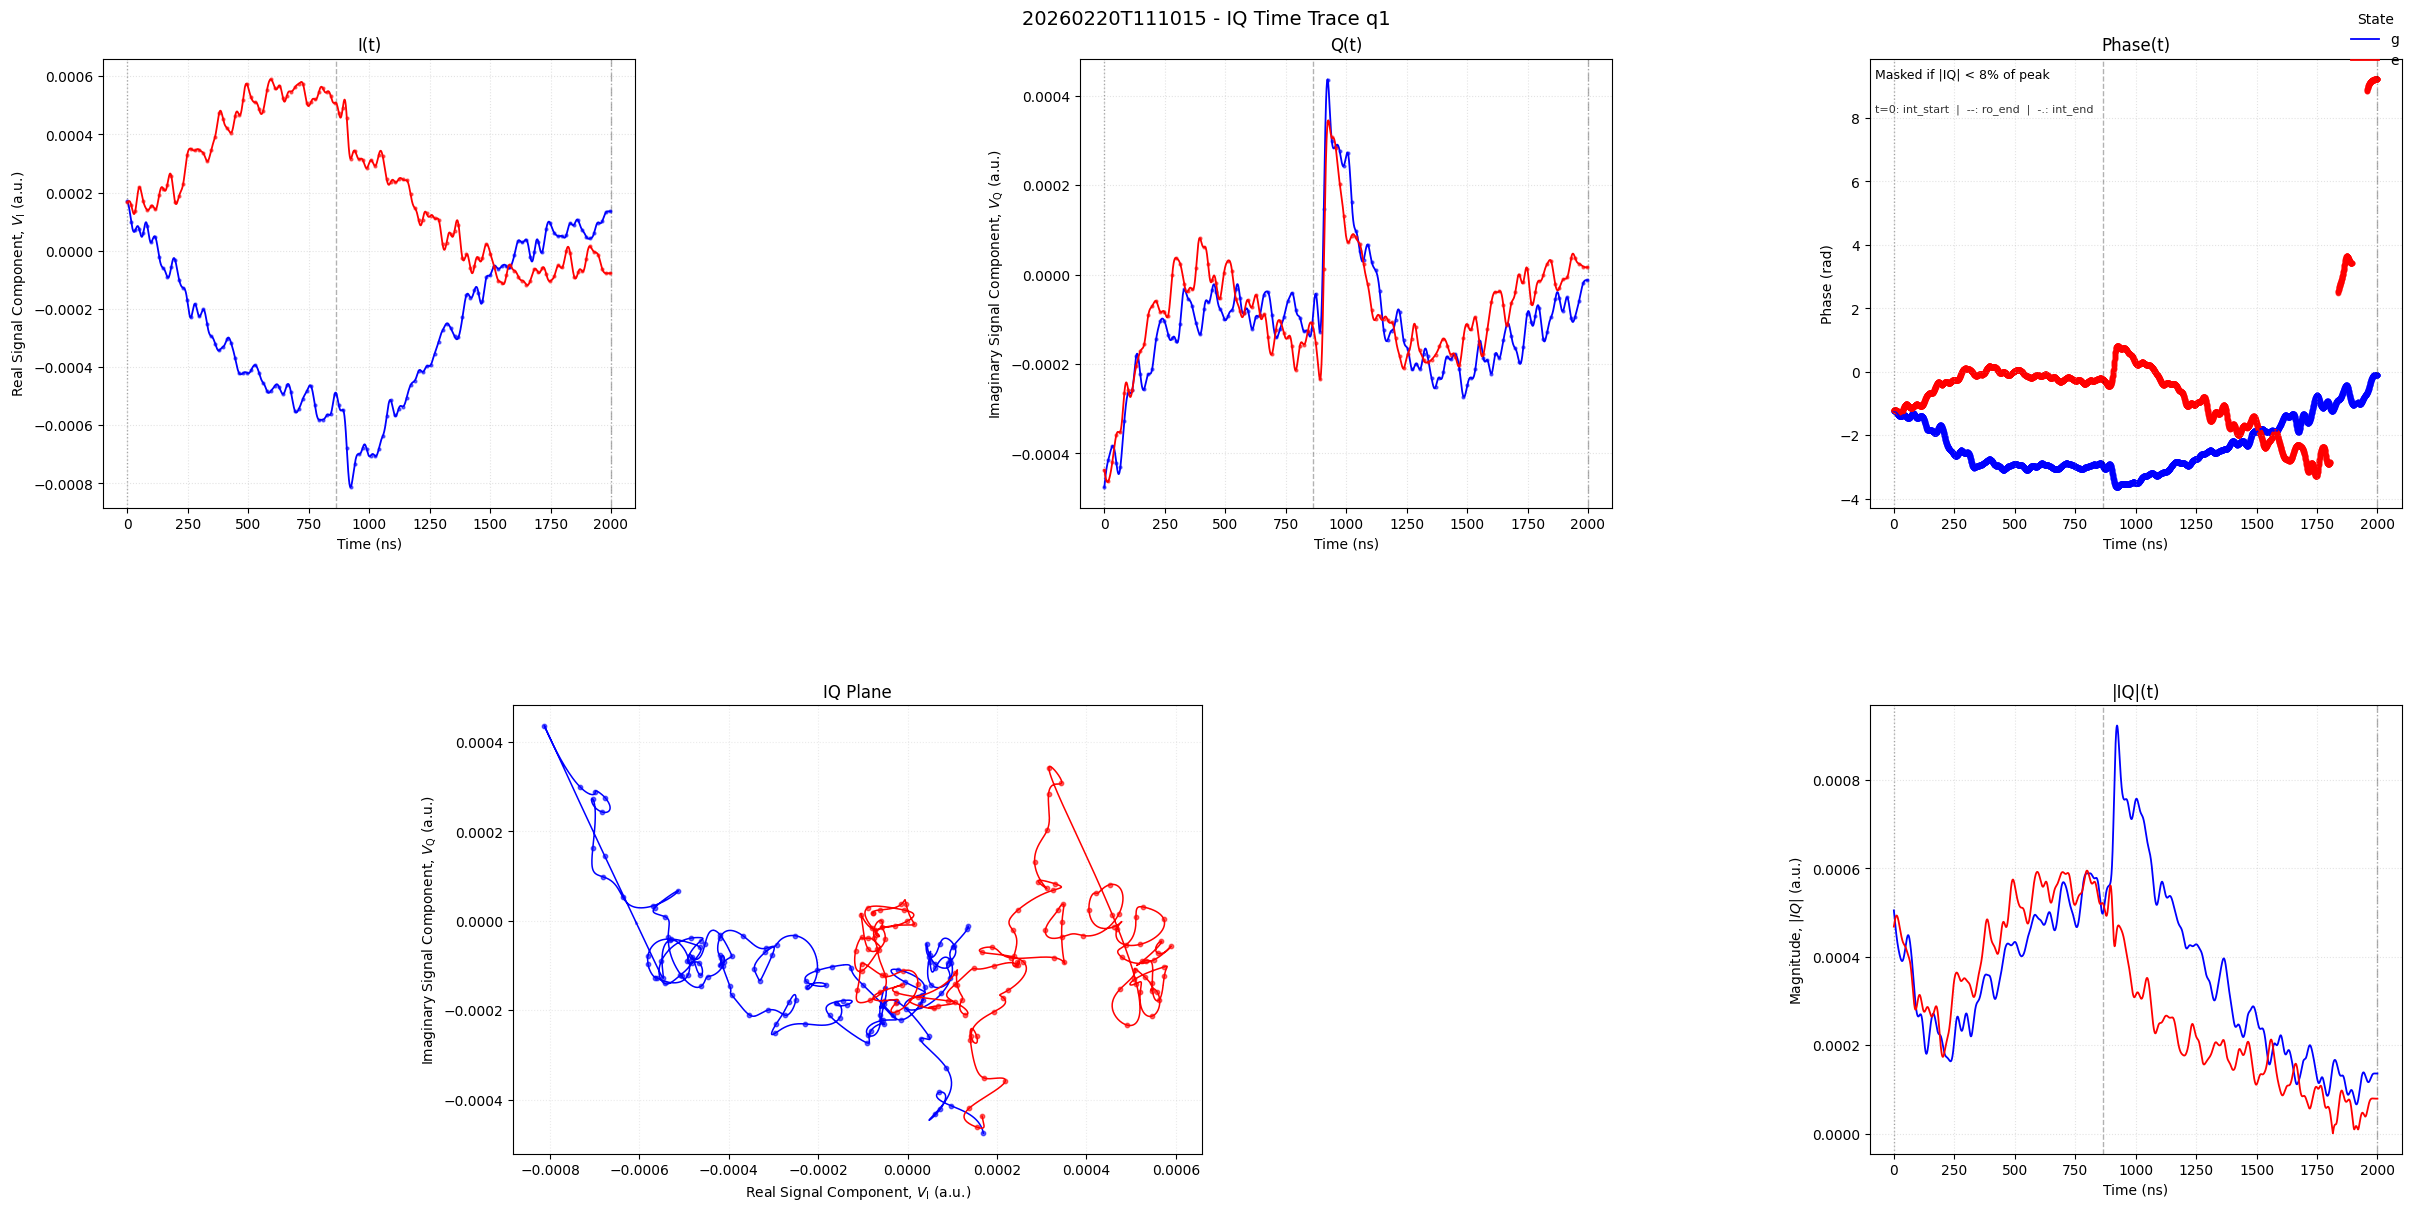

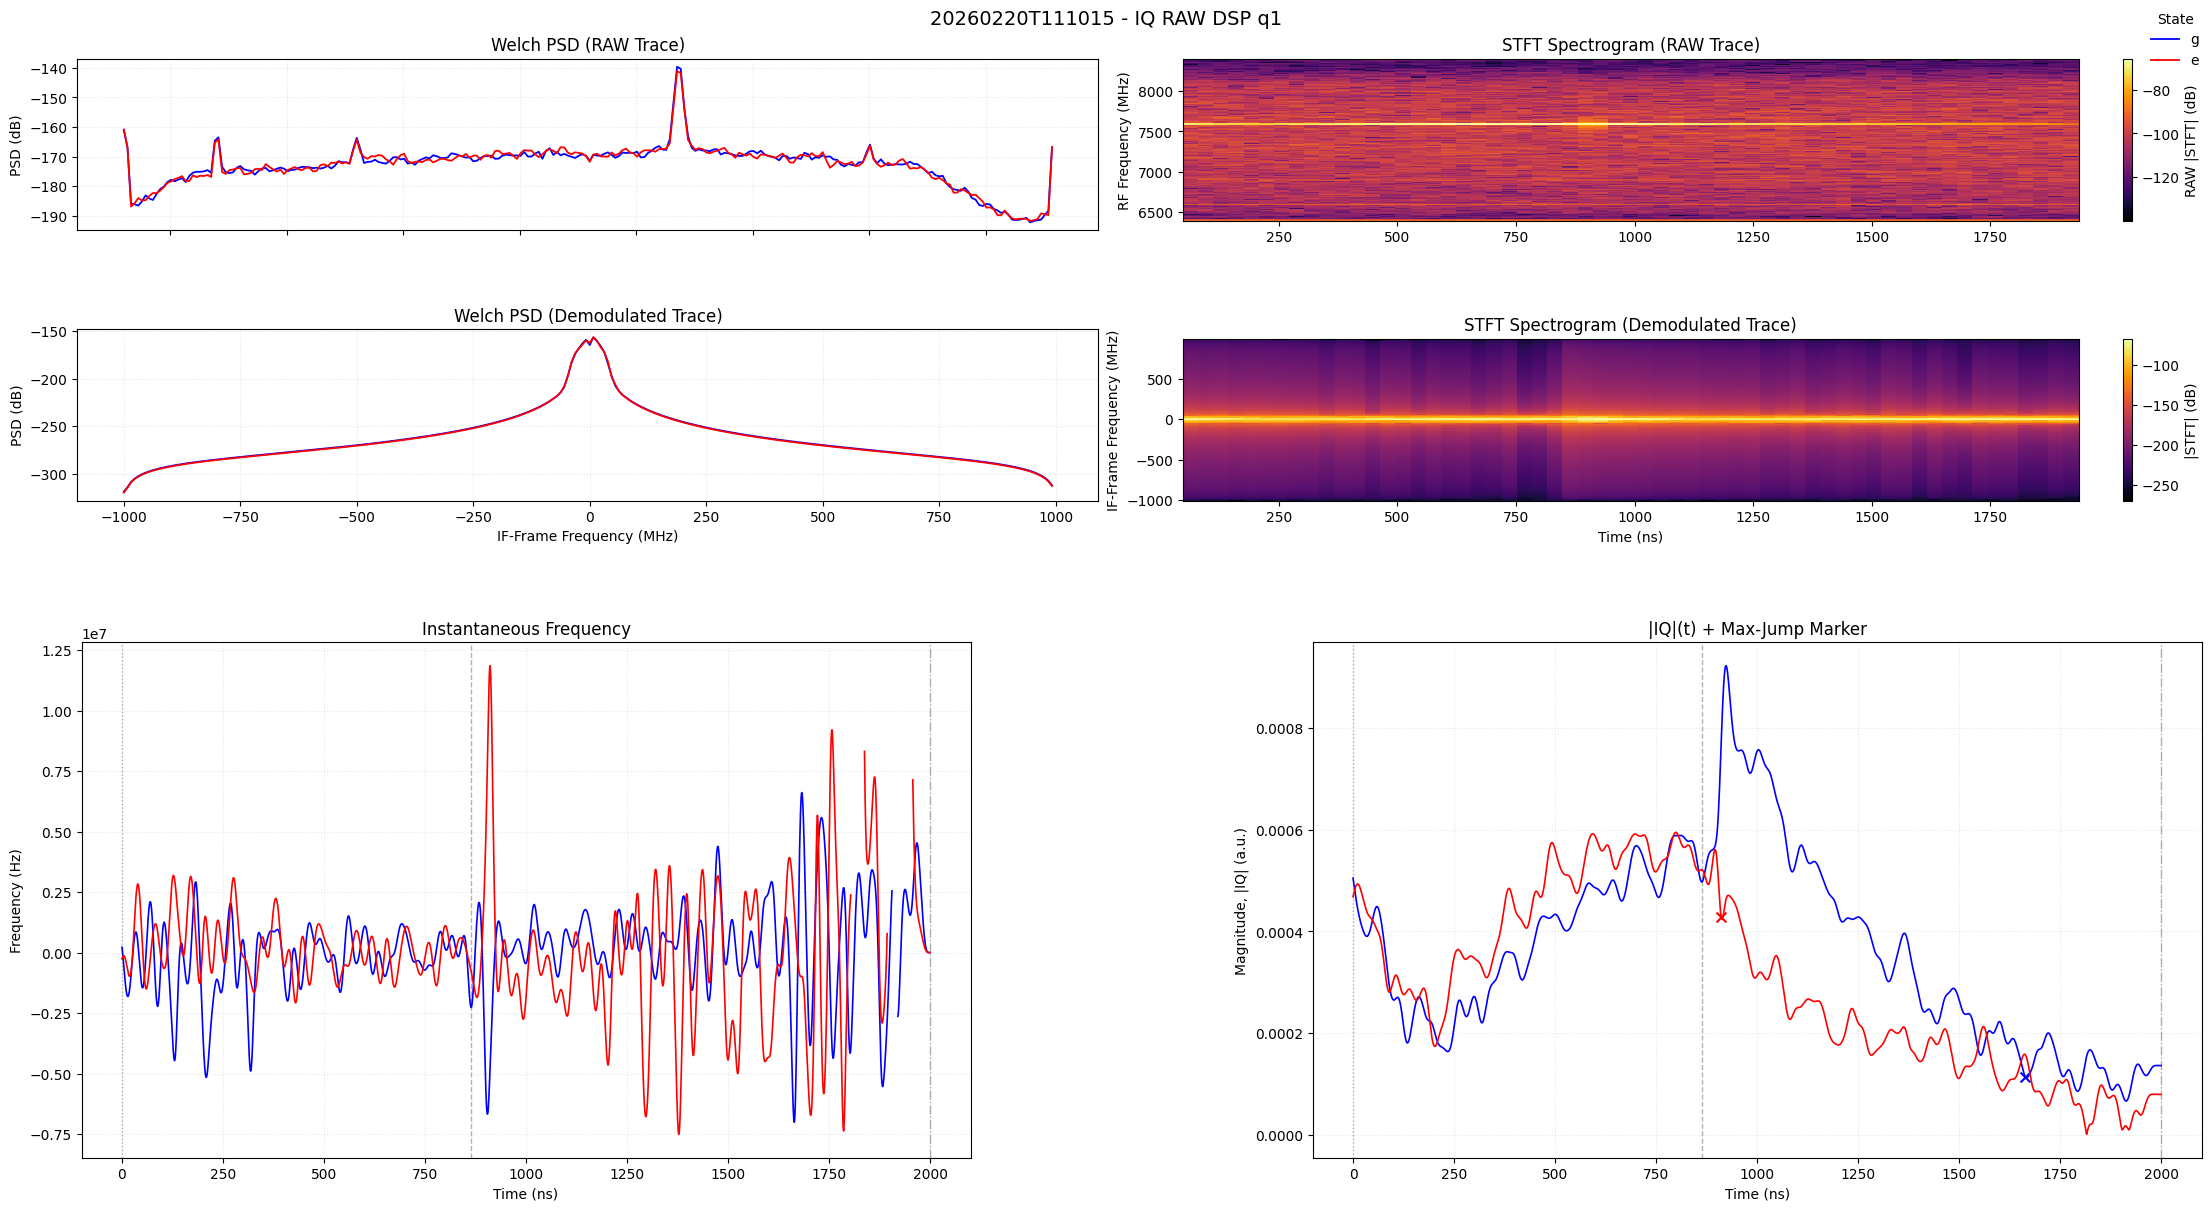

In [6]:
import importlib
import analysis.iq_time_trace as a_iqt
import experiments.iq_time_trace as e_iqt
from IPython.display import display

importlib.reload(a_iqt)
importlib.reload(e_iqt)

###################################################################################
q=qubits[1]
temporary_parameters = {}
temp_pars =deepcopy(q.parameters)
#temp_pars.readout_integration_delay = 200e-9
temp_pars.readout_integration_length = 2.0e-6
#temp_pars.readout_length = 1e-6
#temp_pars.readout_pulse['sigma'] = 0.1
temporary_parameters[q.uid] = temp_pars
#######################################################################
print(f"DRIVE range (dBm) : {q.parameters.drive_range}, READOUT range (dBm) : {q.parameters.readout_range_out}")
print(q.readout_parameters())
#######################################################################
opts = e_iqt.experiment_workflow.options()
#options.count(2**14)
opts.do_analysis(True)
opts.apply_software_demodulation(True)
opts.apply_lpf_after_demodulation(True)
opts.count(1024*7)
opts.lpf_cutoff_frequency_hz(30e6)


#print(workflow.show_fields(options))

###################################################################
iq_t = e_iqt.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=q,
    options=opts,
    states='ge',
    temporary_parameters=temporary_parameters
)

iq_trace_result = iq_t.run()
#qubit_spec_compiled = session.compile(amplitude_rabi.create_experiment(qpu=qpu,qubit=q,amplitudes=amplitudes, options=options))
display(iq_trace_result.tasks['analysis_workflow'].tasks['plot_iq_time_traces'].output[q.uid])
try:
    display(iq_trace_result.tasks['analysis_workflow'].tasks['plot_iq_dsp'].output[q.uid])
except KeyError:
    pass


# SAVE QPU

In [ ]:
# from laboneq.serializers import save, load, from_dict, from_json, to_dict, to_json
# import time

# t = time.localtime()
# timestamp = time.strftime('%Y%m%d-%H%M', t)

# filename = "readout_opt"
# save(qpu, filename=f"./qpu_parameters/{timestamp}_{filename}") 

